In [5]:
#run pipeline
import torch
import torch.nn as nn
import torch.nn.functional as F
import yaml
import os
import numpy as np
import pandas as pd
import pprint 
import json
pp = pprint.PrettyPrinter(indent=4)
from torch.utils.data import DataLoader, Dataset
import traceback
import sys
from torchmetrics.classification import MultilabelAUROC, MultilabelF1Score, BinaryAUROC, BinaryF1Score
from torcheval.metrics import MultilabelAUPRC, BinaryAUPRC, MultilabelAccuracy, BinaryAccuracy
from statistics import mean
import torch.optim as optim
import gc
import torch
from torch.utils.data import DataLoader, TensorDataset
import wandb
import functools
import hashlib
from tqdm import tqdm
import time
#from ResNet import *
#from vit_pytorch import *
#from cross_vit_pytorch import *


In [7]:
pd.set_option('display.max_columns', None)

metadata = pd.read_parquet('/media/data1/muse_ge/test_trial_v1.1.parquet')
#metadata = pd.read_parquet("/media/datasets/anolin/benchmark2/test_trial_v1.1.parquet")
# calculated_age, RestingECG_PatientDemographics_Gender, RestingECG_PatientDemographics_Race
metadata


index                                           npy_path  \
8              8  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
39            39  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
40            40  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
41            41  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
62            62  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
...          ...                                                ...   
1453926  1453926  /media/data1/anolin/temp_new_dataset/ecg_npy/P...   
1453927  1453927  /media/data1/anolin/temp_new_dataset/ecg_npy/R...   
1453930  1453930  /media/data1/anolin/temp_new_dataset/ecg_npy/X...   
1453931  1453931  /media/data1/anolin/temp_new_dataset/ecg_npy/X...   
1453936  1453936  /media/data1/anolin/temp_new_dataset/ecg_npy/b...   

        RestingECG_MuseInfo_MuseVersion new_PatientID  changed_ID  \
8                          9.0.10.18530       0000009           0   
39                         9.0.10.18530       0000037           0   
40                         9.0.10.18530       0000037           0   
41                         9.0.10.18530       0000037           0   
62                         9.0.10.18530       0000083           0   
...                                 ...           ...         ...   
1453926                    9.0.10.18530       0354646           1   
1453927                    9.0.10.18530       0389798           1   
1453930                    9.0.10.18530       0522345           1   
1453931                    9.0.10.18530       X150938           0   
1453936                    9.0.10.18530       bdt2-00           0   

         still_potentially_bad_ID RestingECG_PatientDemographics_AgeUnits  \
8                               0                                   YEARS   
39                              0                                   YEARS   
40                              0                                   YEARS   
41                              0                                   YEARS   
62                              0                                   YEARS   
...                           ...                                     ...   
1453926                         0                                   YEARS   
1453927                         0                                   YEARS   
1453930                         0                                   YEARS   
1453931                         1                                   YEARS   
1453936                         1                                   YEARS   

        date_of_birth  calculated_age  emergency ecg  \
8          12-25-1969              50              0   
39         03-07-1942              68              0   
40         03-07-1942              68              0   
41         03-07-1942              73              0   
62         03-29-1978              39              0   
...               ...             ...            ...   
1453926    05-29-1949              57              0   
1453927    06-27-1957              51              0   
1453930    10-02-1979              37              0   
1453931    02-07-1994              22              0   
1453936    05-20-1960              61              0   

        RestingECG_PatientDemographics_Gender  \
8                                      FEMALE   
39                                     FEMALE   
40                                     FEMALE   
41                                     FEMALE   
62                                       MALE   
...                                       ...   
1453926                                  MALE   
1453927                                  MALE   
1453930                                  MALE   
1453931                                  MALE   
1453936                                  MALE   

        RestingECG_PatientDemographics_PatientLastName  \
8                                              HARNOIS   
39                        

In [4]:
metadata['RestingECG_PatientDemographics_Race'].unique()

array(['CAUCASIAN', 'UNKNOWN', None, 'BLACK', 'ORIENTAL', 'HISPANIC',
       'ASIAN', 'PACIFIC ISLANDER', 'AMERICAN INDIAN', 'HAWAIIAN'],
      dtype=object)

In [5]:
def propagate_race_with_summary(df, race_col, id_col):
    # Step 1: Normalize the race column, treating 'UNKNOWN' and None as equivalent
    df[race_col] = df[race_col].replace('UNKNOWN', None)
    
    # Initialize statistics
    total_groups = df[id_col].nunique()
    total_entries = len(df)
    unknown_count_before = df[race_col].isna().sum()
    conflicting_groups_count = 0
    unknowns_replaced = 0
    
    # Record initial race counts
    initial_race_counts = df[race_col].value_counts(dropna=False).to_dict()
    
    # Step 2: Define a function to apply the logic to each group of entries
    def process_group(group):
        nonlocal conflicting_groups_count, unknowns_replaced
        
        # Get the unique known (non-None) races in the group
        known_races = group[race_col].dropna().unique()
        
        if len(known_races) == 1:
            # If there's exactly one known race, propagate it to all entries
            unknowns_replaced += group[race_col].isna().sum()
            group['processed_race'] = known_races[0]
        elif len(known_races) > 1:
            # If there are conflicting known races, set all to None
            conflicting_groups_count += 1
            group['processed_race'] = None
        else:
            # If no known races, keep None
            group['processed_race'] = None
        
        return group
    
    # Step 3: Apply the processing function to each group of new_PatientID
    df = df.groupby(id_col).apply(process_group)
    
    # Step 4: Ensure the new column is aligned with the DataFrame
    df = df.reset_index(drop=True)
    
    # Calculate the statistics after processing
    unknown_count_after = df['processed_race'].isna().sum()
    known_race_count = df['processed_race'].notna().sum()
    
    # Record final race counts
    final_race_counts = df['processed_race'].value_counts(dropna=False).to_dict()
    
    # Print the summary
    print("Statistical Summary of Race Propagation:")
    print(f"Total groups (new_PatientID): {total_groups}")
    print(f"Total entries processed: {total_entries}")
    print(f"Initial 'UNKNOWN'/None count: {unknown_count_before}")
    print(f"Conflicting groups count: {conflicting_groups_count}")
    print(f"Unknowns replaced with a known race: {unknowns_replaced}")
    print(f"Final 'UNKNOWN'/None count: {unknown_count_after}")
    print(f"Entries with a known race after processing: {known_race_count}")
    print("\nInitial race counts:")
    for race, count in initial_race_counts.items():
        print(f"  {race}: {count}")
    print("\nFinal race counts:")
    for race, count in final_race_counts.items():
        print(f"  {race}: {count}")
    
    return df



In [6]:
metadata_adjusted = propagate_race_with_summary(metadata, 'RestingECG_PatientDemographics_Race', 'new_PatientID')
metadata_adjusted

Statistical Summary of Race Propagation:
Total groups (new_PatientID): 52098
Total entries processed: 287039
Initial 'UNKNOWN'/None count: 72273
Conflicting groups count: 5346
Unknowns replaced with a known race: 39466
Final 'UNKNOWN'/None count: 100475
Entries with a known race after processing: 186564

Initial race counts:
  CAUCASIAN: 205136
  None: 72273
  BLACK: 6431
  ORIENTAL: 1223
  HISPANIC: 958
  ASIAN: 922
  PACIFIC ISLANDER: 68
  AMERICAN INDIAN: 27
  HAWAIIAN: 1

Final race counts:
  CAUCASIAN: 184992
  None: 100475
  BLACK: 1174
  ORIENTAL: 159
  ASIAN: 119
  HISPANIC: 109
  PACIFIC ISLANDER: 11


index                                           npy_path  \
0             8  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
1            39  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
2            40  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
3            41  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
4            62  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
...         ...                                                ...   
287034  1453926  /media/data1/anolin/temp_new_dataset/ecg_npy/P...   
287035  1453927  /media/data1/anolin/temp_new_dataset/ecg_npy/R...   
287036  1453930  /media/data1/anolin/temp_new_dataset/ecg_npy/X...   
287037  1453931  /media/data1/anolin/temp_new_dataset/ecg_npy/X...   
287038  1453936  /media/data1/anolin/temp_new_dataset/ecg_npy/b...   

       RestingECG_MuseInfo_MuseVersion new_PatientID  changed_ID  \
0                         9.0.10.18530       0000009           0   
1                         9.0.10.18530       0000037           0   
2                         9.0.10.18530       0000037           0   
3                         9.0.10.18530       0000037           0   
4                         9.0.10.18530       0000083           0   
...                                ...           ...         ...   
287034                    9.0.10.18530       0354646           1   
287035                    9.0.10.18530       0389798           1   
287036                    9.0.10.18530       0522345           1   
287037                    9.0.10.18530       X150938           0   
287038                    9.0.10.18530       bdt2-00           0   

        still_potentially_bad_ID RestingECG_PatientDemographics_AgeUnits  \
0                              0                                   YEARS   
1                              0                                   YEARS   
2                              0                                   YEARS   
3                              0                                   YEARS   
4                              0                                   YEARS   
...                          ...                                     ...   
287034                         0                                   YEARS   
287035                         0                                   YEARS   
287036                         0                                   YEARS   
287037                         1                                   YEARS   
287038                         1                                   YEARS   

       date_of_birth  calculated_age  emergency ecg  \
0         12-25-1969              50              0   
1         03-07-1942              68              0   
2         03-07-1942              68              0   
3         03-07-1942              73              0   
4         03-29-1978              39              0   
...              ...             ...            ...   
287034    05-29-1949              57              0   
287035    06-27-1957              51              0   
287036    10-02-1979              37              0   
287037    02-07-1994              22              0   
287038    05-20-1960              61              0   

       RestingECG_PatientDemographics_Gender  \
0                                     FEMALE   
1                                     FEMALE   
2                                     FEMALE   
3                                     FEMALE   
4                                       MALE   
...                                      ...   
287034                                  MALE   
287035                                  MALE   
287036                                  MALE   
287037                                  MALE   
287038                                  MALE   

       RestingECG_PatientDemographics_PatientLastName  \
0                                             HARNOIS   
1                                             MAILHOT   
2                             

In [4]:
X_eval = np.load('/media/datasets/anolin/benchmark2/X_test_v1.2.npy').astype(np.float16)
Y_eval = np.load('/media/datasets/anolin/benchmark2/Y_test_v1.2.npy').astype(np.float16)

list_clean_labels = ['Sinusal','Regular','Monomorph','QS complex in V1-V2-V3','R complex in V5-V6','T wave inversion (inferior - II, III, aVF)','Left bundle branch block','RaVL > 11 mm','SV1 + RV5 or RV6 > 35 mm','T wave inversion (lateral -I, aVL, V5-V6)','T wave inversion (anterior - V3-V4)','Left axis deviation','Left ventricular hypertrophy','Bradycardia','Q wave (inferior - II, III, aVF)','Afib','Irregularly irregular','Atrial tachycardia (>= 100 BPM)','Nonspecific intraventricular conduction delay','Premature ventricular complex','Polymorph','T wave inversion (septal- V1-V2)','Right bundle branch block','Ventricular paced','ST elevation (anterior - V3-V4)','ST elevation (septal - V1-V2)','1st degree AV block','Premature atrial complex','Atrial flutter',"rSR' in V1-V2",'qRS in V5-V6-I, aVL','Left anterior fascicular block','Right axis deviation','2nd degree AV block - mobitz 1','ST depression (inferior - II, III, aVF)','Acute pericarditis','ST elevation (inferior - II, III, aVF)','Low voltage','Regularly irregular','Bifid','Junctional rhythm','Left atrial enlargement','ST elevation (lateral - I, aVL, V5-V6)','Atrial paced','Right ventricular hypertrophy','Delta wave','Wolff-Parkinson-White (Pre-excitation syndrome)','Prolonged QT','ST depression (anterior - V3-V4)','QRS complex negative in III','RaVL + SV3 > 28 mm (H) or 20 mm (F)','Q wave (lateral- I, aVL, V5-V6)','Hyperacute T wave (lateral, V5-V6)','Hyperacute T wave (septal, V1-V2)','Supraventricular tachycardia','ST downslopping','ST depression (lateral - I, avL, V5-V6)','2nd degree AV block - mobitz 2','U wave','ST depression et T inversion in V5 or V6','Large >0.08 s','R/S ratio in V1-V2 >1','RV1 + SV6\xa0> 11 mm','Left posterior fascicular block','Right atrial enlargement','ST depression (septal- V1-V2)','Q wave (septal- V1-V2)','Q wave (anterior - V3-V4)','Hyperacute T wave (anterior, V3-V4)','ST upslopping','Right superior axis','Auricular bigeminy','Ventricular tachycardia','ST elevation (posterior - V7-V8-V9)','Ectopic atrial rhythm (< 100 BPM)','Lead misplacement','Biphasic','Ventricular bigeminy','J wave','Tall >2.5 mm','Third Degree AV Block','Sinus Pause','Acute MI','Early repolarization','Q wave (posterior - V7-V9)','Bi-atrial enlargement','LV pacing','Dextrocardia','Brugada','Ventricular Rhythm','ST depression (posterior - V7-V8-V9)','no_qrs']
labels_to_remove = ['ST depression (posterior - V7-V8-V9)','Tall >2.5 mm', 'J wave', 'Auricular bigeminy', 'Ventricular bigeminy', 'Sinus Pause', 'Dextrocardia', 'Hyperacute T wave (lateral, V5-V6)', 'Hyperacute T wave (septal, V1-V2)', 'Hyperacute T wave (anterior, V3-V4)', 'Bifid', 'RaVL + SV3 > 28 mm (H) or 20 mm (F)', 'Large >0.08 s', 'Biphasic', 'ST depression et T inversion in V5 or V6']

pos_to_drop = list()
new_label_names = list()
for pos, item in enumerate(list_clean_labels):
    if item in labels_to_remove:
        pos_to_drop.append(pos)
    else:
        new_label_names.append(item)

Y_eval = np.delete(Y_eval, pos_to_drop, axis=1)
Y_eval

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]], dtype=float16)

In [10]:
categories = {
    "RHYTHM": [
      "Ventricular tachycardia",
      "Bradycardia",
      "Brugada",
      "Wolff-Parkinson-White (Pre-excitation syndrome)",
      "Atrial flutter",
      "Ectopic atrial rhythm (< 100 BPM)",
      "Atrial tachycardia (>= 100 BPM)",
      "Sinusal",
      "Ventricular Rhythm",
      "Supraventricular tachycardia",
      "Junctional rhythm",
      "Regular",
      "Regularly irregular",
      "Irregularly irregular",
      "Afib",
      "Premature ventricular complex",
      "Premature atrial complex"
    ],
    "CONDUCTION": [
      "Left anterior fascicular block",
      "Delta wave",
      "2nd degree AV block - mobitz 2",
      "Left bundle branch block",
      "Right bundle branch block",
      "Left axis deviation",
      "Atrial paced",
      "Right axis deviation",
      "Left posterior fascicular block",
      "1st degree AV block",
      "Right superior axis",
      "Nonspecific intraventricular conduction delay",
      "Third Degree AV Block",
      "2nd degree AV block - mobitz 1",
      "Prolonged QT",
      "U wave",
      "LV pacing",
      "Ventricular paced"
    ],
    "CHAMBER ENLARGEMENT": [
      "Bi-atrial enlargement",
      "Left atrial enlargement",
      "Right atrial enlargement",
      "Left ventricular hypertrophy",
      "Right ventricular hypertrophy"
    ],
    "PERICARDITIS": [
      "Acute pericarditis"
    ],
    "INFARCT, ISCHEMIA": [
      "Q wave (septal- V1-V2)",
      "ST elevation (anterior - V3-V4)",
      "Q wave (posterior - V7-V9)",
      "Q wave (inferior - II, III, aVF)",
      "Q wave (anterior - V3-V4)",
      "ST elevation (lateral - I, aVL, V5-V6)",
      "Q wave (lateral- I, aVL, V5-V6)",
      "ST depression (lateral - I, avL, V5-V6)",
      "Acute MI",
      "ST elevation (septal - V1-V2)",
      "ST elevation (inferior - II, III, aVF)",
      "ST elevation (posterior - V7-V8-V9)",
      "ST depression (inferior - II, III, aVF)",
      "ST depression (anterior - V3-V4)"
    ],
    "OTHER": [
      "ST downslopping",
      "ST depression (septal- V1-V2)",
      "R/S ratio in V1-V2 >1",
      "RV1 + SV6 > 11 mm",
      "Polymorph",
      "rSR' in V1-V2",
      "QRS complex negative in III",
      "qRS in V5-V6-I, aVL",
      "QS complex in V1-V2-V3",
      "R complex in V5-V6",
      "RaVL > 11 mm",
      "T wave inversion (septal- V1-V2)",
      "SV1 + RV5 or RV6 > 35 mm",
      "T wave inversion (inferior - II, III, aVF)",
      "Monomorph",
      "T wave inversion (anterior - V3-V4)",
      "T wave inversion (lateral -I, aVL, V5-V6)",
      "Low voltage",
      "Lead misplacement",
      "ST depression (anterior - V3-V4)",
      "Early repolarization",
      "ST upslopping",
      "no_qrs"
    ]
  }

In [24]:
# calculated_age, RestingECG_PatientDemographics_Gender, processed_race
metadata_adjusted

index                                           npy_path  \
0             8  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
1            39  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
2            40  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
3            41  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
4            62  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
...         ...                                                ...   
287034  1453926  /media/data1/anolin/temp_new_dataset/ecg_npy/P...   
287035  1453927  /media/data1/anolin/temp_new_dataset/ecg_npy/R...   
287036  1453930  /media/data1/anolin/temp_new_dataset/ecg_npy/X...   
287037  1453931  /media/data1/anolin/temp_new_dataset/ecg_npy/X...   
287038  1453936  /media/data1/anolin/temp_new_dataset/ecg_npy/b...   

       RestingECG_MuseInfo_MuseVersion new_PatientID  changed_ID  \
0                         9.0.10.18530       0000009           0   
1                         9.0.10.18530       0000037           0   
2                         9.0.10.18530       0000037           0   
3                         9.0.10.18530       0000037           0   
4                         9.0.10.18530       0000083           0   
...                                ...           ...         ...   
287034                    9.0.10.18530       0354646           1   
287035                    9.0.10.18530       0389798           1   
287036                    9.0.10.18530       0522345           1   
287037                    9.0.10.18530       X150938           0   
287038                    9.0.10.18530       bdt2-00           0   

        still_potentially_bad_ID RestingECG_PatientDemographics_AgeUnits  \
0                              0                                   YEARS   
1                              0                                   YEARS   
2                              0                                   YEARS   
3                              0                                   YEARS   
4                              0                                   YEARS   
...                          ...                                     ...   
287034                         0                                   YEARS   
287035                         0                                   YEARS   
287036                         0                                   YEARS   
287037                         1                                   YEARS   
287038                         1                                   YEARS   

       date_of_birth  calculated_age  emergency ecg  \
0         12-25-1969              50              0   
1         03-07-1942              68              0   
2         03-07-1942              68              0   
3         03-07-1942              73              0   
4         03-29-1978              39              0   
...              ...             ...            ...   
287034    05-29-1949              57              0   
287035    06-27-1957              51              0   
287036    10-02-1979              37              0   
287037    02-07-1994              22              0   
287038    05-20-1960              61              0   

       RestingECG_PatientDemographics_Gender  \
0                                     FEMALE   
1                                     FEMALE   
2                                     FEMALE   
3                                     FEMALE   
4                                       MALE   
...                                      ...   
287034                                  MALE   
287035                                  MALE   
287036                                  MALE   
287037                                  MALE   
287038                                  MALE   

       RestingECG_PatientDemographics_PatientLastName  \
0                                             HARNOIS   
1                                             MAILHOT   
2                             

In [25]:
import torch

def equalized_odds(predictions, true_labels, protected_attributes, average='macro', categories_dict=None, column_names=None):
    """
    Calculate Equalized Odds for a multilabel classification model across multiple groups.

    Args:
        predictions (np.ndarray): Array of model predictions (N, num_labels) with binary values.
        true_labels (np.ndarray): Array of true labels (N, num_labels) with binary values.
        protected_attributes (np.ndarray): Array of protected attribute values (N,) (can be multiple groups).
        average (str): 'micro' or 'macro' averaging.
        categories_dict (dict): Dictionary mapping categories to lists of label names (optional).
        column_names (list): List of column names corresponding to the order in predictions (optional).

    Returns:
        float or dict: Average Equalized Odds difference using specified averaging method, either overall or per category.
    """
    # Convert inputs to PyTorch tensors
    predictions = torch.tensor(predictions, dtype=torch.float32)
    true_labels = torch.tensor(true_labels, dtype=torch.float32)
    protected_attributes = torch.tensor(protected_attributes, dtype=torch.float32)

    # Filter out entries where protected_attributes is None (NaN in numpy)
    valid_mask = ~torch.isnan(protected_attributes)
    predictions = predictions[valid_mask]
    true_labels = true_labels[valid_mask]
    protected_attributes = protected_attributes[valid_mask]

    def calculate_rates(group_preds, group_labels):
        """Helper function to calculate TPR and FPR for a group."""
        true_positive = (group_preds * group_labels).sum(dim=0)
        false_positive = (group_preds * (1 - group_labels)).sum(dim=0)
        total_positive = group_labels.sum(dim=0)
        total_negative = (1 - group_labels).sum(dim=0)

        tpr = true_positive / total_positive
        fpr = false_positive / total_negative

        return tpr, fpr

    if categories_dict and column_names:
        results = {}
        for category, names in categories_dict.items():
            indices = [column_names.index(name) for name in names if name in column_names]
            category_preds = predictions[:, indices]
            category_labels = true_labels[:, indices]

            unique_groups = torch.unique(protected_attributes)
            group_rates = []

            for group in unique_groups:
                group_preds = category_preds[protected_attributes == group]
                group_labels = category_labels[protected_attributes == group]
                tpr, fpr = calculate_rates(group_preds, group_labels)
                group_rates.append((tpr, fpr))

            tprs, fprs = zip(*group_rates)
            tprs = torch.stack(tprs)
            fprs = torch.stack(fprs)

            if average == 'micro':
                avg_tpr_diff = torch.mean(torch.max(tprs, dim=0)[0] - torch.min(tprs, dim=0)[0])
                avg_fpr_diff = torch.mean(torch.max(fprs, dim=0)[0] - torch.min(fprs, dim=0)[0])
            elif average == 'macro':
                avg_tpr_diff = torch.mean(torch.max(tprs, dim=1)[0] - torch.min(tprs, dim=1)[0])
                avg_fpr_diff = torch.mean(torch.max(fprs, dim=1)[0] - torch.min(fprs, dim=1)[0])
            else:
                raise ValueError("average must be 'micro' or 'macro'")

            results[category] = {'tpr_diff': avg_tpr_diff.item(), 'fpr_diff': avg_fpr_diff.item()}

        return results
    else:
        # Calculate overall Equalized Odds
        unique_groups = torch.unique(protected_attributes)
        group_rates = []

        for group in unique_groups:
            group_preds = predictions[protected_attributes == group]
            group_labels = true_labels[protected_attributes == group]
            tpr, fpr = calculate_rates(group_preds, group_labels)
            group_rates.append((tpr, fpr))

        tprs, fprs = zip(*group_rates)
        tprs = torch.stack(tprs)
        fprs = torch.stack(fprs)

        if average == 'micro':
            avg_tpr_diff = torch.mean(torch.max(tprs, dim=0)[0] - torch.min(tprs, dim=0)[0])
            avg_fpr_diff = torch.mean(torch.max(fprs, dim=0)[0] - torch.min(fprs, dim=0)[0])
        elif average == 'macro':
            avg_tpr_diff = torch.mean(torch.max(tprs, dim=1)[0] - torch.min(tprs, dim=1)[0])
            avg_fpr_diff = torch.mean(torch.max(fprs, dim=1)[0] - torch.min(fprs, dim=1)[0])
        else:
            raise ValueError("average must be 'micro' or 'macro'")

        return {'tpr_diff': avg_tpr_diff.item(), 'fpr_diff': avg_fpr_diff.item()}

In [42]:
import torch
import numpy as np
from tqdm import tqdm

#IMPORTANT ONE

def equalized_odds_with_permutations(predictions, true_labels, protected_attributes, average='macro', 
                                     categories_dict=None, column_names=None, num_iterations=1000, sample_fraction=0.7):
    """
    Calculate Equalized Odds with permutation sampling for a multilabel classification model across multiple groups.
    Performs multiple iterations, sampling 80% of the data each time, and calculates the mean and 95% confidence interval
    for TPR and FPR differences across groups for each category.

    Args:
        predictions (np.ndarray): Array of model predictions (N, num_labels) with binary values.
        true_labels (np.ndarray): Array of true labels (N, num_labels) with binary values.
        protected_attributes (np.ndarray): Array of protected attribute values (N,).
        average (str): 'micro' or 'macro' averaging.
        categories_dict (dict): Dictionary mapping categories to lists of label names (optional).
        column_names (list): List of column names corresponding to the order in predictions (optional).
        num_iterations (int): Number of iterations for permutation sampling.
        sample_fraction (float): Fraction of the data to sample in each iteration.

    Returns:
        dict: Mean and 95% CI for TPR and FPR differences across groups for each category or overall.
    """
    # Convert inputs to PyTorch tensors
    predictions = torch.tensor(predictions, dtype=torch.float32)
    true_labels = torch.tensor(true_labels, dtype=torch.float32)
    protected_attributes = torch.tensor(protected_attributes, dtype=torch.float32)

    # Helper function to calculate TPR and FPR
    def calculate_rates(group_preds, group_labels):
        true_positive = (group_preds * group_labels).sum(dim=0)
        false_positive = (group_preds * (1 - group_labels)).sum(dim=0)
        total_positive = group_labels.sum(dim=0)
        total_negative = (1 - group_labels).sum(dim=0)
        
        # Avoid division by zero by setting TPR or FPR to zero if the denominator is zero
        tpr = torch.where(total_positive > 0, true_positive / total_positive, torch.zeros_like(total_positive))
        fpr = torch.where(total_negative > 0, false_positive / total_negative, torch.zeros_like(total_negative))
        
        return tpr, fpr

    # Initialize storage for TPR and FPR differences per category
    tpr_diffs = {category: [] for category in (categories_dict.keys() if categories_dict else ['overall'])}
    fpr_diffs = {category: [] for category in (categories_dict.keys() if categories_dict else ['overall'])}

    # Use tqdm to track progress over num_iterations
    for _ in tqdm(range(num_iterations), desc="Calculating Equalized Odds Permutations"):
        # Randomly sample 80% of the data
        sample_size = int(sample_fraction * len(predictions))
        indices = torch.randperm(len(predictions))[:sample_size]
        
        # Get sampled data
        sampled_predictions = predictions[indices]
        sampled_true_labels = true_labels[indices]
        sampled_protected_attributes = protected_attributes[indices]
        
        if categories_dict and column_names:
            for category, names in categories_dict.items():
                indices = [column_names.index(name) for name in names if name in column_names]
                category_preds = sampled_predictions[:, indices]
                category_labels = sampled_true_labels[:, indices]

                unique_groups = torch.unique(sampled_protected_attributes)
                group_rates = []

                for group in unique_groups:
                    group_preds = category_preds[sampled_protected_attributes == group]
                    group_labels = category_labels[sampled_protected_attributes == group]

                    # Skip empty groups
                    if group_preds.numel() == 0 or group_labels.numel() == 0:
                        continue
                    
                    tpr, fpr = calculate_rates(group_preds, group_labels)
                    group_rates.append((tpr, fpr))

                # Ensure we have at least two groups to compare TPR and FPR differences
                if len(group_rates) < 2:
                    continue

                tprs, fprs = zip(*group_rates)
                tprs = torch.stack(tprs)
                fprs = torch.stack(fprs)

                if average == 'micro':
                    avg_tpr_diff = torch.mean(torch.max(tprs, dim=0)[0] - torch.min(tprs, dim=0)[0])
                    avg_fpr_diff = torch.mean(torch.max(fprs, dim=0)[0] - torch.min(fprs, dim=0)[0])
                elif average == 'macro':
                    avg_tpr_diff = torch.mean(torch.max(tprs, dim=1)[0] - torch.min(tprs, dim=1)[0])
                    avg_fpr_diff = torch.mean(torch.max(fprs, dim=1)[0] - torch.min(fprs, dim=1)[0])
                else:
                    raise ValueError("average must be 'micro' or 'macro'")

                tpr_diffs[category].append(avg_tpr_diff.item())
                fpr_diffs[category].append(avg_fpr_diff.item())
        else:
            # Calculate overall Equalized Odds
            unique_groups = torch.unique(sampled_protected_attributes)
            group_rates = []

            for group in unique_groups:
                group_preds = sampled_predictions[sampled_protected_attributes == group]
                group_labels = sampled_true_labels[sampled_protected_attributes == group]

                # Skip empty groups
                if group_preds.numel() == 0 or group_labels.numel() == 0:
                    continue
                
                tpr, fpr = calculate_rates(group_preds, group_labels)
                group_rates.append((tpr, fpr))

            # Ensure we have at least two groups to compare TPR and FPR differences
            if len(group_rates) < 2:
                continue

            tprs, fprs = zip(*group_rates)
            tprs = torch.stack(tprs)
            fprs = torch.stack(fprs)

            if average == 'micro':
                avg_tpr_diff = torch.mean(torch.max(tprs, dim=0)[0] - torch.min(tprs, dim=0)[0])
                avg_fpr_diff = torch.mean(torch.max(fprs, dim=0)[0] - torch.min(fprs, dim=0)[0])
            elif average == 'macro':
                avg_tpr_diff = torch.mean(torch.max(tprs, dim=1)[0] - torch.min(tprs, dim=1)[0])
                avg_fpr_diff = torch.mean(torch.max(fprs, dim=1)[0] - torch.min(fprs, dim=1)[0])
            else:
                raise ValueError("average must be 'micro' or 'macro'")

            tpr_diffs['overall'].append(avg_tpr_diff.item())
            fpr_diffs['overall'].append(avg_fpr_diff.item())

    # Calculate mean and 95% CI for each category
    results = {}
    for category in tpr_diffs:
        tpr_diff_array = np.array(tpr_diffs[category])
        fpr_diff_array = np.array(fpr_diffs[category])
        
        tpr_mean = np.mean(tpr_diff_array)
        fpr_mean = np.mean(fpr_diff_array)
        
        tpr_ci = np.percentile(tpr_diff_array, [2.5, 97.5])
        fpr_ci = np.percentile(fpr_diff_array, [2.5, 97.5])
        
        results[category] = {
            'tpr_diff_mean': tpr_mean,
            'tpr_diff_ci': tpr_ci,
            'fpr_diff_mean': fpr_mean,
            'fpr_diff_ci': fpr_ci
        }

    return results

In [45]:
import torch
import numpy as np
from tqdm import tqdm

def demographic_parity_with_permutations(predictions, protected_attributes, average='macro', 
                                         categories_dict=None, column_names=None, num_iterations=1000, sample_fraction=0.8):
    """
    Calculate Demographic Parity with permutation sampling for a multilabel classification model across multiple groups.
    Performs multiple iterations, sampling 80% of the data each time, and calculates the mean and 95% confidence interval
    for Demographic Parity differences across groups, either overall or per category.

    Args:
        predictions (np.ndarray): Array of model predictions (N, num_labels) with binary values.
        protected_attributes (np.ndarray): Array of protected attribute values (N,).
        average (str): 'micro' or 'macro' averaging.
        categories_dict (dict): Dictionary mapping categories to lists of label names (optional).
        column_names (list): List of column names corresponding to the order in predictions (optional).
        num_iterations (int): Number of iterations for permutation sampling.
        sample_fraction (float): Fraction of the data to sample in each iteration.

    Returns:
        dict: Mean and 95% CI for Demographic Parity difference across groups for each category or overall.
    """
    # Convert inputs to PyTorch tensors
    predictions = torch.tensor(predictions, dtype=torch.float32)
    protected_attributes = torch.tensor(protected_attributes, dtype=torch.float32)
    
    # Initialize storage for Demographic Parity differences per category or overall
    dp_diffs = {category: [] for category in (categories_dict.keys() if categories_dict else ['overall'])}

    # Use tqdm to track progress over num_iterations
    for _ in tqdm(range(num_iterations), desc="Calculating Demographic Parity Permutations"):
        # Randomly sample 80% of the data
        sample_size = int(sample_fraction * len(predictions))
        indices = torch.randperm(len(predictions))[:sample_size]
        
        # Get sampled data
        sampled_predictions = predictions[indices]
        sampled_protected_attributes = protected_attributes[indices]

        if categories_dict and column_names:
            # Calculate per-category Demographic Parity
            for category, names in categories_dict.items():
                indices = [column_names.index(name) for name in names if name in column_names]
                category_preds = sampled_predictions[:, indices]
                
                unique_groups = torch.unique(sampled_protected_attributes)
                group_probs = []

                for group in unique_groups:
                    group_prob = category_preds[sampled_protected_attributes == group].float().mean(dim=0)
                    group_probs.append(group_prob)

                group_probs = torch.stack(group_probs)  # Shape: (num_groups, num_labels)
                
                if average == 'micro':
                    avg_diff = torch.mean(torch.mean(group_probs, dim=1)) - torch.mean(torch.min(group_probs, dim=1)[0])
                elif average == 'macro':
                    avg_diff = torch.mean(torch.mean(group_probs, dim=0)) - torch.mean(torch.min(group_probs, dim=0)[0])
                else:
                    raise ValueError("average must be 'micro' or 'macro'")

                dp_diffs[category].append(avg_diff.item())
        else:
            # Calculate overall Demographic Parity
            unique_groups = torch.unique(sampled_protected_attributes)
            group_probs = []

            for group in unique_groups:
                group_prob = sampled_predictions[sampled_protected_attributes == group].float().mean(dim=0)
                group_probs.append(group_prob)

            group_probs = torch.stack(group_probs)  # Shape: (num_groups, num_labels)
            
            if average == 'micro':
                avg_diff = torch.mean(torch.mean(group_probs, dim=1)) - torch.mean(torch.min(group_probs, dim=1)[0])
            elif average == 'macro':
                avg_diff = torch.mean(torch.mean(group_probs, dim=0)) - torch.mean(torch.min(group_probs, dim=0)[0])
            else:
                raise ValueError("average must be 'micro' or 'macro'")

            dp_diffs['overall'].append(avg_diff.item())

    # Calculate mean and 95% CI for each category or overall
    dp_results = {}
    for category, diffs in dp_diffs.items():
        diffs = np.array(diffs)
        dp_mean = np.mean(diffs)
        dp_ci = np.percentile(diffs, [2.5, 97.5])
        dp_results[category] = {
            'dp_diff_mean': dp_mean,
            'dp_diff_ci': dp_ci
        }

    return dp_results

In [44]:
# Convert categorical data to numerical codes if necessary

protected_attributes = metadata_adjusted['RestingECG_PatientDemographics_Gender']

if protected_attributes.dtype == 'object' or pd.api.types.is_categorical_dtype(protected_attributes):
    protected_attributes = pd.Categorical(protected_attributes).codes  # Convert to numerical codes

# Now proceed with the calculation
dp_results = demographic_parity_with_permutations(Y_pred, protected_attributes, average='micro', categories_dict=categories, column_names=new_label_names)
print("Demographic Parity per category micro:", dp_results)

dp_results = demographic_parity_with_permutations(Y_pred, protected_attributes, average='macro', categories_dict=categories, column_names=new_label_names)
print("Demographic Parity per category macro:", dp_results)

dp_overall = demographic_parity_with_permutations(Y_pred, protected_attributes, average='micro')
print("Overall Demographic Parity:", dp_overall)

eo_results = equalized_odds_with_permutations(Y_pred, Y_eval, protected_attributes, average='micro', categories_dict=categories, column_names=new_label_names)
print("Equalized Odds per category micro", eo_results)

eo_results = equalized_odds_with_permutations(Y_pred, Y_eval, protected_attributes, average='macro', categories_dict=categories, column_names=new_label_names)
print("Equalized Odds per category macro:", eo_results)

eo_overall = equalized_odds_with_permutations(Y_pred, Y_eval, protected_attributes,  average='micro')
print("Overall Equalized Odds:", eo_overall)

Calculating Demographic Parity Permutations:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating Demographic Parity Permutations: 100%|██████████| 1000/1000 [02:24<00:00,  6.92it/s]


Demographic Parity per category micro: {'RHYTHM': {'dp_diff_mean': 0.1398327240049839, 'dp_diff_ci': array([0.13975058, 0.13991319])}, 'CONDUCTION': {'dp_diff_mean': 0.03691341058164835, 'dp_diff_ci': array([0.03683849, 0.03699229])}, 'CHAMBER ENLARGEMENT': {'dp_diff_mean': 0.031420022517442706, 'dp_diff_ci': array([0.03129121, 0.03155143])}, 'PERICARDITIS': {'dp_diff_mean': 0.0, 'dp_diff_ci': array([0., 0.])}, 'INFARCT, ISCHEMIA': {'dp_diff_mean': 0.025811609206721188, 'dp_diff_ci': array([0.02572372, 0.02590126])}, 'OTHER': {'dp_diff_mean': 0.0948856529444456, 'dp_diff_ci': array([0.09477442, 0.09500817])}}


Calculating Demographic Parity Permutations: 100%|██████████| 1000/1000 [02:24<00:00,  6.91it/s]


Demographic Parity per category macro: {'RHYTHM': {'dp_diff_mean': 0.003789560556411743, 'dp_diff_ci': array([0.00368447, 0.00392656])}, 'CONDUCTION': {'dp_diff_mean': 0.006334750153124333, 'dp_diff_ci': array([0.00625686, 0.00641513])}, 'CHAMBER ENLARGEMENT': {'dp_diff_mean': 0.0019292984772473574, 'dp_diff_ci': array([0.00180162, 0.00205332])}, 'PERICARDITIS': {'dp_diff_mean': 0.004591847711708397, 'dp_diff_ci': array([0.00449713, 0.00469228])}, 'INFARCT, ISCHEMIA': {'dp_diff_mean': 0.00632944755256176, 'dp_diff_ci': array([0.0062485 , 0.00640586])}, 'OTHER': {'dp_diff_mean': 0.005447571128606796, 'dp_diff_ci': array([0.00536497, 0.00552615])}}


Calculating Demographic Parity Permutations: 100%|██████████| 1000/1000 [01:07<00:00, 14.80it/s]


Overall Demographic Parity: {'overall': {'dp_diff_mean': 0.07491400049626827, 'dp_diff_ci': array([0.07485631, 0.07497092])}}


Calculating Equalized Odds Permutations: 100%|██████████| 1000/1000 [05:49<00:00,  2.86it/s]


Equalized Odds per category micro {'RHYTHM': {'tpr_diff_mean': 0.02741793792694807, 'tpr_diff_ci': array([0.02365009, 0.03123257]), 'fpr_diff_mean': 0.003892568222247064, 'fpr_diff_ci': array([0.00363315, 0.00415441])}, 'CONDUCTION': {'tpr_diff_mean': 0.05235788086056709, 'tpr_diff_ci': array([0.04638833, 0.05885131]), 'fpr_diff_mean': 0.004604348059277981, 'fpr_diff_ci': array([0.00453039, 0.0046798 ])}, 'CHAMBER ENLARGEMENT': {'tpr_diff_mean': 0.05566184001788497, 'tpr_diff_ci': array([0.04672911, 0.06460787]), 'fpr_diff_mean': 0.0018077288981294258, 'fpr_diff_ci': array([0.00172313, 0.00188721])}, 'PERICARDITIS': {'tpr_diff_mean': 0.052244992583990096, 'tpr_diff_ci': array([0.03686635, 0.06799163]), 'fpr_diff_mean': 0.005306989138014614, 'fpr_diff_ci': array([0.00517194, 0.00544385])}, 'INFARCT, ISCHEMIA': {'tpr_diff_mean': 0.038701350651681427, 'tpr_diff_ci': array([0.03490192, 0.0426248 ]), 'fpr_diff_mean': 0.0045883654383942485, 'fpr_diff_ci': array([0.0045162, 0.0046653])}, 'OTH

Calculating Equalized Odds Permutations: 100%|██████████| 1000/1000 [05:52<00:00,  2.84it/s]


Equalized Odds per category macro: {'RHYTHM': {'tpr_diff_mean': 0.9534945161938667, 'tpr_diff_ci': array([0.93802196, 0.97018937]), 'fpr_diff_mean': 0.16664148311316967, 'fpr_diff_ci': array([0.16530414, 0.16799346])}, 'CONDUCTION': {'tpr_diff_mean': 0.679950625538826, 'tpr_diff_ci': array([0.64817335, 0.72159653]), 'fpr_diff_mean': 0.05410891479253769, 'fpr_diff_ci': array([0.05381692, 0.05438982])}, 'CHAMBER ENLARGEMENT': {'tpr_diff_mean': 0.48474190494418146, 'tpr_diff_ci': array([0.47386102, 0.4968188 ]), 'fpr_diff_mean': 0.018321416905149816, 'fpr_diff_ci': array([0.01818286, 0.01846802])}, 'PERICARDITIS': {'tpr_diff_mean': 0.0, 'tpr_diff_ci': array([0., 0.]), 'fpr_diff_mean': 0.0, 'fpr_diff_ci': array([0., 0.])}, 'INFARCT, ISCHEMIA': {'tpr_diff_mean': 0.4252781098484993, 'tpr_diff_ci': array([0.41074658, 0.4430672 ]), 'fpr_diff_mean': 0.04056518377736211, 'fpr_diff_ci': array([0.04031049, 0.0407992 ])}, 'OTHER': {'tpr_diff_mean': 0.833228602707386, 'tpr_diff_ci': array([0.8201059

Calculating Equalized Odds Permutations: 100%|██████████| 1000/1000 [03:44<00:00,  4.45it/s]

Overall Equalized Odds: {'overall': {'tpr_diff_mean': 0.041750671718269586, 'tpr_diff_ci': array([0.03875859, 0.04493603]), 'fpr_diff_mean': 0.004769568414893001, 'fpr_diff_ci': array([0.00466118, 0.00488199])}}


In [50]:
protected_attributes = []
for age in metadata_adjusted['calculated_age']:
    if age <= 55:
        protected_attributes.append(0)
    if age > 55 and age <= 75:
        protected_attributes.append(1)
    if age > 75:
        protected_attributes.append(2)

metadata_adjusted['age_bined'] = protected_attributes
protected_attributes = metadata_adjusted['age_bined']

if protected_attributes.dtype == 'object' or pd.api.types.is_categorical_dtype(protected_attributes):
    protected_attributes = pd.Categorical(protected_attributes).codes


eo_results = equalized_odds_with_permutations(Y_pred, Y_eval, protected_attributes, average='micro', categories_dict=categories, column_names=new_label_names)
print("Equalized Odds per category micro", eo_results)

eo_overall = equalized_odds_with_permutations(Y_pred, Y_eval, protected_attributes,  average='micro')
print("Overall Equalized Odds:", eo_overall)

Calculating Equalized Odds Permutations: 100%|██████████| 1000/1000 [07:14<00:00,  2.30it/s]


Equalized Odds per category micro {'RHYTHM': {'tpr_diff_mean': 0.10166845056414604, 'tpr_diff_ci': array([0.09735963, 0.10585542]), 'fpr_diff_mean': 0.01982515775039792, 'fpr_diff_ci': array([0.01938081, 0.02026386])}, 'CONDUCTION': {'tpr_diff_mean': 0.1142997642531991, 'tpr_diff_ci': array([0.10651968, 0.12201865]), 'fpr_diff_mean': 0.007592049981467426, 'fpr_diff_ci': array([0.00748599, 0.00769075])}, 'CHAMBER ENLARGEMENT': {'tpr_diff_mean': 0.14602538593113423, 'tpr_diff_ci': array([0.13568259, 0.1571509 ]), 'fpr_diff_mean': 0.003741418323246762, 'fpr_diff_ci': array([0.00362074, 0.003864  ])}, 'PERICARDITIS': {'tpr_diff_mean': 0.05069157081842422, 'tpr_diff_ci': array([0.03996247, 0.06243171]), 'fpr_diff_mean': 0.00451725224358961, 'fpr_diff_ci': array([0.00431992, 0.00472238])}, 'INFARCT, ISCHEMIA': {'tpr_diff_mean': 0.05710492889210582, 'tpr_diff_ci': array([0.05194808, 0.06241619]), 'fpr_diff_mean': 0.0030612035566009582, 'fpr_diff_ci': array([0.00297425, 0.00315415])}, 'OTHER':

Calculating Equalized Odds Permutations: 100%|██████████| 1000/1000 [06:07<00:00,  2.72it/s]

Overall Equalized Odds: {'overall': {'tpr_diff_mean': 0.08930711928755045, 'tpr_diff_ci': array([0.08657287, 0.09205888]), 'fpr_diff_mean': 0.011352981900796295, 'fpr_diff_ci': array([0.01119496, 0.01151578])}}


# PTB

In [64]:
X_eval = np.load('/media/datasets/anolin/logits/PTB_77_labels/PTB_cleaned.npy').astype(np.float16)
Y_eval = np.load('/media/datasets/anolin/logits/PTB_77_labels/Y_ground.npy').astype(np.float16)
eval_set = CustomDataset(X_eval, Y_eval)
eval_generator = torch.utils.data.DataLoader(eval_set, **val_params)
logits = test_model(model, eval_generator)

sigmoid_v = np.vectorize(sigmoid)
Y_pred = sigmoid_v(logits)

Testing: 100%|██████████| 100/100 [00:05<00:00, 17.49it/s]


In [69]:
metadata_ptb = pd.read_csv("/media/datasets/anolin/PTB_XL/combined_metadata_with_conversion.csv")

In [66]:
protected_attributes = pd.Categorical(metadata_ptb['sex']).codes 

eo_results = equalized_odds_with_permutations(Y_pred, Y_eval, protected_attributes, average='micro', categories_dict=categories, column_names=new_label_names)
print("Equalized Odds per category micro", eo_results)

eo_overall = equalized_odds_with_permutations(Y_pred, Y_eval, protected_attributes,  average='micro')
print("Overall Equalized Odds:", eo_overall)

Calculating Equalized Odds Permutations: 100%|██████████| 1000/1000 [00:22<00:00, 45.13it/s]


Equalized Odds per category micro {'RHYTHM': {'tpr_diff_mean': 0.05965945273637772, 'tpr_diff_ci': array([0.04292968, 0.0766979 ]), 'fpr_diff_mean': 0.003950521462713368, 'fpr_diff_ci': array([0.00216116, 0.00587335])}, 'CONDUCTION': {'tpr_diff_mean': 0.04238768787123263, 'tpr_diff_ci': array([0.03113621, 0.05832279]), 'fpr_diff_mean': 0.00453149173874408, 'fpr_diff_ci': array([0.00428518, 0.00477196])}, 'CHAMBER ENLARGEMENT': {'tpr_diff_mean': 0.07859853407368064, 'tpr_diff_ci': array([0.05113627, 0.11140583]), 'fpr_diff_mean': 0.0053851121244952085, 'fpr_diff_ci': array([0.00467126, 0.00610838])}, 'PERICARDITIS': {'tpr_diff_mean': 0.24632860150933267, 'tpr_diff_ci': array([0.15132324, 0.32997356]), 'fpr_diff_mean': 0.0022945274409139527, 'fpr_diff_ci': array([0.00204492, 0.00250891])}, 'INFARCT, ISCHEMIA': {'tpr_diff_mean': 0.037357611695304514, 'tpr_diff_ci': array([0.02821335, 0.0492712 ]), 'fpr_diff_mean': 0.005768739772029221, 'fpr_diff_ci': array([0.00534894, 0.00614468])}, 'OTH

Calculating Equalized Odds Permutations: 100%|██████████| 1000/1000 [00:09<00:00, 101.51it/s]

Overall Equalized Odds: {'overall': {'tpr_diff_mean': 0.05765694819390774, 'tpr_diff_ci': array([0.05204462, 0.06363334]), 'fpr_diff_mean': 0.006926013742107898, 'fpr_diff_ci': array([0.00635217, 0.00755941])}}


In [74]:
metadata_ptb_age = metadata_ptb['age']
protected_attributes = []
for age in metadata_ptb['age']:
    if age <= 55:
        protected_attributes.append(0)
    if age > 55 and age <= 75:
        protected_attributes.append(1)
    if age > 75:
        protected_attributes.append(2)

protected_attributes = pd.Categorical(protected_attributes).codes 

eo_results = equalized_odds_with_permutations(Y_pred, Y_eval, protected_attributes, average='micro', categories_dict=categories, column_names=new_label_names)
print("Equalized Odds per category micro", eo_results)

eo_overall = equalized_odds_with_permutations(Y_pred, Y_eval, protected_attributes,  average='micro')
print("Overall Equalized Odds:", eo_overall)

Calculating Equalized Odds Permutations: 100%|██████████| 1000/1000 [00:23<00:00, 43.35it/s]


Equalized Odds per category micro {'RHYTHM': {'tpr_diff_mean': 0.12032867746055126, 'tpr_diff_ci': array([0.0980283 , 0.16351243]), 'fpr_diff_mean': 0.0220842142496258, 'fpr_diff_ci': array([0.01914278, 0.02498315])}, 'CONDUCTION': {'tpr_diff_mean': 0.10042471464723349, 'tpr_diff_ci': array([0.07056335, 0.17064097]), 'fpr_diff_mean': 0.008727810834534467, 'fpr_diff_ci': array([0.00837542, 0.00907478])}, 'CHAMBER ENLARGEMENT': {'tpr_diff_mean': 0.13347641833871604, 'tpr_diff_ci': array([0.10178414, 0.16776717]), 'fpr_diff_mean': 0.013719349382445217, 'fpr_diff_ci': array([0.01262266, 0.01480295])}, 'PERICARDITIS': {'tpr_diff_mean': 0.3475018785968423, 'tpr_diff_ci': array([0.18292288, 0.51611596]), 'fpr_diff_mean': 0.001987517758621834, 'fpr_diff_ci': array([0.00168087, 0.00225318])}, 'INFARCT, ISCHEMIA': {'tpr_diff_mean': 0.08937650207430124, 'tpr_diff_ci': array([0.07361126, 0.10711979]), 'fpr_diff_mean': 0.01446991558931768, 'fpr_diff_ci': array([0.01377654, 0.01512218])}, 'OTHER': {

Calculating Equalized Odds Permutations: 100%|██████████| 1000/1000 [00:10<00:00, 95.02it/s]

Overall Equalized Odds: {'overall': {'tpr_diff_mean': 0.10508797730505466, 'tpr_diff_ci': array([0.09255217, 0.12750851]), 'fpr_diff_mean': 0.02179519617371261, 'fpr_diff_ci': array([0.02081793, 0.02281386])}}


# MIMIC

In [75]:
X_eval = np.load('/media/datasets/anolin/logits/MIMIC_77_labels/MIMIC_cleaned.npy').astype(np.float16)
Y_eval = np.load('/media/datasets/anolin/logits/MIMIC_77_labels/Y_ground.npy').astype(np.float16)
eval_set = CustomDataset(X_eval, Y_eval)
eval_generator = torch.utils.data.DataLoader(eval_set, **val_params)
logits = test_model(model, eval_generator)

sigmoid_v = np.vectorize(sigmoid)
Y_pred = sigmoid_v(logits)

Testing: 100%|██████████| 1112/1112 [00:44<00:00, 24.84it/s]


In [79]:
metadata_mimic = pd.read_csv("/media/datasets/anolin/logits/MIMIC_77_labels/metadata.csv")
metadata_mimic_gender = metadata_mimic['gender']
metadata_mimic_age_at_ecg = metadata_mimic['age_at_ecg']

In [80]:
metadata_mimic_gender.value_counts()

F          136966
M          103688
missing      1695
Name: gender, dtype: int64

In [82]:
# Identify indices where gender is 'missing'
valid_indices = metadata_mimic_gender[metadata_mimic['gender'] != 'missing'].index

# Filter Y_pred and Y_eval to remove these indices
Y_pred_filtered = Y_pred[valid_indices]
Y_eval_filtered = Y_eval[valid_indices]

In [83]:
protected_attributes = pd.Categorical(metadata_mimic_gender).codes 

eo_results = equalized_odds_with_permutations(Y_pred_filtered, Y_eval_filtered, protected_attributes, average='micro', categories_dict=categories, column_names=new_label_names)
print("Equalized Odds per category micro", eo_results)

eo_overall = equalized_odds_with_p ermutations(Y_pred_filtered, Y_eval_filtered, protected_attributes,  average='micro')
print("Overall Equalized Odds:", eo_overall)

Calculating Equalized Odds Permutations:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating Equalized Odds Permutations: 100%|██████████| 1000/1000 [04:21<00:00,  3.82it/s]


Equalized Odds per category micro {'RHYTHM': {'tpr_diff_mean': 0.10596236865967512, 'tpr_diff_ci': array([0.09524446, 0.1184004 ]), 'fpr_diff_mean': 0.004972747443476692, 'fpr_diff_ci': array([0.00258159, 0.00837727])}, 'CONDUCTION': {'tpr_diff_mean': 0.19020480859279632, 'tpr_diff_ci': array([0.16968793, 0.2215829 ]), 'fpr_diff_mean': 0.0012436018007574603, 'fpr_diff_ci': array([0.00093706, 0.00159268])}, 'CHAMBER ENLARGEMENT': {'tpr_diff_mean': 0.07449775810539723, 'tpr_diff_ci': array([0.04985124, 0.1040911 ]), 'fpr_diff_mean': 0.0016723717749118805, 'fpr_diff_ci': array([0.00110018, 0.0023287 ])}, 'PERICARDITIS': {'tpr_diff_mean': 0.04396111320704222, 'tpr_diff_ci': array([0.00702501, 0.10107229]), 'fpr_diff_mean': 0.0004468461883952841, 'fpr_diff_ci': array([9.41455713e-05, 8.82579572e-04])}, 'INFARCT, ISCHEMIA': {'tpr_diff_mean': 0.07546487413719297, 'tpr_diff_ci': array([0.06013087, 0.09365135]), 'fpr_diff_mean': 0.0009917634207231459, 'fpr_diff_ci': array([0.00070752, 0.0012811

Calculating Equalized Odds Permutations: 100%|██████████| 1000/1000 [02:21<00:00,  7.09it/s]

Overall Equalized Odds: {'overall': {'tpr_diff_mean': 0.10577773943543434, 'tpr_diff_ci': array([0.08995483, 0.11710615]), 'fpr_diff_mean': 0.0023205801635049284, 'fpr_diff_ci': array([0.00168313, 0.00319359])}}


In [94]:
# Identify indices where gender is 'missing'
valid_indices = metadata_mimic[metadata_mimic['age_at_ecg'].str.isnumeric()].index

# Filter Y_pred and Y_eval to remove these indices
Y_pred_filtered = Y_pred[valid_indices]
Y_eval_filtered = Y_eval[valid_indices]

In [95]:
protected_attributes = []
for age in [float(i) for i in metadata_mimic[metadata_mimic['age_at_ecg'].str.isnumeric()]['age_at_ecg'].tolist()]:
    if age <= 55:
        protected_attributes.append(0)
    if age > 55 and age <= 75:
        protected_attributes.append(1)
    if age > 75:
        protected_attributes.append(2)

protected_attributes = pd.Categorical(protected_attributes).codes 

eo_results = equalized_odds_with_permutations(Y_pred_filtered, Y_eval_filtered, protected_attributes, average='micro', categories_dict=categories, column_names=new_label_names)
print("Equalized Odds per category micro", eo_results)

eo_overall = equalized_odds_with_permutations(Y_pred_filtered, Y_eval_filtered, protected_attributes,  average='micro')
print("Overall Equalized Odds:", eo_overall)

Calculating Equalized Odds Permutations: 100%|██████████| 1000/1000 [04:31<00:00,  3.68it/s]


Equalized Odds per category micro {'RHYTHM': {'tpr_diff_mean': 0.13368924824893474, 'tpr_diff_ci': array([0.12325051, 0.14468534]), 'fpr_diff_mean': 0.027859707375988363, 'fpr_diff_ci': array([0.02701596, 0.02874735])}, 'CONDUCTION': {'tpr_diff_mean': 0.1536125644892454, 'tpr_diff_ci': array([0.13625769, 0.17584682]), 'fpr_diff_mean': 0.005523199267685413, 'fpr_diff_ci': array([0.00540941, 0.00563146])}, 'CHAMBER ENLARGEMENT': {'tpr_diff_mean': 0.04386365268472582, 'tpr_diff_ci': array([0.02399321, 0.06914829]), 'fpr_diff_mean': 0.0028118045669980347, 'fpr_diff_ci': array([0.00267759, 0.00295029])}, 'PERICARDITIS': {'tpr_diff_mean': 0.0433529387190938, 'tpr_diff_ci': array([0.01954944, 0.07253374]), 'fpr_diff_mean': 0.0019023828309727832, 'fpr_diff_ci': array([0.00178701, 0.0020194 ])}, 'INFARCT, ISCHEMIA': {'tpr_diff_mean': 0.04554401153698564, 'tpr_diff_ci': array([0.03440192, 0.05740883]), 'fpr_diff_mean': 0.003618209786247462, 'fpr_diff_ci': array([0.00352178, 0.00371077])}, 'OTHER

Calculating Equalized Odds Permutations: 100%|██████████| 1000/1000 [02:23<00:00,  6.96it/s]

Overall Equalized Odds: {'overall': {'tpr_diff_mean': 0.1009615667462349, 'tpr_diff_ci': array([0.08606804, 0.10913138]), 'fpr_diff_mean': 0.013320320776663721, 'fpr_diff_ci': array([0.01309454, 0.01354232])}}


# UKB

In [116]:
X_eval = np.load('/media/datasets/anolin/logits/UKB_77_labels/ukb_data.npy').astype(np.float16)
Y_eval = np.load('/media/datasets/anolin/logits/UKB_77_labels/Y_ground.npy').astype(np.float16)
eval_set = CustomDataset(X_eval, Y_eval)
eval_generator = torch.utils.data.DataLoader(eval_set, **val_params)
logits = test_model(model, eval_generator)

sigmoid_v = np.vectorize(sigmoid)
Y_pred = sigmoid_v(logits)

Testing: 100%|██████████| 253/253 [00:11<00:00, 21.86it/s]


In [121]:
DATA = pd.read_csv("/media/datasets/anolin/UKbiobank/UKBB_with_1hot_encoded_categories_updated.csv")
DATA = DATA[DATA.npy_status == 'used']
#CardiologyXML_PatientInfo_Age_#text	
#CardiologyXML_PatientInfo_Gender

In [123]:
protected_attributes = pd.Categorical(DATA[DATA['CardiologyXML_PatientInfo_Gender'].isin(['FEMALE','MALE'])]['CardiologyXML_PatientInfo_Gender']).codes 

In [124]:
eo_results = equalized_odds_with_permutations(Y_pred, Y_eval, protected_attributes, average='micro', categories_dict=categories, column_names=new_label_names)
print("Equalized Odds per category micro", eo_results)

eo_overall = equalized_odds_with_permutations(Y_pred, Y_eval, protected_attributes,  average='micro')
print("Overall Equalized Odds:", eo_overall)

Calculating Equalized Odds Permutations: 100%|██████████| 1000/1000 [00:59<00:00, 16.91it/s]


Equalized Odds per category micro {'RHYTHM': {'tpr_diff_mean': 0.07039496353268623, 'tpr_diff_ci': array([0.05459716, 0.08688612]), 'fpr_diff_mean': 0.03228712990880012, 'fpr_diff_ci': array([0.03000285, 0.03448081])}, 'CONDUCTION': {'tpr_diff_mean': 0.10264456985145808, 'tpr_diff_ci': array([0.08554254, 0.11952451]), 'fpr_diff_mean': 0.003996413827873767, 'fpr_diff_ci': array([0.00379915, 0.00418357])}, 'CHAMBER ENLARGEMENT': {'tpr_diff_mean': 0.04063611952215433, 'tpr_diff_ci': array([0.02659917, 0.05293132]), 'fpr_diff_mean': 0.002084638047032058, 'fpr_diff_ci': array([0.00194976, 0.00221201])}, 'PERICARDITIS': {'tpr_diff_mean': 0.0029460851205512883, 'tpr_diff_ci': array([0.00013707, 0.00852942]), 'fpr_diff_mean': 0.004846230945549906, 'fpr_diff_ci': array([0.00472038, 0.00497358])}, 'INFARCT, ISCHEMIA': {'tpr_diff_mean': 0.09607840336859226, 'tpr_diff_ci': array([0.07792004, 0.11265722]), 'fpr_diff_mean': 0.015083527994342148, 'fpr_diff_ci': array([0.01470897, 0.01546142])}, 'OTHE

Calculating Equalized Odds Permutations: 100%|██████████| 1000/1000 [00:26<00:00, 37.21it/s]

Overall Equalized Odds: {'overall': {'tpr_diff_mean': 0.063301103990525, 'tpr_diff_ci': array([0.05611798, 0.07079649]), 'fpr_diff_mean': 0.015553915975615382, 'fpr_diff_ci': array([0.01494465, 0.01623809])}}


In [136]:
protected_attributes = pd.Categorical(DATA[DATA['CardiologyXML_PatientInfo_Age_#text'].astype(str).str.isnumeric()]['CardiologyXML_PatientInfo_Age_#text']).codes 

In [133]:
from collections import Counter
protected_attributes = []
for age in DATA['CardiologyXML_PatientInfo_Age_#text'].tolist():
    if age <= 55:
        protected_attributes.append(0)
    if age > 55 and age <= 75:
        protected_attributes.append(1)
    if age > 75:
        protected_attributes.append(2)


print(Counter(protected_attributes))


protected_attributes = pd.Categorical(protected_attributes).codes 

eo_results = equalized_odds_with_permutations(Y_pred, Y_eval, protected_attributes, average='micro', categories_dict=categories, column_names=new_label_names)
print("Equalized Odds per category micro", eo_results)

eo_overall = equalized_odds_with_permutations(Y_pred, Y_eval, protected_attributes,  average='micro')
print("Overall Equalized Odds:", eo_overall)

Counter({1: 42065, 0: 8512, 2: 4382})


Calculating Equalized Odds Permutations:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating Equalized Odds Permutations: 100%|██████████| 1000/1000 [00:57<00:00, 17.47it/s]


Equalized Odds per category micro {'RHYTHM': {'tpr_diff_mean': 0.17072833220660685, 'tpr_diff_ci': array([0.1463811 , 0.19733768]), 'fpr_diff_mean': 0.04967301823571325, 'fpr_diff_ci': array([0.04574614, 0.05356836])}, 'CONDUCTION': {'tpr_diff_mean': 0.14167299165576697, 'tpr_diff_ci': array([0.10197289, 0.1734751 ]), 'fpr_diff_mean': 0.005913892614655197, 'fpr_diff_ci': array([0.0055856 , 0.00625467])}, 'CHAMBER ENLARGEMENT': {'tpr_diff_mean': 0.08621329997852445, 'tpr_diff_ci': array([0.06029573, 0.15118807]), 'fpr_diff_mean': 0.0011442103664157913, 'fpr_diff_ci': array([0.00085166, 0.00142418])}, 'PERICARDITIS': {'tpr_diff_mean': 0.01705919582210481, 'tpr_diff_ci': array([0.00734919, 0.02672849]), 'fpr_diff_mean': 0.002266139870043844, 'fpr_diff_ci': array([0.00196924, 0.00254994])}, 'INFARCT, ISCHEMIA': {'tpr_diff_mean': 0.10414031301438809, 'tpr_diff_ci': array([0.08832848, 0.11985831]), 'fpr_diff_mean': 0.009297937628813088, 'fpr_diff_ci': array([0.00863183, 0.01001514])}, 'OTHER

Calculating Equalized Odds Permutations: 100%|██████████| 1000/1000 [00:26<00:00, 37.06it/s]

Overall Equalized Odds: {'overall': {'tpr_diff_mean': 0.10145401223003864, 'tpr_diff_ci': array([0.09011667, 0.11367337]), 'fpr_diff_mean': 0.019200144927948713, 'fpr_diff_ci': array([0.01815169, 0.02039291])}}


# privacy

In [4]:
X_train = np.load('/media/datasets/anolin/benchmark2/X_train_v1.1.npy').astype(np.float16)
X_train = np.swapaxes(X_train, -2,-1)
y_train = np.load('/media/datasets/anolin/benchmark2/Y_train_v1.1.npy').astype(np.float16)

In [5]:
X_test = np.load('/media/datasets/anolin/benchmark2/X_test_v1.2.npy').astype(np.float16)
X_test = np.swapaxes(X_test, -2,-1)

y_test = np.load('/media/datasets/anolin/benchmark2/Y_test_v1.2.npy').astype(np.float16)

In [6]:
list_clean_labels = ['Sinusal','Regular','Monomorph','QS complex in V1-V2-V3','R complex in V5-V6','T wave inversion (inferior - II, III, aVF)','Left bundle branch block','RaVL > 11 mm','SV1 + RV5 or RV6 > 35 mm','T wave inversion (lateral -I, aVL, V5-V6)','T wave inversion (anterior - V3-V4)','Left axis deviation','Left ventricular hypertrophy','Bradycardia','Q wave (inferior - II, III, aVF)','Afib','Irregularly irregular','Atrial tachycardia (>= 100 BPM)','Nonspecific intraventricular conduction delay','Premature ventricular complex','Polymorph','T wave inversion (septal- V1-V2)','Right bundle branch block','Ventricular paced','ST elevation (anterior - V3-V4)','ST elevation (septal - V1-V2)','1st degree AV block','Premature atrial complex','Atrial flutter',"rSR' in V1-V2",'qRS in V5-V6-I, aVL','Left anterior fascicular block','Right axis deviation','2nd degree AV block - mobitz 1','ST depression (inferior - II, III, aVF)','Acute pericarditis','ST elevation (inferior - II, III, aVF)','Low voltage','Regularly irregular','Bifid','Junctional rhythm','Left atrial enlargement','ST elevation (lateral - I, aVL, V5-V6)','Atrial paced','Right ventricular hypertrophy','Delta wave','Wolff-Parkinson-White (Pre-excitation syndrome)','Prolonged QT','ST depression (anterior - V3-V4)','QRS complex negative in III','RaVL + SV3 > 28 mm (H) or 20 mm (F)','Q wave (lateral- I, aVL, V5-V6)','Hyperacute T wave (lateral, V5-V6)','Hyperacute T wave (septal, V1-V2)','Supraventricular tachycardia','ST downslopping','ST depression (lateral - I, avL, V5-V6)','2nd degree AV block - mobitz 2','U wave','ST depression et T inversion in V5 or V6','Large >0.08 s','R/S ratio in V1-V2 >1','RV1 + SV6\xa0> 11 mm','Left posterior fascicular block','Right atrial enlargement','ST depression (septal- V1-V2)','Q wave (septal- V1-V2)','Q wave (anterior - V3-V4)','Hyperacute T wave (anterior, V3-V4)','ST upslopping','Right superior axis','Auricular bigeminy','Ventricular tachycardia','ST elevation (posterior - V7-V8-V9)','Ectopic atrial rhythm (< 100 BPM)','Lead misplacement','Biphasic','Ventricular bigeminy','J wave','Tall >2.5 mm','Third Degree AV Block','Sinus Pause','Acute MI','Early repolarization','Q wave (posterior - V7-V9)','Bi-atrial enlargement','LV pacing','Dextrocardia','Brugada','Ventricular Rhythm','ST depression (posterior - V7-V8-V9)','no_qrs']
labels_to_remove = ['ST depression (posterior - V7-V8-V9)','Tall >2.5 mm', 'J wave', 'Auricular bigeminy', 'Ventricular bigeminy', 'Sinus Pause', 'Dextrocardia', 'Hyperacute T wave (lateral, V5-V6)', 'Hyperacute T wave (septal, V1-V2)', 'Hyperacute T wave (anterior, V3-V4)', 'Bifid', 'RaVL + SV3 > 28 mm (H) or 20 mm (F)', 'Large >0.08 s', 'Biphasic', 'ST depression et T inversion in V5 or V6']

pos_to_drop = list()
new_label_names = list()
for pos, item in enumerate(list_clean_labels):
    if item in labels_to_remove:
        pos_to_drop.append(pos)
    else:
        new_label_names.append(item)

y_test = np.delete(y_test, pos_to_drop, axis=1)
y_train = np.delete(y_train, pos_to_drop, axis=1)
print(y_test.shape)
print(y_train.shape)

(287039, 77)
(1017719, 77)


In [7]:
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float16), torch.tensor(y_train, dtype=torch.float16)), batch_size=512, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float16), torch.tensor(y_test, dtype=torch.float16)), batch_size=512, shuffle=False)

In [8]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def get_predictions_multilabel(model, loader):
    model.eval()  # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    all_probs = []

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for data, _ in tqdm(loader, desc="Getting Predictions"):
            inputs = data.to(device)
            inputs = inputs.float()

            logits = model(inputs)
            probs = torch.sigmoid(logits)  # Convert logits to probabilities
            all_probs.append(probs.cpu())  # Move probabilities to CPU

    # Concatenate all collected probabilities and convert to numpy array
    all_probs = torch.cat(all_probs).numpy()
    
    return all_probs

In [9]:
train_probs = get_predictions_multilabel(model, train_loader)
test_probs = get_predictions_multilabel(model, test_loader)

Getting Predictions:   0%|          | 0/1988 [00:00<?, ?it/s]

Getting Predictions: 100%|██████████| 561/561 [01:03<00:00,  8.83it/s]


In [10]:
# Example: Maximum confidence score across all labels
train_confidences = np.max(train_probs, axis=1)
test_confidences = np.max(test_probs, axis=1)

# Attack data preparation: Label train data as 1 (members) and test data as 0 (non-members)
attack_data = np.concatenate([train_probs, test_probs])
attack_labels = np.concatenate([np.ones(len(train_probs)), np.zeros(len(test_probs))])

Training iterations:   0%|          | 0/10 [00:00<?, ?it/s]

Training iterations: 100%|██████████| 10/10 [00:00<00:00, 13.67it/s]


AUC - Mean: 0.5787, 95% CI: [0.5767, 0.5803]
AUPRC - Mean: 0.5571, 95% CI: [0.5548, 0.5590]
Accuracy - Mean: 0.5102, 95% CI: [0.5099, 0.5107]
Balanced Accuracy - Mean: 0.5102, 95% CI: [0.5099, 0.5107]
F1 Score - Mean: 0.6707, 95% CI: [0.6705, 0.6709]


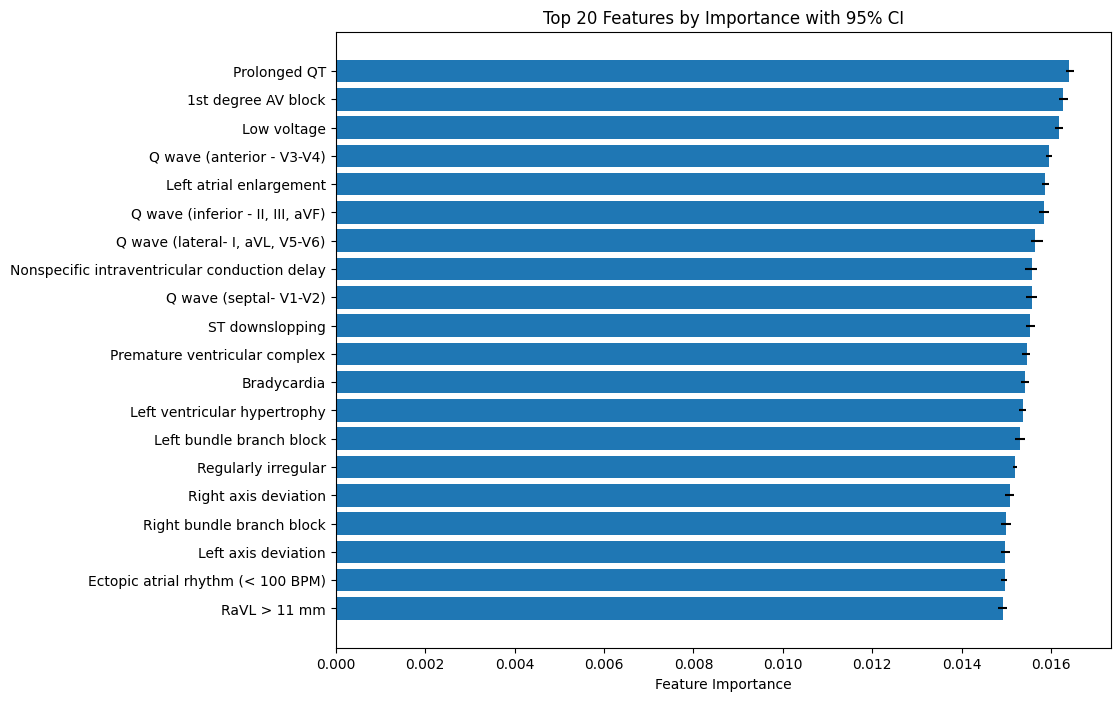

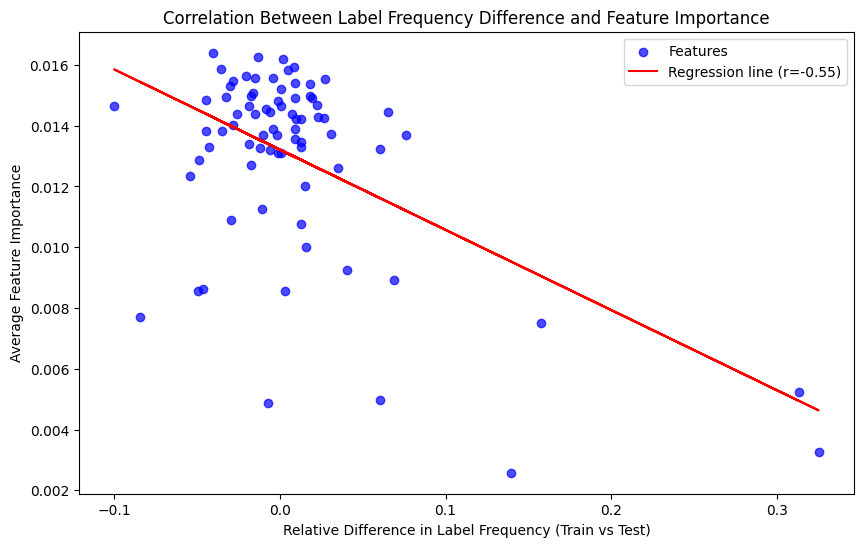

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score, balanced_accuracy_score
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.stats import linregress

# Predefined seeds for reproducibility
seeds = [42, 0, 7, 13, 21, 25, 31, 37, 51, 57]

# Define feature names based on the number of columns in train_probs
# This should match the number of labels or classes you have
feature_names = [f"feature_{i}" for i in range(train_probs.shape[1])]

# Function to train and evaluate the model for a given seed
def train_and_evaluate(seed):
    X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
        attack_data, attack_labels, test_size=0.2, random_state=seed
    )
    
    class_0_indices = np.where(y_test_attack == 0)[0]
    class_1_indices = np.where(y_test_attack == 1)[0]
    min_class_size = min(len(class_0_indices), len(class_1_indices))
    
    balanced_class_0_indices = np.random.choice(class_0_indices, min_class_size, replace=False)
    balanced_class_1_indices = np.random.choice(class_1_indices, min_class_size, replace=False)
    balanced_indices = np.concatenate([balanced_class_0_indices, balanced_class_1_indices])
    
    X_test_attack_balanced = X_test_attack[balanced_indices]
    y_test_attack_balanced = y_test_attack[balanced_indices]

    attack_model = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=seed)
    attack_model.fit(X_train_attack, y_train_attack)

    feature_importances = attack_model.feature_importances_

    attack_preds_proba = attack_model.predict_proba(X_test_attack_balanced)[:, 1]
    attack_preds = attack_model.predict(X_test_attack_balanced)

    auc = roc_auc_score(y_test_attack_balanced, attack_preds_proba)
    auprc = average_precision_score(y_test_attack_balanced, attack_preds_proba)
    accuracy = accuracy_score(y_test_attack_balanced, attack_preds)
    balanced_accuracy = balanced_accuracy_score(y_test_attack_balanced, attack_preds)
    f1 = f1_score(y_test_attack_balanced, attack_preds)
    
    return auc, auprc, accuracy, balanced_accuracy, f1, feature_importances

# Run iterations and collect results
results = Parallel(n_jobs=-1)(delayed(train_and_evaluate)(seed) for seed in tqdm(seeds, desc="Training iterations"))
auc_scores, auprc_scores, accuracy_scores, balanced_accuracy_scores, f1_scores, feature_importances_all = zip(*results)

def mean_and_ci(scores):
    mean_score = np.mean(scores)
    ci_lower, ci_upper = np.percentile(scores, [2.5, 97.5])
    return mean_score, (ci_lower, ci_upper)

metrics = {
    "AUC": mean_and_ci(auc_scores),
    "AUPRC": mean_and_ci(auprc_scores),
    "Accuracy": mean_and_ci(accuracy_scores),
    "Balanced Accuracy": mean_and_ci(balanced_accuracy_scores),
    "F1 Score": mean_and_ci(f1_scores)
}

for metric, (mean, ci) in metrics.items():
    print(f"{metric} - Mean: {mean:.4f}, 95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")

# Calculate mean feature importances

feature_importances_all = np.array(feature_importances_all)
mean_importances = np.mean(feature_importances_all, axis=0)
ci_importances = np.percentile(feature_importances_all, [2.5, 97.5], axis=0)
ci_lower = ci_importances[0]
ci_upper = ci_importances[1]

# Get top 20 features based on average importance
top_indices = np.argsort(mean_importances)[-20:][::-1]
top_features = [new_label_names[i] for i in top_indices]  # Use new_label_names for labels
top_mean_importances = mean_importances[top_indices]
top_ci_lower = ci_lower[top_indices]
top_ci_upper = ci_upper[top_indices]

# Plot top 20 features with confidence intervals
plt.figure(figsize=(10, 8))
plt.barh(top_features, top_mean_importances, xerr=[top_mean_importances - top_ci_lower, top_ci_upper - top_mean_importances], align='center')
plt.xlabel('Feature Importance')
plt.title('Top 20 Features by Importance with 95% CI')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.show()

# Calculate label frequencies in y_train and y_test
train_freq = np.mean(y_train, axis=0)
test_freq = np.mean(y_test, axis=0)

# Compute the relative difference in frequency
relative_diff = (train_freq - test_freq) / (train_freq)

# Scatter plot of relative difference in frequency vs feature importance
plt.figure(figsize=(10, 6))
plt.scatter(relative_diff, mean_importances, alpha=0.7, color="b", label="Features")

# Regression line
slope, intercept, r_value, p_value, std_err = linregress(relative_diff, mean_importances)
line = slope * relative_diff + intercept
plt.plot(relative_diff, line, 'r', label=f"Regression line (r={r_value:.2f})")

# Labels and title
plt.xlabel("Relative Difference in Label Frequency (Train vs Test)")
plt.ylabel("Average Feature Importance")
plt.title("Correlation Between Label Frequency Difference and Feature Importance")
plt.legend()
plt.show()

# PTB

In [12]:
X_test = np.load('/media/datasets/anolin/logits/PTB_77_labels/PTB_cleaned.npy').astype(np.float16)
y_test = np.load('/media/datasets/anolin/logits/PTB_77_labels/Y_ground.npy').astype(np.float16)
X_test = np.swapaxes(X_test, -2,-1)

train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float16), torch.tensor(y_train, dtype=torch.float16)), batch_size=512, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float16), torch.tensor(y_test, dtype=torch.float16)), batch_size=512, shuffle=False)
train_probs = get_predictions_multilabel(model, train_loader)
test_probs = get_predictions_multilabel(model, test_loader)

Getting Predictions: 100%|██████████| 43/43 [00:04<00:00,  9.67it/s]


In [13]:
# Example: Maximum confidence score across all labels
train_confidences = np.max(train_probs, axis=1)
test_confidences = np.max(test_probs, axis=1)

# Attack data preparation: Label train data as 1 (members) and test data as 0 (non-members)
attack_data = np.concatenate([train_probs, test_probs])
attack_labels = np.concatenate([np.ones(len(train_probs)), np.zeros(len(test_probs))])

Training iterations: 100%|██████████| 10/10 [00:00<00:00, 7445.95it/s]


AUC - Mean: 0.6813, 95% CI: [0.6700, 0.6928]
AUPRC - Mean: 0.6302, 95% CI: [0.6197, 0.6394]
Accuracy - Mean: 0.5006, 95% CI: [0.5003, 0.5009]
Balanced Accuracy - Mean: 0.5006, 95% CI: [0.5003, 0.5009]
F1 Score - Mean: 0.6669, 95% CI: [0.6668, 0.6671]


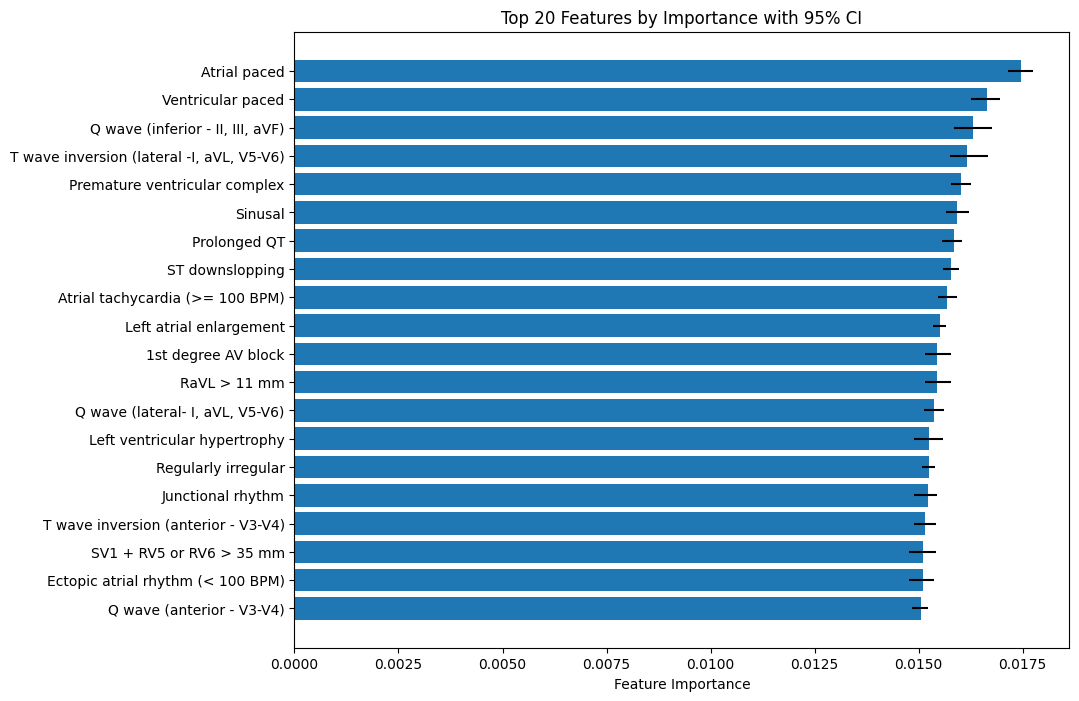

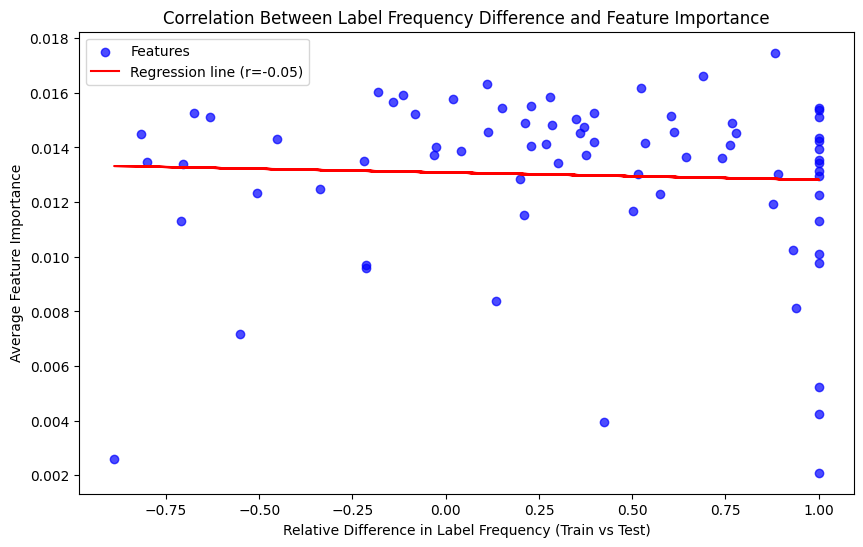

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score, balanced_accuracy_score
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.stats import linregress

# Predefined seeds for reproducibility
seeds = [42, 0, 7, 13, 21, 25, 31, 37, 51, 57]

# Define feature names based on the number of columns in train_probs
# This should match the number of labels or classes you have
feature_names = [f"feature_{i}" for i in range(train_probs.shape[1])]

# Function to train and evaluate the model for a given seed
def train_and_evaluate(seed):
    X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
        attack_data, attack_labels, test_size=0.2, random_state=seed
    )
    
    class_0_indices = np.where(y_test_attack == 0)[0]
    class_1_indices = np.where(y_test_attack == 1)[0]
    min_class_size = min(len(class_0_indices), len(class_1_indices))
    
    balanced_class_0_indices = np.random.choice(class_0_indices, min_class_size, replace=False)
    balanced_class_1_indices = np.random.choice(class_1_indices, min_class_size, replace=False)
    balanced_indices = np.concatenate([balanced_class_0_indices, balanced_class_1_indices])
    
    X_test_attack_balanced = X_test_attack[balanced_indices]
    y_test_attack_balanced = y_test_attack[balanced_indices]

    attack_model = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=seed)
    attack_model.fit(X_train_attack, y_train_attack)

    feature_importances = attack_model.feature_importances_

    attack_preds_proba = attack_model.predict_proba(X_test_attack_balanced)[:, 1]
    attack_preds = attack_model.predict(X_test_attack_balanced)

    auc = roc_auc_score(y_test_attack_balanced, attack_preds_proba)
    auprc = average_precision_score(y_test_attack_balanced, attack_preds_proba)
    accuracy = accuracy_score(y_test_attack_balanced, attack_preds)
    balanced_accuracy = balanced_accuracy_score(y_test_attack_balanced, attack_preds)
    f1 = f1_score(y_test_attack_balanced, attack_preds)
    
    return auc, auprc, accuracy, balanced_accuracy, f1, feature_importances

# Run iterations and collect results
results = Parallel(n_jobs=-1)(delayed(train_and_evaluate)(seed) for seed in tqdm(seeds, desc="Training iterations"))
auc_scores, auprc_scores, accuracy_scores, balanced_accuracy_scores, f1_scores, feature_importances_all = zip(*results)

def mean_and_ci(scores):
    mean_score = np.mean(scores)
    ci_lower, ci_upper = np.percentile(scores, [2.5, 97.5])
    return mean_score, (ci_lower, ci_upper)

metrics = {
    "AUC": mean_and_ci(auc_scores),
    "AUPRC": mean_and_ci(auprc_scores),
    "Accuracy": mean_and_ci(accuracy_scores),
    "Balanced Accuracy": mean_and_ci(balanced_accuracy_scores),
    "F1 Score": mean_and_ci(f1_scores)
}

for metric, (mean, ci) in metrics.items():
    print(f"{metric} - Mean: {mean:.4f}, 95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")

# Calculate mean feature importances
feature_importances_all = np.array(feature_importances_all)
mean_importances = np.mean(feature_importances_all, axis=0)
ci_importances = np.percentile(feature_importances_all, [2.5, 97.5], axis=0)
ci_lower = ci_importances[0]
ci_upper = ci_importances[1]

# Get top 20 features based on average importance
top_indices = np.argsort(mean_importances)[-20:][::-1]
top_features = [new_label_names[i] for i in top_indices]  # Use new_label_names for labels
top_mean_importances = mean_importances[top_indices]
top_ci_lower = ci_lower[top_indices]
top_ci_upper = ci_upper[top_indices]

# Plot top 20 features with confidence intervals
plt.figure(figsize=(10, 8))
plt.barh(top_features, top_mean_importances, xerr=[top_mean_importances - top_ci_lower, top_ci_upper - top_mean_importances], align='center')
plt.xlabel('Feature Importance')
plt.title('Top 20 Features by Importance with 95% CI')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.show()

# Calculate label frequencies in y_train and y_test
train_freq = np.mean(y_train, axis=0)
test_freq = np.mean(y_test, axis=0)

# Compute the relative difference in frequency
relative_diff = (train_freq - test_freq) / (train_freq)

# Scatter plot of relative difference in frequency vs feature importance
plt.figure(figsize=(10, 6))
plt.scatter(relative_diff, mean_importances, alpha=0.7, color="b", label="Features")

# Regression line
slope, intercept, r_value, p_value, std_err = linregress(relative_diff, mean_importances)
line = slope * relative_diff + intercept
plt.plot(relative_diff, line, 'r', label=f"Regression line (r={r_value:.2f})")

# Labels and title
plt.xlabel("Relative Difference in Label Frequency (Train vs Test)")
plt.ylabel("Average Feature Importance")
plt.title("Correlation Between Label Frequency Difference and Feature Importance")
plt.legend()
plt.show()

# MIMIC

Training iterations: 100%|██████████| 10/10 [00:00<00:00, 8774.69it/s]


AUC - Mean: 0.9757, 95% CI: [0.9751, 0.9763]
AUPRC - Mean: 0.9717, 95% CI: [0.9710, 0.9726]
Accuracy - Mean: 0.8855, 95% CI: [0.8841, 0.8871]
Balanced Accuracy - Mean: 0.8855, 95% CI: [0.8841, 0.8871]
F1 Score - Mean: 0.8955, 95% CI: [0.8944, 0.8968]


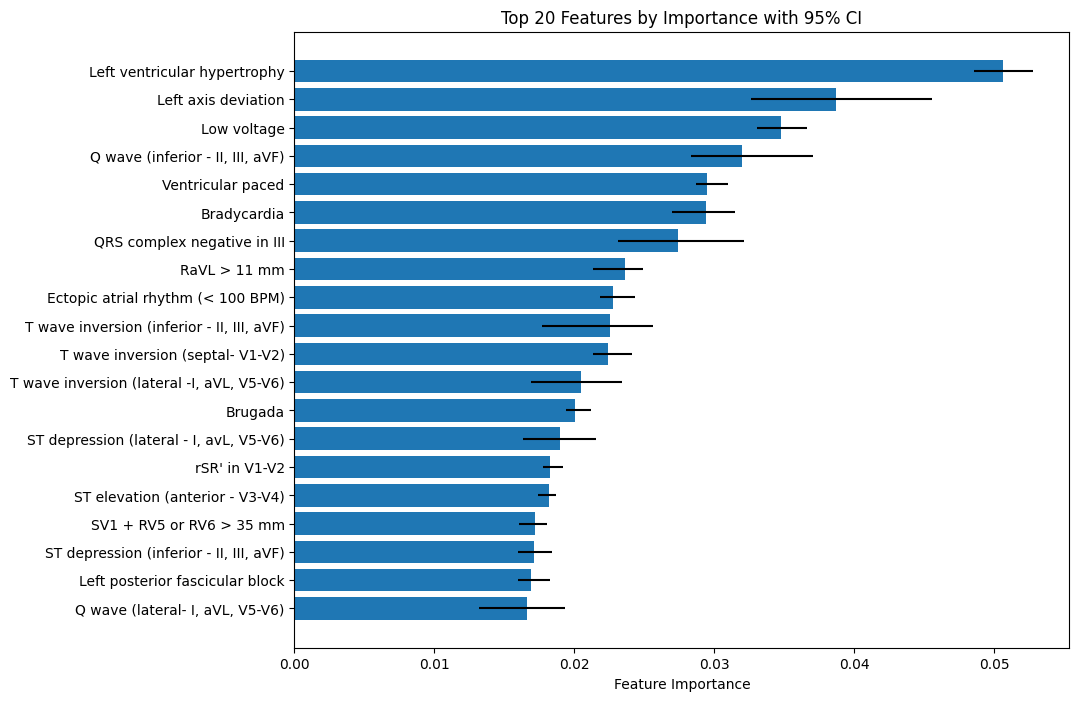

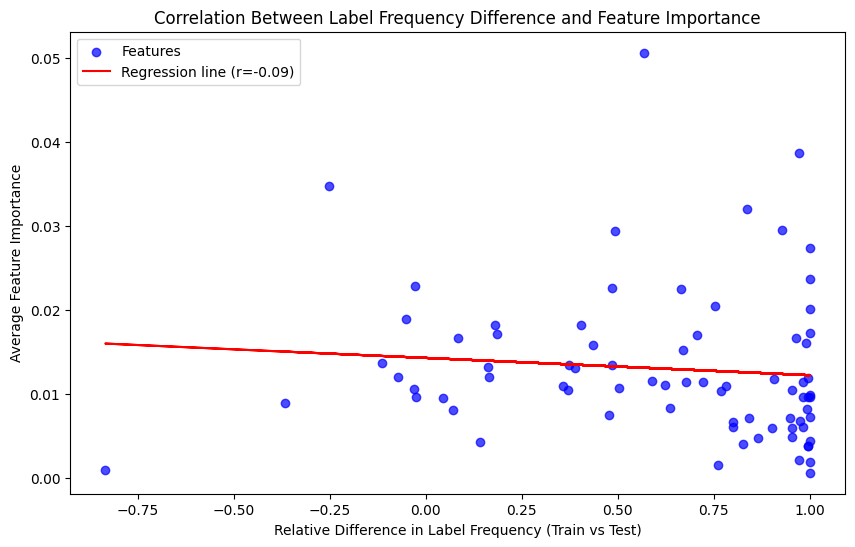

In [16]:
X_test = np.load('/media/datasets/anolin/logits/MIMIC_77_labels/MIMIC_cleaned.npy').astype(np.float16)
y_test = np.load('/media/datasets/anolin/logits/MIMIC_77_labels/Y_ground.npy').astype(np.float16)
X_test = np.swapaxes(X_test, -2,-1)

train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)), batch_size=512, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)), batch_size=512, shuffle=False)
train_probs = get_predictions_multilabel(model, train_loader)
test_probs = get_predictions_multilabel(model, test_loader)
# Example: Maximum confidence score across all labels
train_confidences = np.max(train_probs, axis=1)
test_confidences = np.max(test_probs, axis=1)

# Attack data preparation: Label train data as 1 (members) and test data as 0 (non-members)
attack_data = np.concatenate([train_probs, test_probs])
attack_labels = np.concatenate([np.ones(len(train_probs)), np.zeros(len(test_probs))])

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score, balanced_accuracy_score
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.stats import linregress

# Predefined seeds for reproducibility
seeds = [42, 0, 7, 13, 21, 25, 31, 37, 51, 57]

# Define feature names based on the number of columns in train_probs
# This should match the number of labels or classes you have
feature_names = [f"feature_{i}" for i in range(train_probs.shape[1])]

# Function to train and evaluate the model for a given seed
def train_and_evaluate(seed):
    X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
        attack_data, attack_labels, test_size=0.2, random_state=seed
    )
    
    class_0_indices = np.where(y_test_attack == 0)[0]
    class_1_indices = np.where(y_test_attack == 1)[0]
    min_class_size = min(len(class_0_indices), len(class_1_indices))
    
    balanced_class_0_indices = np.random.choice(class_0_indices, min_class_size, replace=False)
    balanced_class_1_indices = np.random.choice(class_1_indices, min_class_size, replace=False)
    balanced_indices = np.concatenate([balanced_class_0_indices, balanced_class_1_indices])
    
    X_test_attack_balanced = X_test_attack[balanced_indices]
    y_test_attack_balanced = y_test_attack[balanced_indices]

    attack_model = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=seed)
    attack_model.fit(X_train_attack, y_train_attack)

    feature_importances = attack_model.feature_importances_

    attack_preds_proba = attack_model.predict_proba(X_test_attack_balanced)[:, 1]
    attack_preds = attack_model.predict(X_test_attack_balanced)

    auc = roc_auc_score(y_test_attack_balanced, attack_preds_proba)
    auprc = average_precision_score(y_test_attack_balanced, attack_preds_proba)
    accuracy = accuracy_score(y_test_attack_balanced, attack_preds)
    balanced_accuracy = balanced_accuracy_score(y_test_attack_balanced, attack_preds)
    f1 = f1_score(y_test_attack_balanced, attack_preds)
    
    return auc, auprc, accuracy, balanced_accuracy, f1, feature_importances

# Run iterations and collect results
results = Parallel(n_jobs=-1)(delayed(train_and_evaluate)(seed) for seed in tqdm(seeds, desc="Training iterations"))
auc_scores, auprc_scores, accuracy_scores, balanced_accuracy_scores, f1_scores, feature_importances_all = zip(*results)

def mean_and_ci(scores):
    mean_score = np.mean(scores)
    ci_lower, ci_upper = np.percentile(scores, [2.5, 97.5])
    return mean_score, (ci_lower, ci_upper)

metrics = {
    "AUC": mean_and_ci(auc_scores),
    "AUPRC": mean_and_ci(auprc_scores),
    "Accuracy": mean_and_ci(accuracy_scores),
    "Balanced Accuracy": mean_and_ci(balanced_accuracy_scores),
    "F1 Score": mean_and_ci(f1_scores)
}

for metric, (mean, ci) in metrics.items():
    print(f"{metric} - Mean: {mean:.4f}, 95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")

# Calculate mean feature importances
feature_importances_all = np.array(feature_importances_all)
mean_importances = np.mean(feature_importances_all, axis=0)
ci_importances = np.percentile(feature_importances_all, [2.5, 97.5], axis=0)
ci_lower = ci_importances[0]
ci_upper = ci_importances[1]

# Get top 20 features based on average importance
top_indices = np.argsort(mean_importances)[-20:][::-1]
top_features = [new_label_names[i] for i in top_indices]  # Use new_label_names for labels
top_mean_importances = mean_importances[top_indices]
top_ci_lower = ci_lower[top_indices]
top_ci_upper = ci_upper[top_indices]

# Plot top 20 features with confidence intervals
plt.figure(figsize=(10, 8))
plt.barh(top_features, top_mean_importances, xerr=[top_mean_importances - top_ci_lower, top_ci_upper - top_mean_importances], align='center')
plt.xlabel('Feature Importance')
plt.title('Top 20 Features by Importance with 95% CI')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.show()

# Calculate label frequencies in y_train and y_test
train_freq = np.mean(y_train, axis=0)
test_freq = np.mean(y_test, axis=0)

# Compute the relative difference in frequency
relative_diff = (train_freq - test_freq) / (train_freq)

# Scatter plot of relative difference in frequency vs feature importance
plt.figure(figsize=(10, 6))
plt.scatter(relative_diff, mean_importances, alpha=0.7, color="b", label="Features")

# Regression line
slope, intercept, r_value, p_value, std_err = linregress(relative_diff, mean_importances)
line = slope * relative_diff + intercept
plt.plot(relative_diff, line, 'r', label=f"Regression line (r={r_value:.2f})")

# Labels and title
plt.xlabel("Relative Difference in Label Frequency (Train vs Test)")
plt.ylabel("Average Feature Importance")
plt.title("Correlation Between Label Frequency Difference and Feature Importance")
plt.legend()
plt.show()

# UKB

Training iterations: 100%|██████████| 10/10 [00:00<00:00, 5270.55it/s]


AUC - Mean: 0.9782, 95% CI: [0.9768, 0.9793]
AUPRC - Mean: 0.9691, 95% CI: [0.9673, 0.9706]
Accuracy - Mean: 0.7988, 95% CI: [0.7969, 0.8014]
Balanced Accuracy - Mean: 0.7988, 95% CI: [0.7969, 0.8014]
F1 Score - Mean: 0.8323, 95% CI: [0.8310, 0.8341]


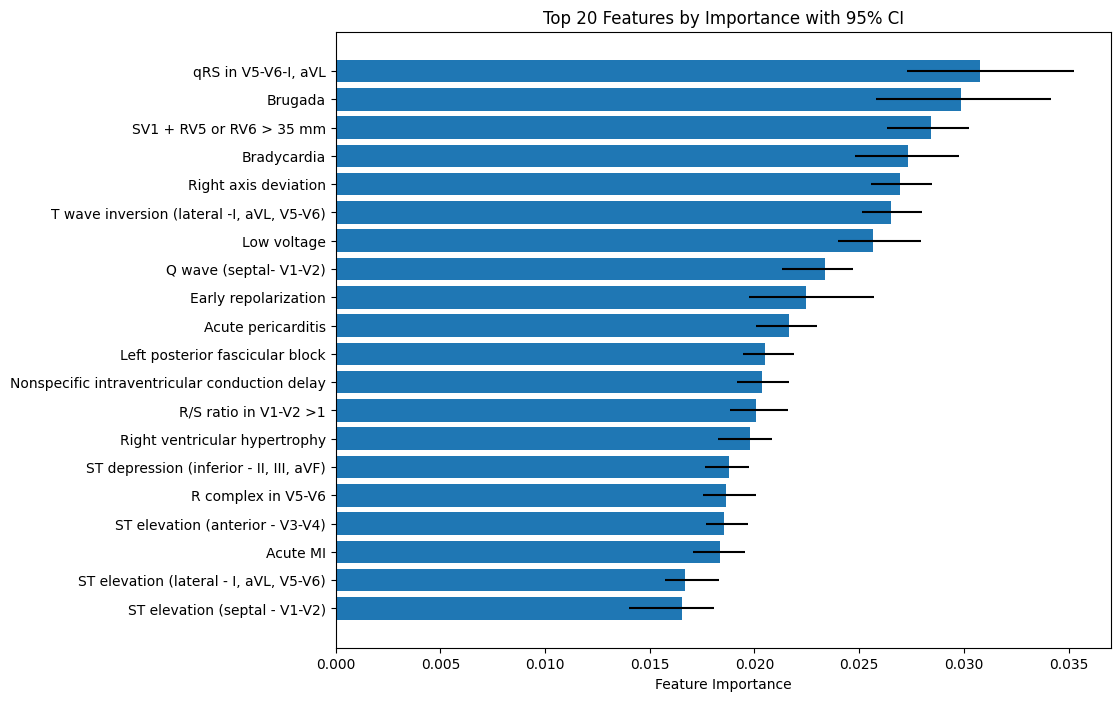

In [56]:
X_test = np.load('/media/datasets/anolin/logits/UKB_77_labels/ukb_data.npy').astype(np.float16)
y_test = np.load('/media/datasets/anolin/logits/UKB_77_labels/Y_ground.npy').astype(np.float16)
X_test = np.swapaxes(X_test, -2,-1)

train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)), batch_size=512, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)), batch_size=512, shuffle=False)
train_probs = get_predictions_multilabel(model, train_loader)
test_probs = get_predictions_multilabel(model, test_loader)
# Example: Maximum confidence score across all labels
train_confidences = np.max(train_probs, axis=1)
test_confidences = np.max(test_probs, axis=1)

# Attack data preparation: Label train data as 1 (members) and test data as 0 (non-members)
attack_data = np.concatenate([train_probs, test_probs])
attack_labels = np.concatenate([np.ones(len(train_probs)), np.zeros(len(test_probs))])

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score, balanced_accuracy_score
from tqdm import tqdm
from joblib import Parallel, delayed

# Predefined seeds for reproducibility
seeds = [42, 0, 7, 13, 21, 25, 31, 37, 51, 57]

# Define feature names based on the number of columns in train_probs
# This should match the number of labels or classes you have
feature_names = [f"feature_{i}" for i in range(train_probs.shape[1])]

# Function to train and evaluate the model for a given seed
def train_and_evaluate(seed):
    # Split the data (80% training, 20% testing) with different seeds
    X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
        attack_data, attack_labels, test_size=0.2, random_state=seed
    )
    
    # Ensure the test set is balanced
    class_0_indices = np.where(y_test_attack == 0)[0]
    class_1_indices = np.where(y_test_attack == 1)[0]
    min_class_size = min(len(class_0_indices), len(class_1_indices))
    
    # Subsample to balance the classes
    balanced_class_0_indices = np.random.choice(class_0_indices, min_class_size, replace=False)
    balanced_class_1_indices = np.random.choice(class_1_indices, min_class_size, replace=False)
    balanced_indices = np.concatenate([balanced_class_0_indices, balanced_class_1_indices])
    
    X_test_attack_balanced = X_test_attack[balanced_indices]
    y_test_attack_balanced = y_test_attack[balanced_indices]

    # Train the attack model with fewer estimators and parallel processing
    attack_model = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=seed)
    attack_model.fit(X_train_attack, y_train_attack)

    # Get feature importances
    feature_importances = attack_model.feature_importances_

    # Make predictions
    attack_preds_proba = attack_model.predict_proba(X_test_attack_balanced)[:, 1]
    attack_preds = attack_model.predict(X_test_attack_balanced)

    # Calculate metrics
    auc = roc_auc_score(y_test_attack_balanced, attack_preds_proba)
    auprc = average_precision_score(y_test_attack_balanced, attack_preds_proba)
    accuracy = accuracy_score(y_test_attack_balanced, attack_preds)
    balanced_accuracy = balanced_accuracy_score(y_test_attack_balanced, attack_preds)
    f1 = f1_score(y_test_attack_balanced, attack_preds)
    
    return auc, auprc, accuracy, balanced_accuracy, f1, feature_importances

# Run iterations in parallel and collect results
results = Parallel(n_jobs=-1)(delayed(train_and_evaluate)(seed) for seed in tqdm(seeds, desc="Training iterations"))

# Extract metrics and feature importances for each iteration
auc_scores, auprc_scores, accuracy_scores, balanced_accuracy_scores, f1_scores, feature_importances_all = zip(*results)

# Calculate mean and 95% CI for each metric
def mean_and_ci(scores):
    mean_score = np.mean(scores)
    ci_lower, ci_upper = np.percentile(scores, [2.5, 97.5])
    return mean_score, (ci_lower, ci_upper)

metrics = {
    "AUC": mean_and_ci(auc_scores),
    "AUPRC": mean_and_ci(auprc_scores),
    "Accuracy": mean_and_ci(accuracy_scores),
    "Balanced Accuracy": mean_and_ci(balanced_accuracy_scores),
    "F1 Score": mean_and_ci(f1_scores)
}

# Print results
for metric, (mean, ci) in metrics.items():
    print(f"{metric} - Mean: {mean:.4f}, 95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")


# Calculate mean and 95% CI for feature importances
feature_importances_all = np.array(feature_importances_all)
mean_importances = np.mean(feature_importances_all, axis=0)
ci_importances = np.percentile(feature_importances_all, [2.5, 97.5], axis=0)
ci_lower = ci_importances[0]
ci_upper = ci_importances[1]

# Get top 20 features based on average importance
top_indices = np.argsort(mean_importances)[-20:][::-1]
top_features = [new_label_names[i] for i in top_indices]  # Use new_label_names for labels
top_mean_importances = mean_importances[top_indices]
top_ci_lower = ci_lower[top_indices]
top_ci_upper = ci_upper[top_indices]

# Plot top 20 features with confidence intervals
plt.figure(figsize=(10, 8))
plt.barh(top_features, top_mean_importances, xerr=[top_mean_importances - top_ci_lower, top_ci_upper - top_mean_importances], align='center')
plt.xlabel('Feature Importance')
plt.title('Top 20 Features by Importance with 95% CI')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.show()

Demographic Parity per category macro: {'RHYTHM': 0.0037826895713806152, 'CONDUCTION': 0.0063334256410598755, 'CHAMBER ENLARGEMENT': 0.001928800716996193, 'PERICARDITIS': 0.004589153453707695, 'INFARCT, ISCHEMIA': 0.006329158321022987, 'OTHER': 0.005446769297122955}


Demographic Parity Permutation Test:   1%|          | 6/1000 [00:00<01:09, 14.21it/s]

Demographic Parity Permutation Test: 100%|██████████| 1000/1000 [01:10<00:00, 14.17it/s]


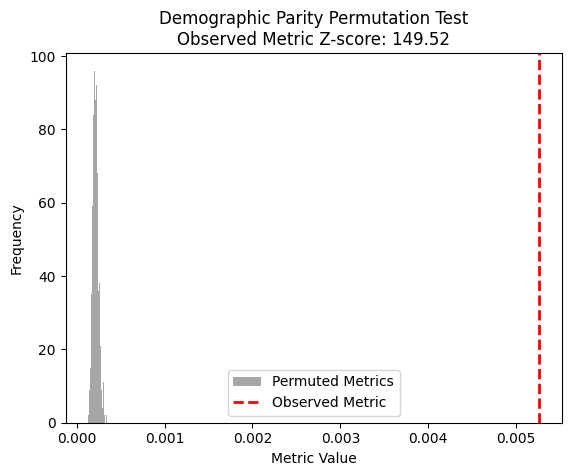

Demographic Parity is considered unfair (Observed Metric > Mean + 2*STD). Z-score: 149.52
Observed Demographic Parity: 0.005261361598968506


Demographic Parity Bootstrap Resampling: 100%|██████████| 1000/1000 [01:51<00:00,  9.00it/s]


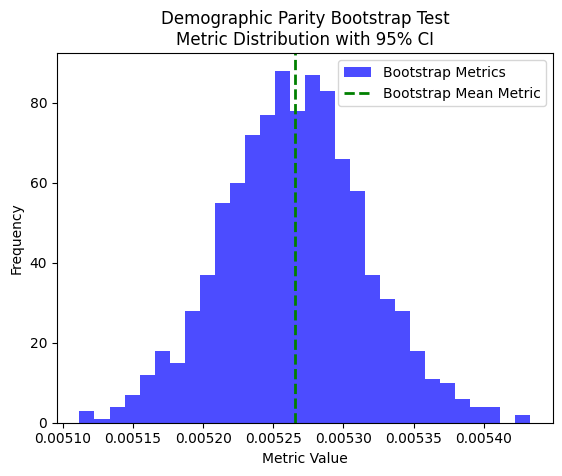

Bootstrap Demographic Parity: 0.0053 (95% CI: 0.0052, 0.0054)
Predictive Parity per category macro: {'RHYTHM': 0.01602935791015625, 'CONDUCTION': 0.021980881690979004, 'CHAMBER ENLARGEMENT': 0.0306546688079834, 'PERICARDITIS': 0.028087973594665527, 'INFARCT, ISCHEMIA': 0.023075193166732788, 'OTHER': 0.021739184856414795}


Predictive Parity Permutation Test: 100%|██████████| 1000/1000 [02:54<00:00,  5.74it/s]


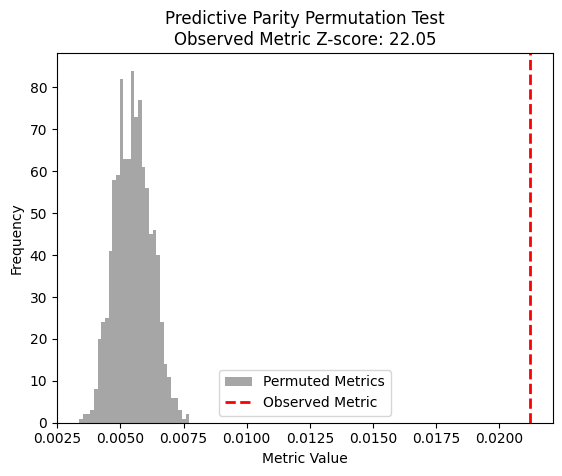

Predictive Parity is considered unfair (Observed Metric > Mean + 2*STD). Z-score: 22.05
Observed Predictive Parity: 0.021231532096862793


Predictive Parity Bootstrap Resampling:  18%|█▊        | 183/1000 [00:54<04:05,  3.33it/s]


KeyboardInterrupt: 

In [27]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

def permutation_test_fairness(predictions, labels, protected_attributes, metric_fn, n_permutations=1000, metric_name="Fairness Metric", categories_dict=None):
    """
    Perform a permutation test to assess the statistical significance of a fairness metric.
    
    Args:
        predictions (np.ndarray): Array of model predictions (N, num_labels).
        labels (np.ndarray): Array of true labels (N, num_labels).
        protected_attributes (np.ndarray): Array of protected attribute values (N,).
        metric_fn (function): The fairness metric function to evaluate (e.g., demographic_parity).
        n_permutations (int): Number of permutations to perform.
        metric_name (str): Name of the fairness metric for plotting.
        categories_dict (dict): Dictionary of categories for metacategory analysis.
    
    Returns:
        float: Observed metric value.
        float: Number of standard deviations the observed metric is from the mean of the permuted metrics.
    """
    observed_metric = metric_fn(predictions, labels, protected_attributes)
    permuted_metrics = []

    for _ in tqdm(range(n_permutations), desc=f"{metric_name} Permutation Test"):
        permuted_attributes = np.random.permutation(protected_attributes)
        permuted_metric = metric_fn(predictions, labels, permuted_attributes)
        permuted_metrics.append(permuted_metric)
    
    permuted_metrics = np.array(permuted_metrics)
    mean_permuted = np.mean(permuted_metrics)
    std_permuted = np.std(permuted_metrics)
    
    z_score = (observed_metric - mean_permuted) / std_permuted
    
    plt.hist(permuted_metrics, bins=30, alpha=0.7, label='Permuted Metrics', color='gray')
    plt.axvline(observed_metric, color='r', linestyle='dashed', linewidth=2, label='Observed Metric')
    plt.title(f'{metric_name} Permutation Test\nObserved Metric Z-score: {z_score:.2f}')
    plt.xlabel('Metric Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    if observed_metric <= mean_permuted + 2 * std_permuted:
        print(f"{metric_name} is considered fair (Observed Metric ≤ Mean + 2*STD). Z-score: {z_score:.2f}")
    else:
        print(f"{metric_name} is considered unfair (Observed Metric > Mean + 2*STD). Z-score: {z_score:.2f}")
    
    return observed_metric, z_score

def bootstrap_fairness(predictions, labels, protected_attributes, metric_fn, n_bootstraps=1000, alpha=0.05, metric_name="Fairness Metric", categories_dict=None):
    """
    Perform bootstrap resampling to assess the statistical significance of a fairness metric.
    
    Args:
        predictions (np.ndarray): Array of model predictions (N, num_labels).
        labels (np.ndarray): Array of true labels (N, num_labels).
        protected_attributes (np.ndarray): Array of protected attribute values (N,).
        metric_fn (function): The fairness metric function to evaluate (e.g., demographic_parity).
        n_bootstraps (int): Number of bootstrap resamples to perform.
        alpha (float): Significance level for confidence intervals.
        metric_name (str): Name of the fairness metric for plotting.
        categories_dict (dict): Dictionary of categories for metacategory analysis.
    
    Returns:
        float: The observed metric.
        tuple: Confidence interval (lower bound, upper bound).
    """
    metrics = []
    n_samples = predictions.shape[0]

    for _ in tqdm(range(n_bootstraps), desc=f"{metric_name} Bootstrap Resampling"):
        indices = np.random.choice(np.arange(n_samples), size=n_samples, replace=True)
        bootstrap_metric = metric_fn(predictions[indices], labels[indices] if labels is not None else None, protected_attributes[indices])
        metrics.append(bootstrap_metric)
    
    metrics = np.array(metrics)
    lower_bound = np.percentile(metrics, alpha/2*100)
    upper_bound = np.percentile(metrics, (1-alpha/2)*100)
    
    plt.hist(metrics, bins=30, alpha=0.7, label='Bootstrap Metrics', color='blue')
    plt.axvline(np.mean(metrics), color='green', linestyle='dashed', linewidth=2, label='Bootstrap Mean Metric')
    plt.title(f'{metric_name} Bootstrap Test\nMetric Distribution with 95% CI')
    plt.xlabel('Metric Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    return np.mean(metrics), lower_bound, upper_bound

# Convert categorical data to numerical codes if necessary
protected_attributes = metadata_adjusted['RestingECG_PatientDemographics_Gender']

if protected_attributes.dtype == 'object' or pd.api.types.is_categorical_dtype(protected_attributes):
    protected_attributes = pd.Categorical(protected_attributes).codes

# Now proceed with the calculation
dp_results = demographic_parity(Y_pred, protected_attributes, average='macro', categories_dict=categories, column_names=new_label_names)
print("Demographic Parity per category macro:", dp_results)

# Permutation test for Demographic Parity
observed_dp, z_score_dp = permutation_test_fairness(Y_pred, None, protected_attributes, lambda p, l, a: demographic_parity(p, a), metric_name="Demographic Parity")
print("Observed Demographic Parity:", observed_dp)

# Bootstrap for Demographic Parity
mean_dp, lower_ci_dp, upper_ci_dp = bootstrap_fairness(Y_pred, None, protected_attributes, lambda p, l, a: demographic_parity(p, a), metric_name="Demographic Parity")
print(f"Bootstrap Demographic Parity: {mean_dp:.4f} (95% CI: {lower_ci_dp:.4f}, {upper_ci_dp:.4f})")

# Predictive Parity (Equalized Odds)
eo_results = predictive_parity(Y_pred, Y_eval, protected_attributes, average='macro', categories_dict=categories, column_names=new_label_names)
print("Predictive Parity per category macro:", eo_results)

# Permutation test for Predictive Parity
observed_eo, z_score_eo = permutation_test_fairness(Y_pred, Y_eval, protected_attributes, lambda p, l, a: predictive_parity(p, l, a), metric_name="Predictive Parity")
print("Observed Predictive Parity:", observed_eo)

# Bootstrap for Predictive Parity
mean_eo, lower_ci_eo, upper_ci_eo = bootstrap_fairness(Y_pred, Y_eval, protected_attributes, lambda p, l, a: predictive_parity(p, l, a), metric_name="Predictive Parity")
print(f"Bootstrap Predictive Parity: {mean_eo:.4f} (95% CI: {lower_ci_eo:.4f}, {upper_ci_eo:.4f})")

Demographic Parity per category macro: {'RHYTHM': 0.0037826895713806152, 'CONDUCTION': 0.0063334256410598755, 'CHAMBER ENLARGEMENT': 0.001928800716996193, 'PERICARDITIS': 0.004589153453707695, 'INFARCT, ISCHEMIA': 0.006329158321022987, 'OTHER': 0.005446769297122955}


Demographic Parity Permutation Test:  42%|████▏     | 424/1000 [00:32<00:43, 13.32it/s]

Demographic Parity Permutation Test: 100%|██████████| 1000/1000 [01:15<00:00, 13.22it/s]


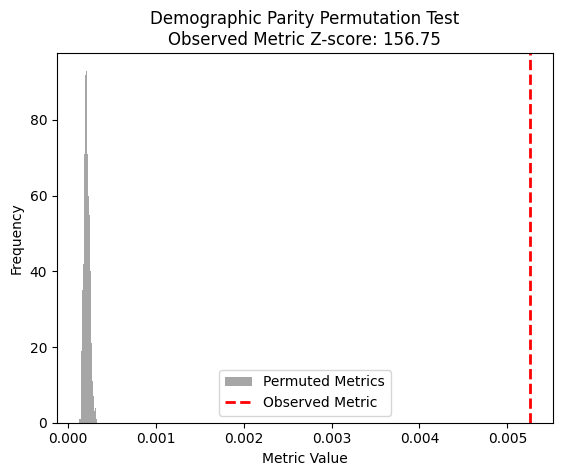

Demographic Parity is considered unfair (Observed Metric > Mean + 2*STD). Z-score: 156.75
Observed Demographic Parity: 0.005261361598968506


Demographic Parity Bootstrap Resampling: 100%|██████████| 1000/1000 [01:51<00:00,  8.95it/s]


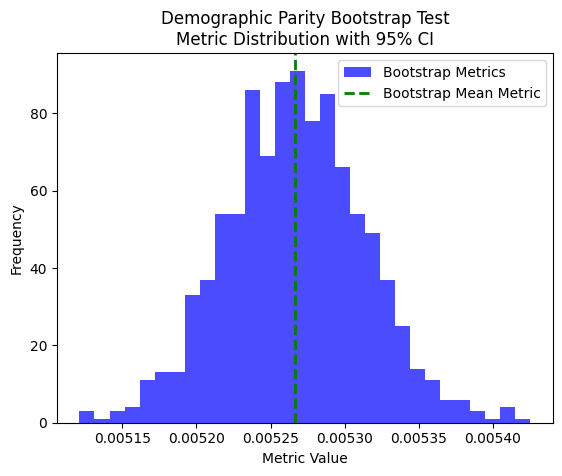

Bootstrap Demographic Parity: 0.0053 (95% CI: 0.0052, 0.0054)
Predictive Parity per category macro: {'RHYTHM': 0.01602935791015625, 'CONDUCTION': 0.021980881690979004, 'CHAMBER ENLARGEMENT': 0.0306546688079834, 'PERICARDITIS': 0.028087973594665527, 'INFARCT, ISCHEMIA': 0.023075193166732788, 'OTHER': 0.021739184856414795}


Predictive Parity Permutation Test: 100%|██████████| 1000/1000 [03:09<00:00,  5.27it/s]


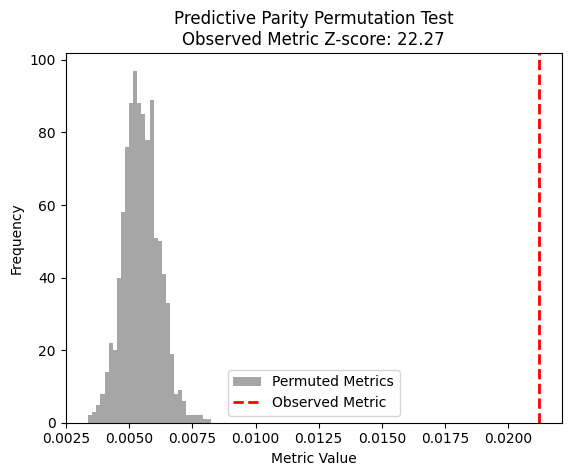

Predictive Parity is considered unfair (Observed Metric > Mean + 2*STD). Z-score: 22.27
Observed Predictive Parity: 0.021231532096862793


Predictive Parity Bootstrap Resampling: 100%|██████████| 1000/1000 [05:21<00:00,  3.11it/s]


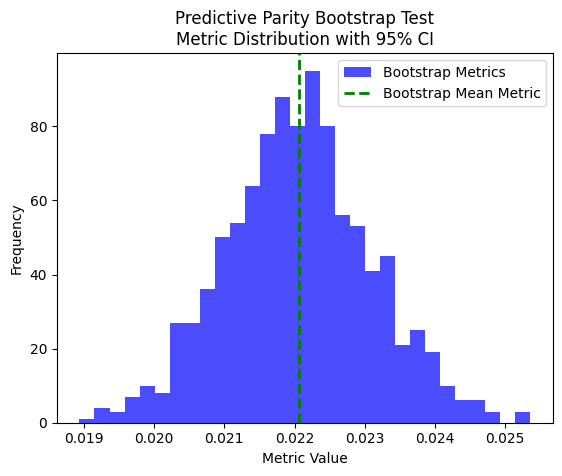

Bootstrap Predictive Parity: 0.0221 (95% CI: 0.0200, 0.0241)


In [18]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

def permutation_test_fairness(predictions, labels, protected_attributes, metric_fn, n_permutations=1000, metric_name="Fairness Metric", categories_dict=None):
    """
    Perform a permutation test to assess the statistical significance of a fairness metric.
    
    Args:
        predictions (np.ndarray): Array of model predictions (N, num_labels).
        labels (np.ndarray): Array of true labels (N, num_labels).
        protected_attributes (np.ndarray): Array of protected attribute values (N,).
        metric_fn (function): The fairness metric function to evaluate (e.g., demographic_parity).
        n_permutations (int): Number of permutations to perform.
        metric_name (str): Name of the fairness metric for plotting.
        categories_dict (dict): Dictionary of categories for metacategory analysis.
    
    Returns:
        float: Observed metric value.
        float: Number of standard deviations the observed metric is from the mean of the permuted metrics.
    """
    observed_metric = metric_fn(predictions, labels, protected_attributes)
    permuted_metrics = []

    for _ in tqdm(range(n_permutations), desc=f"{metric_name} Permutation Test"):
        permuted_attributes = np.random.permutation(protected_attributes)
        permuted_metric = metric_fn(predictions, labels, permuted_attributes)
        permuted_metrics.append(permuted_metric)
    
    permuted_metrics = np.array(permuted_metrics)
    mean_permuted = np.mean(permuted_metrics)
    std_permuted = np.std(permuted_metrics)
    
    z_score = (observed_metric - mean_permuted) / std_permuted
    
    plt.hist(permuted_metrics, bins=30, alpha=0.7, label='Permuted Metrics', color='gray')
    plt.axvline(observed_metric, color='r', linestyle='dashed', linewidth=2, label='Observed Metric')
    plt.title(f'{metric_name} Permutation Test\nObserved Metric Z-score: {z_score:.2f}')
    plt.xlabel('Metric Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    if observed_metric <= mean_permuted + 2 * std_permuted:
        print(f"{metric_name} is considered fair (Observed Metric ≤ Mean + 2*STD). Z-score: {z_score:.2f}")
    else:
        print(f"{metric_name} is considered unfair (Observed Metric > Mean + 2*STD). Z-score: {z_score:.2f}")
    
    return observed_metric, z_score

def bootstrap_fairness(predictions, labels, protected_attributes, metric_fn, n_bootstraps=1000, alpha=0.05, metric_name="Fairness Metric", categories_dict=None):
    """
    Perform bootstrap resampling to assess the statistical significance of a fairness metric.
    
    Args:
        predictions (np.ndarray): Array of model predictions (N, num_labels).
        labels (np.ndarray): Array of true labels (N, num_labels).
        protected_attributes (np.ndarray): Array of protected attribute values (N,).
        metric_fn (function): The fairness metric function to evaluate (e.g., demographic_parity).
        n_bootstraps (int): Number of bootstrap resamples to perform.
        alpha (float): Significance level for confidence intervals.
        metric_name (str): Name of the fairness metric for plotting.
        categories_dict (dict): Dictionary of categories for metacategory analysis.
    
    Returns:
        float: The observed metric.
        tuple: Confidence interval (lower bound, upper bound).
    """
    metrics = []
    n_samples = predictions.shape[0]

    for _ in tqdm(range(n_bootstraps), desc=f"{metric_name} Bootstrap Resampling"):
        indices = np.random.choice(np.arange(n_samples), size=n_samples, replace=True)
        bootstrap_metric = metric_fn(predictions[indices], labels[indices] if labels is not None else None, protected_attributes[indices])
        metrics.append(bootstrap_metric)
    
    metrics = np.array(metrics)
    lower_bound = np.percentile(metrics, alpha/2*100)
    upper_bound = np.percentile(metrics, (1-alpha/2)*100)
    
    plt.hist(metrics, bins=30, alpha=0.7, label='Bootstrap Metrics', color='blue')
    plt.axvline(np.mean(metrics), color='green', linestyle='dashed', linewidth=2, label='Bootstrap Mean Metric')
    plt.title(f'{metric_name} Bootstrap Test\nMetric Distribution with 95% CI')
    plt.xlabel('Metric Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    return np.mean(metrics), lower_bound, upper_bound

# Convert categorical data to numerical codes if necessary
protected_attributes = metadata_adjusted['RestingECG_PatientDemographics_Gender']

if protected_attributes.dtype == 'object' or pd.api.types.is_categorical_dtype(protected_attributes):
    protected_attributes = pd.Categorical(protected_attributes).codes

# Now proceed with the calculation
dp_results = demographic_parity(Y_pred, protected_attributes, average='macro', categories_dict=categories, column_names=new_label_names)
print("Demographic Parity per category macro:", dp_results)

# Permutation test for Demographic Parity
observed_dp, z_score_dp = permutation_test_fairness(Y_pred, None, protected_attributes, lambda p, l, a: demographic_parity(p, a), metric_name="Demographic Parity")
print("Observed Demographic Parity:", observed_dp)

# Bootstrap for Demographic Parity
mean_dp, lower_ci_dp, upper_ci_dp = bootstrap_fairness(Y_pred, None, protected_attributes, lambda p, l, a: demographic_parity(p, a), metric_name="Demographic Parity")
print(f"Bootstrap Demographic Parity: {mean_dp:.4f} (95% CI: {lower_ci_dp:.4f}, {upper_ci_dp:.4f})")

# Predictive Parity (Equalized Odds)
eo_results = predictive_parity(Y_pred, Y_eval, protected_attributes, average='macro', categories_dict=categories, column_names=new_label_names)
print("Predictive Parity per category macro:", eo_results)

# Permutation test for Predictive Parity
observed_eo, z_score_eo = permutation_test_fairness(Y_pred, Y_eval, protected_attributes, lambda p, l, a: predictive_parity(p, l, a), metric_name="Predictive Parity")
print("Observed Predictive Parity:", observed_eo)

# Bootstrap for Predictive Parity
mean_eo, lower_ci_eo, upper_ci_eo = bootstrap_fairness(Y_pred, Y_eval, protected_attributes, lambda p, l, a: predictive_parity(p, l, a), metric_name="Predictive Parity")
print(f"Bootstrap Predictive Parity: {mean_eo:.4f} (95% CI: {lower_ci_eo:.4f}, {upper_ci_eo:.4f})")

# AGE

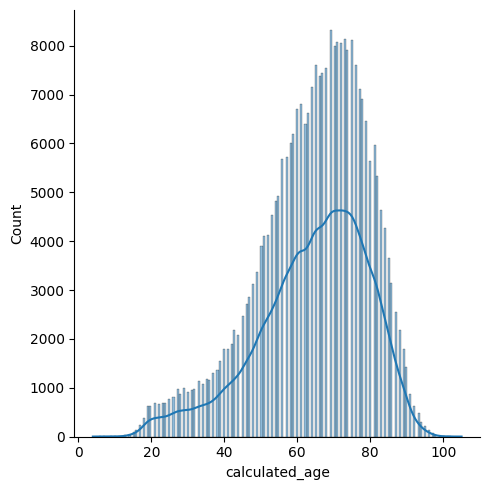

In [19]:
import seaborn as sns
sns.displot(data=metadata_adjusted, x="calculated_age", kde=True)


In [20]:
# Calculate the 1st and 3rd quartiles
first_quartile = metadata_adjusted['calculated_age'].quantile(0.25)
third_quartile = metadata_adjusted['calculated_age'].quantile(0.75)

first_quartile, third_quartile

(56.0, 75.0)

In [47]:
protected_attributes = []
for age in metadata_adjusted['calculated_age']:
    if age <= 55:
        protected_attributes.append(0)
    if age > 55 and age <= 75:
        protected_attributes.append(1)
    if age > 75:
        protected_attributes.append(2)


In [48]:

metadata_adjusted['age_bined'] = protected_attributes
protected_attributes = metadata_adjusted['age_bined']


Demographic Parity per category macro: {'RHYTHM': 0.0288068950176239, 'CONDUCTION': 0.01274765282869339, 'CHAMBER ENLARGEMENT': 0.005640972405672073, 'PERICARDITIS': 0.004044459201395512, 'INFARCT, ISCHEMIA': 0.004696445539593697, 'OTHER': 0.014127388596534729}


Demographic Parity Permutation Test: 100%|██████████| 1000/1000 [01:24<00:00, 11.90it/s]


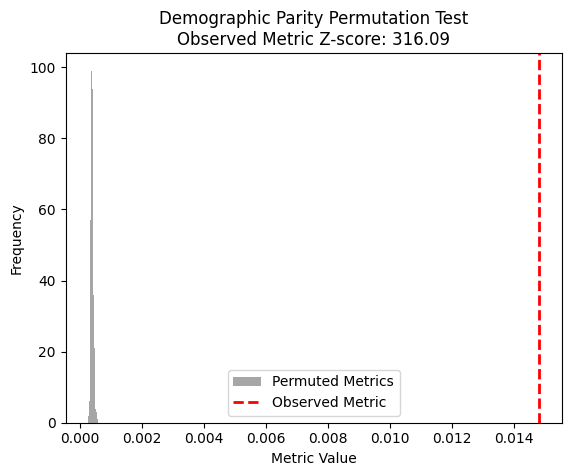

Demographic Parity is considered unfair (Observed Metric > Mean + 2*STD). Z-score: 316.09
Observed Demographic Parity: 0.014807909727096558


Demographic Parity Bootstrap Resampling: 100%|██████████| 1000/1000 [02:04<00:00,  8.02it/s]


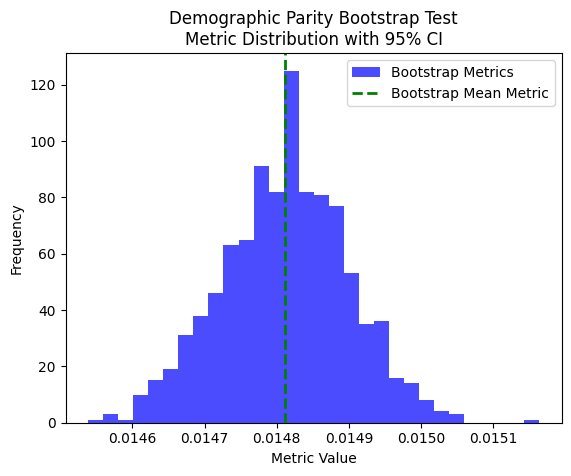

Bootstrap Demographic Parity: 0.0148 (95% CI: 0.0146, 0.0150)
Predictive Parity per category macro: {'RHYTHM': 0.05705296993255615, 'CONDUCTION': 0.05001169443130493, 'CHAMBER ENLARGEMENT': 0.10213696956634521, 'PERICARDITIS': 0.020493268966674805, 'INFARCT, ISCHEMIA': 0.0326555073261261, 'OTHER': 0.03743371367454529}


Predictive Parity Permutation Test: 100%|██████████| 1000/1000 [03:28<00:00,  4.81it/s]


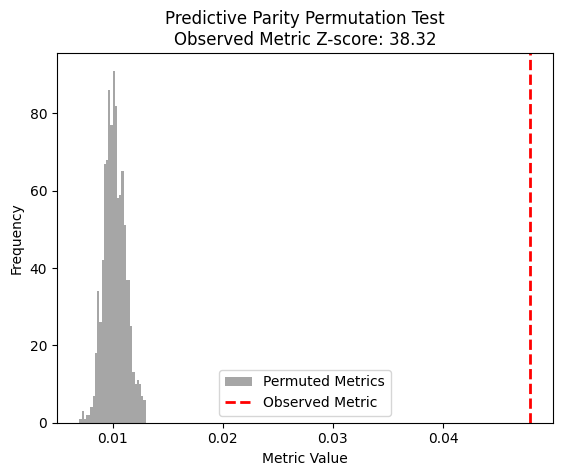

Predictive Parity is considered unfair (Observed Metric > Mean + 2*STD). Z-score: 38.32
Observed Predictive Parity: 0.0479339063167572


Predictive Parity Bootstrap Resampling: 100%|██████████| 1000/1000 [05:34<00:00,  2.99it/s]


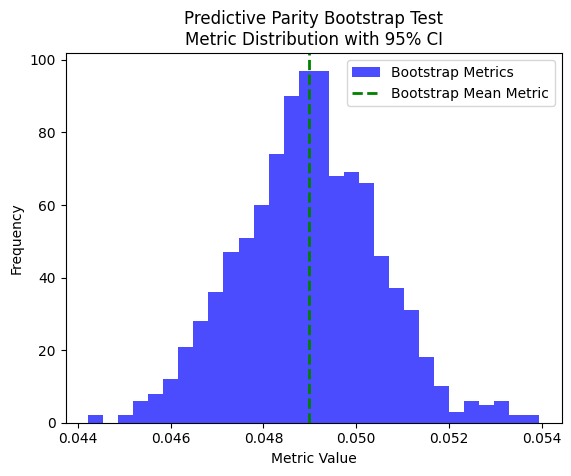

Bootstrap Predictive Parity: 0.0490 (95% CI: 0.0460, 0.0520)


In [29]:
if protected_attributes.dtype == 'object' or pd.api.types.is_categorical_dtype(protected_attributes):
    protected_attributes = pd.Categorical(protected_attributes).codes

# Now proceed with the calculation
dp_results = demographic_parity(Y_pred, protected_attributes, average='macro', categories_dict=categories, column_names=new_label_names)
print("Demographic Parity per category macro:", dp_results)

# Permutation test for Demographic Parity
observed_dp, z_score_dp = permutation_test_fairness(Y_pred, None, protected_attributes, lambda p, l, a: demographic_parity(p, a), metric_name="Demographic Parity")
print("Observed Demographic Parity:", observed_dp)


# Ensure protected_attributes is clean and compatible for the metric function
protected_attributes = np.array(protected_attributes, dtype=float)
protected_attributes = torch.tensor(protected_attributes, dtype=torch.float32)

# Assuming `demographic_parity` is a function that only requires predictions and protected_attributes
mean_dp, lower_ci_dp, upper_ci_dp = bootstrap_fairness(
    Y_pred,
    None,  # Labels are None
    protected_attributes,
    lambda p, l, a: demographic_parity(p, a),  # Adjusted lambda to accept 3 arguments
    metric_name="Demographic Parity"
)

print(f"Bootstrap Demographic Parity: {mean_dp:.4f} (95% CI: {lower_ci_dp:.4f}, {upper_ci_dp:.4f})")

# Predictive Parity (Equalized Odds)
eo_results = predictive_parity(Y_pred, Y_eval, protected_attributes, average='macro', categories_dict=categories, column_names=new_label_names)
print("Predictive Parity per category macro:", eo_results)

# Permutation test for Predictive Parity
observed_eo, z_score_eo = permutation_test_fairness(Y_pred, Y_eval, protected_attributes, lambda p, l, a: predictive_parity(p, l, a), metric_name="Predictive Parity")
print("Observed Predictive Parity:", observed_eo)


# Ensure protected_attributes is clean and compatible for the metric function
protected_attributes = np.array(protected_attributes, dtype=float)
protected_attributes = torch.tensor(protected_attributes, dtype=torch.float32)
# Bootstrap for Predictive Parity
mean_eo, lower_ci_eo, upper_ci_eo = bootstrap_fairness(Y_pred, Y_eval, protected_attributes, lambda p, l, a: predictive_parity(p, l, a), metric_name="Predictive Parity")
print(f"Bootstrap Predictive Parity: {mean_eo:.4f} (95% CI: {lower_ci_eo:.4f}, {upper_ci_eo:.4f})")

Demographic Parity per category macro: {'RHYTHM': 0.03460855782032013, 'CONDUCTION': 0.018310973420739174, 'CHAMBER ENLARGEMENT': 0.023635582998394966, 'PERICARDITIS': 0.005132107529789209, 'INFARCT, ISCHEMIA': 0.016845840960741043, 'OTHER': 0.03471413999795914}


Demographic Parity Permutation Test: 100%|██████████| 1000/1000 [01:31<00:00, 10.98it/s]


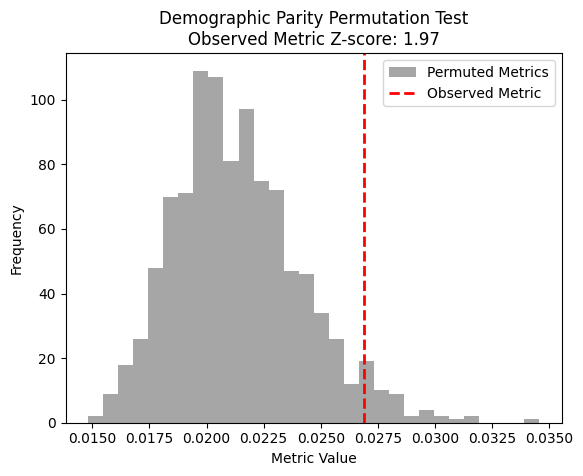

Demographic Parity is considered fair (Observed Metric ≤ Mean + 2*STD). Z-score: 1.97
Observed Demographic Parity: 0.02689296007156372


Demographic Parity Bootstrap Resampling: 100%|██████████| 1000/1000 [02:14<00:00,  7.44it/s]


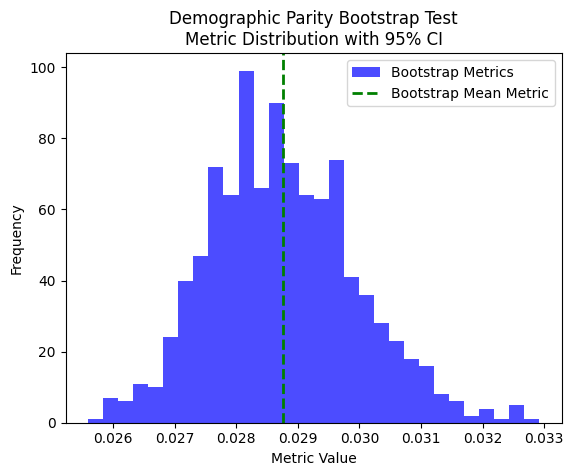

Bootstrap Demographic Parity: 0.0288 (95% CI: 0.0266, 0.0313)
Predictive Parity per category macro: {'RHYTHM': 0.28725767135620117, 'CONDUCTION': 0.33156144618988037, 'CHAMBER ENLARGEMENT': 0.28990381956100464, 'PERICARDITIS': 0.23373772203922272, 'INFARCT, ISCHEMIA': 0.3353206217288971, 'OTHER': 0.37204059958457947}


Predictive Parity Permutation Test: 100%|██████████| 1000/1000 [03:40<00:00,  4.54it/s]


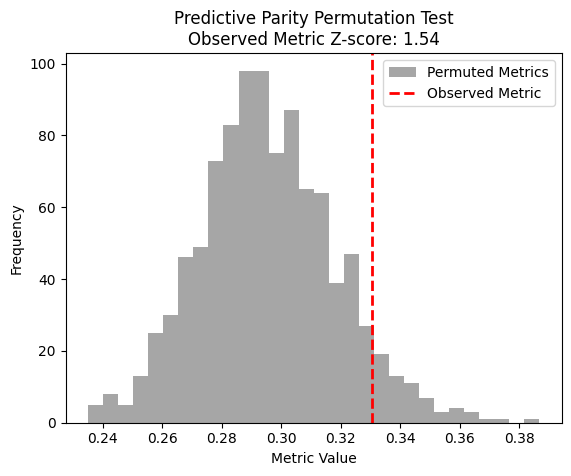

Predictive Parity is considered fair (Observed Metric ≤ Mean + 2*STD). Z-score: 1.54
Observed Predictive Parity: 0.33070042729377747


Predictive Parity Bootstrap Resampling: 100%|██████████| 1000/1000 [05:33<00:00,  3.00it/s]


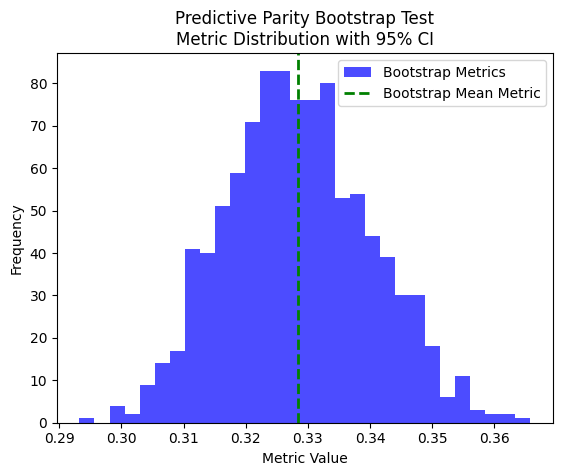

Bootstrap Predictive Parity: 0.3284 (95% CI: 0.3070, 0.3509)


In [32]:
protected_attributes = metadata_adjusted['processed_race']

if protected_attributes.dtype == 'object' or pd.api.types.is_categorical_dtype(protected_attributes):
    protected_attributes = pd.Categorical(protected_attributes).codes

# Now proceed with the calculation
dp_results = demographic_parity(Y_pred, protected_attributes, average='macro', categories_dict=categories, column_names=new_label_names)
print("Demographic Parity per category macro:", dp_results)

# Permutation test for Demographic Parity
observed_dp, z_score_dp = permutation_test_fairness(Y_pred, None, protected_attributes, lambda p, l, a: demographic_parity(p, a), metric_name="Demographic Parity")
print("Observed Demographic Parity:", observed_dp)


# Ensure protected_attributes is clean and compatible for the metric function
protected_attributes = np.array(protected_attributes, dtype=float)
protected_attributes = torch.tensor(protected_attributes, dtype=torch.float32)

# Assuming `demographic_parity` is a function that only requires predictions and protected_attributes
mean_dp, lower_ci_dp, upper_ci_dp = bootstrap_fairness(
    Y_pred,
    None,  # Labels are None
    protected_attributes,
    lambda p, l, a: demographic_parity(p, a),  # Adjusted lambda to accept 3 arguments
    metric_name="Demographic Parity"
)

print(f"Bootstrap Demographic Parity: {mean_dp:.4f} (95% CI: {lower_ci_dp:.4f}, {upper_ci_dp:.4f})")

# Predictive Parity (Equalized Odds)
eo_results = predictive_parity(Y_pred, Y_eval, protected_attributes, average='macro', categories_dict=categories, column_names=new_label_names)
print("Predictive Parity per category macro:", eo_results)

# Permutation test for Predictive Parity
observed_eo, z_score_eo = permutation_test_fairness(Y_pred, Y_eval, protected_attributes, lambda p, l, a: predictive_parity(p, l, a), metric_name="Predictive Parity")
print("Observed Predictive Parity:", observed_eo)


# Ensure protected_attributes is clean and compatible for the metric function
protected_attributes = np.array(protected_attributes, dtype=float)
protected_attributes = torch.tensor(protected_attributes, dtype=torch.float32)
# Bootstrap for Predictive Parity
mean_eo, lower_ci_eo, upper_ci_eo = bootstrap_fairness(Y_pred, Y_eval, protected_attributes, lambda p, l, a: predictive_parity(p, l, a), metric_name="Predictive Parity")
print(f"Bootstrap Predictive Parity: {mean_eo:.4f} (95% CI: {lower_ci_eo:.4f}, {upper_ci_eo:.4f})")

# inference attack

In [16]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [17]:
X_test = np.load('/media/datasets/anolin/benchmark2/X_test_v1.2.npy').astype(np.float16)
X_test = np.swapaxes(X_test, -2,-1)
y_test = np.load('/media/datasets/anolin/benchmark2/Y_test_v1.2.npy').astype(np.float16)

In [20]:
list_clean_labels = ['Sinusal','Regular','Monomorph','QS complex in V1-V2-V3','R complex in V5-V6','T wave inversion (inferior - II, III, aVF)','Left bundle branch block','RaVL > 11 mm','SV1 + RV5 or RV6 > 35 mm','T wave inversion (lateral -I, aVL, V5-V6)','T wave inversion (anterior - V3-V4)','Left axis deviation','Left ventricular hypertrophy','Bradycardia','Q wave (inferior - II, III, aVF)','Afib','Irregularly irregular','Atrial tachycardia (>= 100 BPM)','Nonspecific intraventricular conduction delay','Premature ventricular complex','Polymorph','T wave inversion (septal- V1-V2)','Right bundle branch block','Ventricular paced','ST elevation (anterior - V3-V4)','ST elevation (septal - V1-V2)','1st degree AV block','Premature atrial complex','Atrial flutter',"rSR' in V1-V2",'qRS in V5-V6-I, aVL','Left anterior fascicular block','Right axis deviation','2nd degree AV block - mobitz 1','ST depression (inferior - II, III, aVF)','Acute pericarditis','ST elevation (inferior - II, III, aVF)','Low voltage','Regularly irregular','Bifid','Junctional rhythm','Left atrial enlargement','ST elevation (lateral - I, aVL, V5-V6)','Atrial paced','Right ventricular hypertrophy','Delta wave','Wolff-Parkinson-White (Pre-excitation syndrome)','Prolonged QT','ST depression (anterior - V3-V4)','QRS complex negative in III','RaVL + SV3 > 28 mm (H) or 20 mm (F)','Q wave (lateral- I, aVL, V5-V6)','Hyperacute T wave (lateral, V5-V6)','Hyperacute T wave (septal, V1-V2)','Supraventricular tachycardia','ST downslopping','ST depression (lateral - I, avL, V5-V6)','2nd degree AV block - mobitz 2','U wave','ST depression et T inversion in V5 or V6','Large >0.08 s','R/S ratio in V1-V2 >1','RV1 + SV6\xa0> 11 mm','Left posterior fascicular block','Right atrial enlargement','ST depression (septal- V1-V2)','Q wave (septal- V1-V2)','Q wave (anterior - V3-V4)','Hyperacute T wave (anterior, V3-V4)','ST upslopping','Right superior axis','Auricular bigeminy','Ventricular tachycardia','ST elevation (posterior - V7-V8-V9)','Ectopic atrial rhythm (< 100 BPM)','Lead misplacement','Biphasic','Ventricular bigeminy','J wave','Tall >2.5 mm','Third Degree AV Block','Sinus Pause','Acute MI','Early repolarization','Q wave (posterior - V7-V9)','Bi-atrial enlargement','LV pacing','Dextrocardia','Brugada','Ventricular Rhythm','ST depression (posterior - V7-V8-V9)','no_qrs']
labels_to_remove = ['ST depression (posterior - V7-V8-V9)','Tall >2.5 mm', 'J wave', 'Auricular bigeminy', 'Ventricular bigeminy', 'Sinus Pause', 'Dextrocardia', 'Hyperacute T wave (lateral, V5-V6)', 'Hyperacute T wave (septal, V1-V2)', 'Hyperacute T wave (anterior, V3-V4)', 'Bifid', 'RaVL + SV3 > 28 mm (H) or 20 mm (F)', 'Large >0.08 s', 'Biphasic', 'ST depression et T inversion in V5 or V6']

pos_to_drop = list()
new_label_names = list()
for pos, item in enumerate(list_clean_labels):
    if item in labels_to_remove:
        pos_to_drop.append(pos)
    else:
        new_label_names.append(item)

y_test = np.delete(y_test, pos_to_drop, axis=1)
y_train = np.delete(y_train, pos_to_drop, axis=1)
print(y_train.shape)

(287039, 77)


In [18]:
X_train = np.load('/media/datasets/anolin/benchmark2/X_train_v1.1.npy').astype(np.float16)
X_train = np.swapaxes(X_train, -2,-1)
y_train = np.load('/media/datasets/anolin/benchmark2/Y_train_v1.1.npy').astype(np.float16)

In [21]:
y_train = np.delete(y_train, pos_to_drop, axis=1)
print(y_train.shape)

(1017719, 77)


In [22]:
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)), batch_size=254, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)), batch_size=254, shuffle=False)

In [23]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def get_predictions_multilabel(model, loader):
    model.eval()  # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    all_probs = []

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for data, _ in tqdm(loader, desc="Getting Predictions"):
            inputs = data.to(device)
            inputs = inputs.float()

            logits = model(inputs)
            probs = torch.sigmoid(logits)  # Convert logits to probabilities
            all_probs.append(probs.cpu())  # Move probabilities to CPU

    # Concatenate all collected probabilities and convert to numpy array
    all_probs = torch.cat(all_probs).numpy()
    
    return all_probs

In [24]:
train_probs = get_predictions_multilabel(model, train_loader)
test_probs = get_predictions_multilabel(model, test_loader)

Getting Predictions:   0%|          | 1/4007 [00:00<12:47,  5.22it/s]

Getting Predictions: 100%|██████████| 1131/1131 [01:42<00:00, 10.99it/s]


In [25]:
# Example: Maximum confidence score across all labels
train_confidences = np.max(train_probs, axis=1)
test_confidences = np.max(test_probs, axis=1)

# Attack data preparation: Label train data as 1 (members) and test data as 0 (non-members)
attack_data = np.concatenate([train_confidences, test_confidences])
attack_labels = np.concatenate([np.ones(len(train_confidences)), np.zeros(len(test_confidences))])

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Split the attack data into training and testing sets for the attack model
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(attack_data.reshape(-1, 1), attack_labels, test_size=0.5, random_state=42)

# Train an attack model (e.g., a RandomForest)
attack_model = RandomForestClassifier(n_estimators=100)
attack_model.fit(X_train_attack, y_train_attack)

# Evaluate the attack model
attack_preds = attack_model.predict_proba(X_test_attack)[:, 1]
attack_auc = roc_auc_score(y_test_attack, attack_preds)
print(f'Membership Inference Attack AUC: {attack_auc:.4f}')

Membership Inference Attack AUC: 0.5008


Membership Inference Attack AUC: 0.5006


Performing Permutation Test: 100%|██████████| 1000/1000 [02:08<00:00,  7.78it/s]


Observed AUC: 0.5006
P-value from permutation test: 0.1790


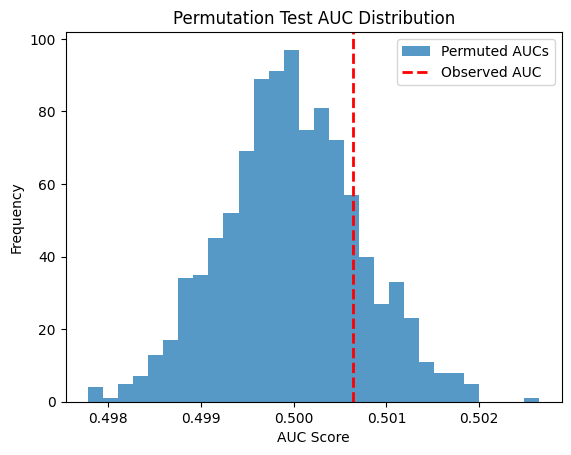

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# Assuming attack_data and attack_labels are already defined

# Split the attack data into training and testing sets for the attack model
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(attack_data.reshape(-1, 1), attack_labels, test_size=0.5, random_state=42)

# Train an attack model (e.g., a RandomForest)
attack_model = RandomForestClassifier(n_estimators=100)
attack_model.fit(X_train_attack, y_train_attack)

# Evaluate the attack model
attack_preds = attack_model.predict_proba(X_test_attack)[:, 1]
observed_auc = roc_auc_score(y_test_attack, attack_preds)
print(f'Membership Inference Attack AUC: {observed_auc:.4f}')

# Perform permutation test
def permutation_test_auc(attack_model, X_test_attack, y_test_attack, n_permutations=1000):
    # Compute the observed AUC score
    attack_preds = attack_model.predict_proba(X_test_attack)[:, 1]

    # Generate the permutation distribution
    permuted_aucs = []
    for _ in tqdm(range(n_permutations), desc="Performing Permutation Test"):
        y_permuted = np.random.permutation(y_test_attack)
        permuted_auc = roc_auc_score(y_permuted, attack_preds)
        permuted_aucs.append(permuted_auc)
    
    # Calculate the p-value
    permuted_aucs = np.array(permuted_aucs)
    p_value = np.mean(permuted_aucs >= observed_auc)

    return observed_auc, permuted_aucs, p_value

# Run the permutation test
observed_auc, permuted_aucs, p_value = permutation_test_auc(attack_model, X_test_attack, y_test_attack, n_permutations=1000)

print(f"Observed AUC: {observed_auc:.4f}")
print(f"P-value from permutation test: {p_value:.4f}")

# Optionally, plot the distribution of permuted AUCs
plt.hist(permuted_aucs, bins=30, alpha=0.75, label='Permuted AUCs')
plt.axvline(observed_auc, color='red', linestyle='dashed', linewidth=2, label='Observed AUC')
plt.title('Permutation Test AUC Distribution')
plt.xlabel('AUC Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Ethnicity

In [17]:
data_MHI = pd.read_parquet('/media/datasets/anolin/fine_tuning/merged_df_MHI_test.parquet')
data_MHI

index                                           npy_path  \
8           142  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
39          221  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
40          222  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
41          223  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
62          594  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
...         ...                                                ...   
206186  1290906  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
206254  1296316  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
206255  1296315  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
206279  1297353  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
206280  1297356  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   

       new_PatientID date_of_birth  calculated_age  \
8            0000138    01-26-1949              62   
39           0000166    05-30-1932              72   
40           0000166    05-30-1932              73   
41           0000166    05-30-1932              76   
62           0000440    05-17-1964              43   
...              ...           ...             ...   
206186       0538861    10-08-1944              73   
206254       0541064    05-16-1943              74   
206255       0541064    05-16-1943              75   
206279       0541500    12-13-1956              61   
206280       0541500    12-13-1956              61   

       RestingECG_PatientDemographics_Gender  \
8                                     FEMALE   
39                                      MALE   
40                                      MALE   
41                                      MALE   
62                                    FEMALE   
...                                      ...   
206186                                FEMALE   
206254                                  MALE   
206255                                  MALE   
206279                                  MALE   
206280                                  MALE   

       RestingECG_TestDemographics_Priority  \
8                                    NORMAL   
39                                   NORMAL   
40                                   NORMAL   
41                                   NORMAL   
62                                   NORMAL   
...                                     ...   
206186                               NORMAL   
206254                               NORMAL   
206255                               NORMAL   
206279                               NORMAL   
206280                               NORMAL   

       RestingECG_TestDemographics_Location  \
8                                        25   
39                                        1   
40                                        1   
41                                        1   
62                                        2   
...                                     ...   
206186                                   51   
206254                                   52   
206255                                   15   
206279                                   32   
206280                                   51   

       RestingECG_TestDemographics_LocationName  \
8                                 25_PRE-EFFORT   
39                       1_CARDIOLOGIE GENERALE   
40                       1_CARDIOLOGIE GENERALE   
41                       1_CARDIOLOGIE GENERALE   
62                   2_CLINIQUE DES CONGENITAUX   
...                                         ...   
206186                           5 COURT-SEJOUR   
206254                                    5 EST   
206255            15_CL PREV. CARDIOVASC (EPIC)   
206279                                    3 EST   
206280                           5 COURT-SEJOUR   

       RestingECG_PatientDemographics_Race      AFR  SAS      EAS      EUR  \
8                                  UNKNOWN  0.00000  0.0  0.00000  1.00000   
39                               CAUCASIAN  

In [18]:
X_MHI = np.load("/media/datasets/anolin/fine_tuning/test_X_MHI_genetic.npy")
X_MHI.shape

(40404, 2500, 12)

In [19]:
Y_MHI = data_MHI[new_label_names].to_numpy()
Y_MHI.shape

(40404, 77)

In [20]:
eval_set = CustomDataset(X_MHI, Y_MHI)
eval_generator = torch.utils.data.DataLoader(eval_set, **val_params)

In [21]:

logits = test_model(model, eval_generator)
sigmoid_v = np.vectorize(sigmoid)
Y_pred = sigmoid_v(logits)

Testing: 100%|██████████| 186/186 [00:08<00:00, 20.92it/s]


In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

# Define Demographic Parity function
def demographic_parity(predictions, protected_attributes, average='micro', categories_dict=None, column_names=None):
    """
    Calculate Demographic Parity for a multilabel classification model across multiple groups.
    
    Args:
        predictions (np.ndarray): Array of model predictions (N, num_labels) with binary values.
        protected_attributes (np.ndarray): Array of protected attribute values (N,) (can be multiple groups).
        average (str): 'micro' or 'macro' averaging.
        categories_dict (dict): Dictionary mapping categories to lists of label names (optional).
        column_names (list): List of column names corresponding to the order in predictions (optional).

    Returns:
        float or dict: Average Demographic Parity difference using specified averaging method, either overall or per category.
    """
    # Convert inputs to PyTorch tensors
    predictions = torch.tensor(predictions, dtype=torch.float32)
    protected_attributes = torch.tensor(protected_attributes, dtype=torch.float32)
    
    # Filter out entries where protected_attributes is None (NaN in numpy)
    valid_mask = ~torch.isnan(protected_attributes)
    predictions = predictions[valid_mask]
    protected_attributes = protected_attributes[valid_mask]

    unique_groups = torch.unique(protected_attributes)
    group_probs = []

    for group in unique_groups:
        group_prob = predictions[protected_attributes == group].float().mean(dim=0)
        group_probs.append(group_prob)

    # Check if group_probs is empty before stacking
    if len(group_probs) == 0:
        raise ValueError("No valid groups found for Demographic Parity calculation. Check group definitions or input data.")

    group_probs = torch.stack(group_probs)  # Shape: (num_groups, num_labels)
    
    if average == 'micro':
        avg_diff = torch.mean(torch.mean(group_probs, dim=1)) - torch.mean(torch.min(group_probs, dim=1)[0])
    elif average == 'macro':
        avg_diff = torch.mean(torch.mean(group_probs, dim=0)) - torch.mean(torch.min(group_probs, dim=0)[0])
    else:
        raise ValueError("average must be 'micro' or 'macro'")

    return avg_diff.item()

# Define Predictive Parity function
def predictive_parity(predictions, labels, protected_attributes, average='macro', categories_dict=None, column_names=None):
    """
    Calculate Predictive Parity for a multilabel classification model across multiple groups.
    
    Args:
        predictions (np.ndarray): Array of model predictions (N, num_labels) with binary values.
        labels (np.ndarray): Array of true labels (N, num_labels).
        protected_attributes (np.ndarray): Array of protected attribute values (N,) (can be multiple groups).
        average (str): 'micro' or 'macro' averaging.
        categories_dict (dict): Dictionary mapping categories to lists of label names (optional).
        column_names (list): List of column names corresponding to the order in predictions (optional).

    Returns:
        float or dict: Average Predictive Parity difference using specified averaging method, either overall or per category.
    """
    predictions = torch.tensor(predictions, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32)
    protected_attributes = torch.tensor(protected_attributes, dtype=torch.float32)
    
    # Filter out entries where protected_attributes is None (NaN in numpy)
    valid_mask = ~torch.isnan(protected_attributes)
    predictions = predictions[valid_mask]
    labels = labels[valid_mask]
    protected_attributes = protected_attributes[valid_mask]

    unique_groups = torch.unique(protected_attributes)
    group_ppvs = []

    for group in unique_groups:
        group_mask = protected_attributes == group
        tp = (predictions[group_mask] * labels[group_mask]).sum(dim=0)  # True Positives
        predicted_positive = predictions[group_mask].sum(dim=0)  # Predicted Positives
        if predicted_positive.sum() == 0:
            continue
        ppv = tp / (predicted_positive + 1e-8)  # Precision (PPV)
        group_ppvs.append(ppv)

    # Check if group_ppvs is empty before stacking
    if len(group_ppvs) == 0:
        raise ValueError("No valid predictions to calculate Predictive Parity. Check group definitions or input data.")

    group_ppvs = torch.stack(group_ppvs)  # Shape: (num_groups, num_labels)

    if average == 'micro':
        avg_diff = torch.mean(torch.mean(group_ppvs, dim=1)) - torch.mean(torch.min(group_ppvs, dim=1)[0])
    elif average == 'macro':
        avg_diff = torch.mean(torch.mean(group_ppvs, dim=0)) - torch.mean(torch.min(group_ppvs, dim=0)[0])
    else:
        raise ValueError("average must be 'micro' or 'macro'")

    return avg_diff.item()

# Integrated bootstrapping test function for both metrics
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

# Define the integrated bootstrapping test and plotting function with tqdm
def bootstrap_fairness_test(predictions, protected_attributes, labels=None, metric_func=None, n_iterations=1000, average='micro', include_groups=None, title=None):
    """
    Perform a bootstrapping test to evaluate fairness metrics and visualize the results.

    Args:
        predictions (np.ndarray): Model predictions (N, num_labels).
        protected_attributes (np.ndarray): Array of protected attribute values (N,).
        labels (np.ndarray, optional): True labels (N, num_labels) (only required for predictive parity).
        metric_func (function, optional): Function to calculate fairness metric. Defaults to demographic_parity.
        n_iterations (int): Number of bootstrap iterations.
        average (str): Averaging method ('micro' or 'macro').
        include_groups (list, optional): List of specific groups in `protected_attributes` to consider. Defaults to None.
        title (str, optional): Custom title for the plot. If None, a default title is used.

    Returns:
        float: Z-score of the actual value against the bootstrapped distribution.
        list: List of bootstrapped metric values.
        float: Actual metric value.
    """
    # Convert object or categorical protected attributes to numerical codes
    if protected_attributes.dtype == 'object' or pd.api.types.is_categorical_dtype(protected_attributes):
        # Store the original categories for reference
        original_categories = pd.Categorical(protected_attributes).categories
        # Convert to numerical codes
        protected_attributes = pd.Categorical(protected_attributes).codes

        # If include_groups is provided, map it to the corresponding numerical codes
        if include_groups is not None:
            include_groups = [list(original_categories).index(group) for group in include_groups if group in original_categories]

    # Filter the data based on include_groups if specified
    if include_groups is not None:
        # Create a mask for rows that belong to the specified groups
        include_mask = np.isin(protected_attributes, include_groups)
        predictions = predictions[include_mask]
        protected_attributes = protected_attributes[include_mask]
        if labels is not None:
            labels = labels[include_mask]

    # Default to demographic_parity if no metric function is provided
    if metric_func is None:
        metric_func = demographic_parity

    # Calculate the actual metric value using the specified or default function
    if callable(metric_func) and 'demographic' in metric_func.__name__:
        actual_value = metric_func(predictions, protected_attributes, average=average)
    elif callable(metric_func):
        actual_value = metric_func(predictions, labels, protected_attributes, average=average)
    else:
        raise ValueError("Invalid metric function provided. Please pass the actual function, not a string.")

    # Store the bootstrapped values
    bootstrapped_values = []

    # Perform bootstrapping with a progress bar
    for _ in tqdm(range(n_iterations), desc='Bootstrapping...'):
        # Randomly sample indices with replacement
        indices = np.random.choice(range(predictions.shape[0]), size=predictions.shape[0], replace=True)
        sampled_predictions = predictions[indices]
        sampled_labels = labels[indices] if labels is not None else None
        sampled_attributes = protected_attributes[indices]

        # Calculate the metric for the sampled data
        if 'demographic' in metric_func.__name__:
            bootstrapped_value = metric_func(sampled_predictions, sampled_attributes, average=average)
        else:
            bootstrapped_value = metric_func(sampled_predictions, sampled_labels, sampled_attributes, average=average)
        
        bootstrapped_values.append(bootstrapped_value)

    # Convert to numpy array
    bootstrapped_values = np.array(bootstrapped_values)

    # Calculate mean and standard deviation of the bootstrapped distribution
    mean_bootstrap = np.mean(bootstrapped_values)
    std_bootstrap = np.std(bootstrapped_values)

    # Calculate the z-score for the actual value
    z_score = (actual_value - mean_bootstrap) / std_bootstrap

    # Determine the title
    if title is None:
        title = f"Bootstrap Distribution of {metric_func.__name__.replace('_', ' ').title()} (Z-score: {z_score:.3f})"
    else:
        title = f"{title} (Z-score: {z_score:.3f})"

    # Plot the bootstrapped distribution and the actual value with z-score in the title
    plt.figure(figsize=(10, 6))
    sns.histplot(bootstrapped_values, bins=30, kde=True, color='skyblue')
    plt.axvline(actual_value, color='red', linestyle='--', label=f'Actual Value: {actual_value:.3f}')
    plt.title(title)
    plt.xlabel('Metric Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    return z_score, bootstrapped_values, actual_value

In [23]:
data_MHI['RestingECG_PatientDemographics_Race'].value_counts()

CAUCASIAN           28093
UNKNOWN             10074
BLACK                 879
ORIENTAL              127
HISPANIC              104
ASIAN                 104
PACIFIC ISLANDER        8
AMERICAN INDIAN         3
Name: RestingECG_PatientDemographics_Race, dtype: int64

Bootstrapping...:   0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrapping...: 100%|██████████| 1000/1000 [00:12<00:00, 81.07it/s]


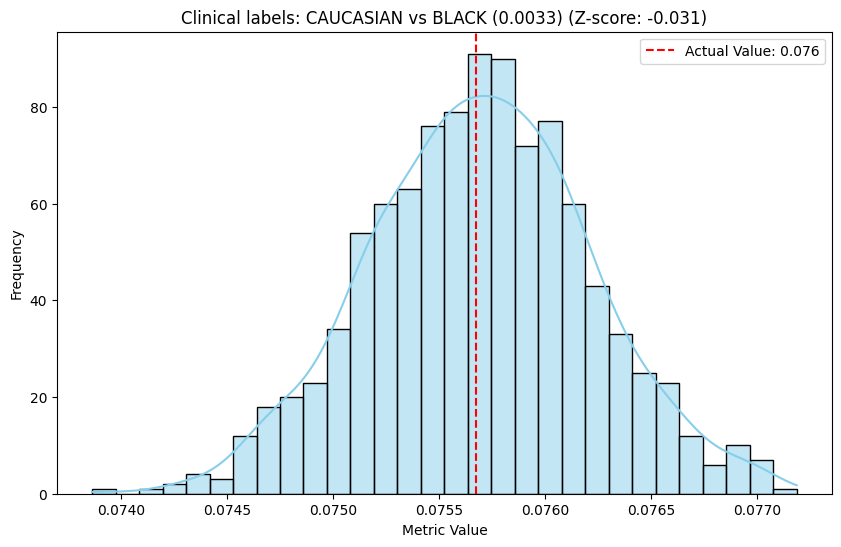

Z-score: -0.031
0.07567354291677475


In [24]:
protected_attributes = data_MHI['RestingECG_PatientDemographics_Race']
    
z_score, bootstrapped_values, actual_value = bootstrap_fairness_test(Y_pred, protected_attributes, labels=Y_MHI, metric_func=demographic_parity, average='micro', include_groups=['CAUCASIAN', 'BLACK'], title='Clinical labels: CAUCASIAN vs BLACK (0.0033)')
print(f"Z-score: {z_score:.3f}")
print(actual_value)

In [25]:
data_MHI['selfreported_pop'].value_counts()

Caucasian    39373
Black          366
Hispanic       312
Asian          215
Native          18
NotDone         14
Name: selfreported_pop, dtype: int64

Bootstrapping...:   0%|          | 5/1000 [00:00<00:20, 49.55it/s]

Bootstrapping...: 100%|██████████| 1000/1000 [00:17<00:00, 58.50it/s]


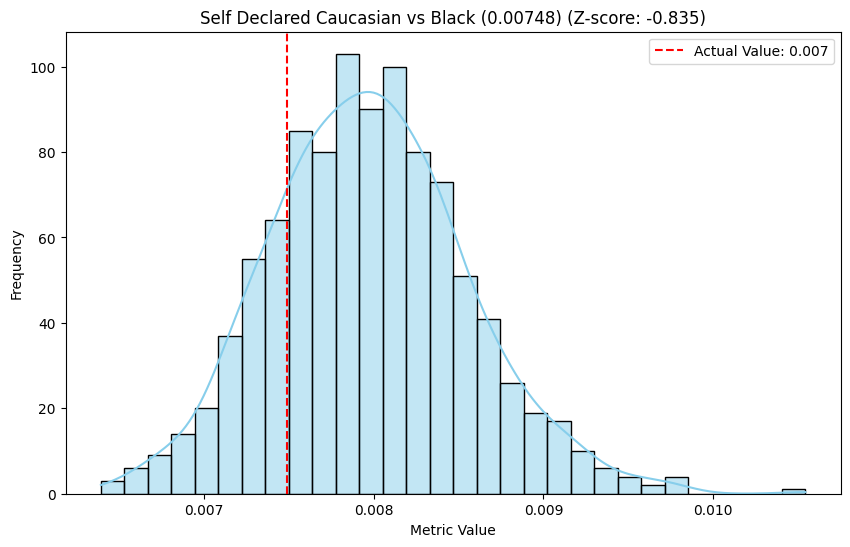

Z-score: -0.835
0.007488168776035309


In [26]:
protected_attributes = data_MHI['selfreported_pop']
z_score, bootstrapped_values, actual_value = bootstrap_fairness_test(Y_pred, protected_attributes, labels=Y_MHI, metric_func=demographic_parity, average='macro', include_groups=['Caucasian', 'Black'], title='Self Declared Caucasian vs Black (0.00748)')
print(f"Z-score: {z_score:.3f}")
print(actual_value)

In [27]:
data_MHI['Ancestry_Label'] = np.where(
    data_MHI[['AFR', 'SAS', 'EAS', 'EUR']].max(axis=1) > 0.7,  # Check if any value is > 0.7
    data_MHI[['AFR', 'SAS', 'EAS', 'EUR']].idxmax(axis=1),      # Get the column name with the maximum value
    'admixed'                                             # If none > 0.7, assign 'admixed'
)
data_MHI

index                                           npy_path  \
8           142  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
39          221  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
40          222  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
41          223  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
62          594  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
...         ...                                                ...   
206186  1290906  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
206254  1296316  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
206255  1296315  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
206279  1297353  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   
206280  1297356  /media/data1/anolin/temp_new_dataset/ecg_npy/0...   

       new_PatientID date_of_birth  calculated_age  \
8            0000138    01-26-1949              62   
39           0000166    05-30-1932              72   
40           0000166    05-30-1932              73   
41           0000166    05-30-1932              76   
62           0000440    05-17-1964              43   
...              ...           ...             ...   
206186       0538861    10-08-1944              73   
206254       0541064    05-16-1943              74   
206255       0541064    05-16-1943              75   
206279       0541500    12-13-1956              61   
206280       0541500    12-13-1956              61   

       RestingECG_PatientDemographics_Gender  \
8                                     FEMALE   
39                                      MALE   
40                                      MALE   
41                                      MALE   
62                                    FEMALE   
...                                      ...   
206186                                FEMALE   
206254                                  MALE   
206255                                  MALE   
206279                                  MALE   
206280                                  MALE   

       RestingECG_TestDemographics_Priority  \
8                                    NORMAL   
39                                   NORMAL   
40                                   NORMAL   
41                                   NORMAL   
62                                   NORMAL   
...                                     ...   
206186                               NORMAL   
206254                               NORMAL   
206255                               NORMAL   
206279                               NORMAL   
206280                               NORMAL   

       RestingECG_TestDemographics_Location  \
8                                        25   
39                                        1   
40                                        1   
41                                        1   
62                                        2   
...                                     ...   
206186                                   51   
206254                                   52   
206255                                   15   
206279                                   32   
206280                                   51   

       RestingECG_TestDemographics_LocationName  \
8                                 25_PRE-EFFORT   
39                       1_CARDIOLOGIE GENERALE   
40                       1_CARDIOLOGIE GENERALE   
41                       1_CARDIOLOGIE GENERALE   
62                   2_CLINIQUE DES CONGENITAUX   
...                                         ...   
206186                           5 COURT-SEJOUR   
206254                                    5 EST   
206255            15_CL PREV. CARDIOVASC (EPIC)   
206279                                    3 EST   
206280                           5 COURT-SEJOUR   

       RestingECG_PatientDemographics_Race      AFR  SAS      EAS      EUR  \
8                                  UNKNOWN  0.00000  0.0  0.00000  1.00000   
39                               CAUCASIAN  

Bootstrapping...:   1%|          | 6/1000 [00:00<00:17, 58.36it/s]

Bootstrapping...: 100%|██████████| 1000/1000 [00:17<00:00, 58.37it/s]


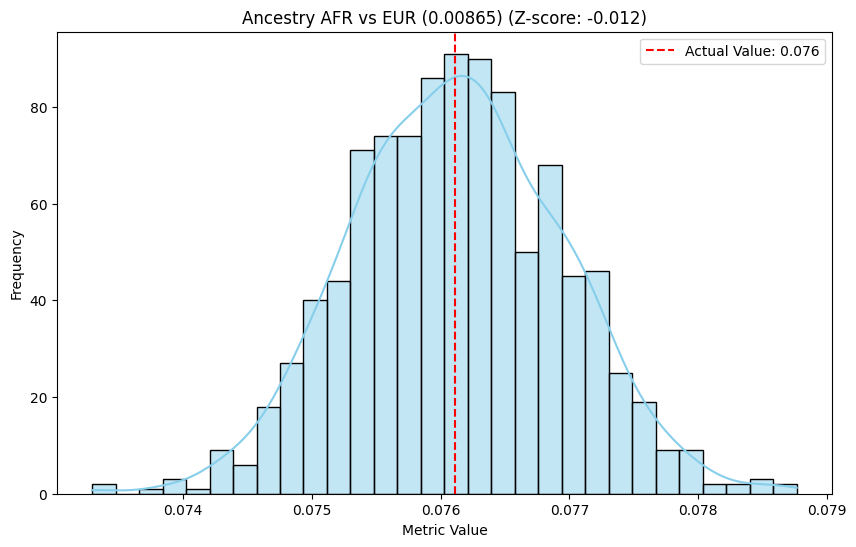

Z-score: -0.012
0.07611320167779922


In [28]:
protected_attributes = data_MHI['Ancestry_Label']

z_score, bootstrapped_values, actual_value = bootstrap_fairness_test(Y_pred, protected_attributes, labels=Y_MHI, metric_func=demographic_parity, average='micro', include_groups=['AFR', 'EUR'], title='Ancestry AFR vs EUR (0.00865)')
print(f"Z-score: {z_score:.3f}")
print(actual_value)

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

def pairwise_fairness_matrix_plot(predictions, protected_attributes, labels=None, metric_func=None, average='macro', title='Pairwise Group Comparison Matrix', min_count=10, exclude_unknown=True, exclude_native=True):
    """
    Create a pairwise comparison matrix for all unique groups in `protected_attributes`, plot it as a wide heatmap,
    and return the average difference across the matrix.

    Args:
        predictions (np.ndarray): Model predictions (N, num_labels).
        protected_attributes (np.ndarray): Array of protected attribute values (N,).
        labels (np.ndarray, optional): True labels (N, num_labels) (only required for predictive parity).
        metric_func (function, optional): Fairness metric function to use for pairwise comparisons. Defaults to demographic_parity.
        average (str): Averaging method ('micro' or 'macro').
        title (str): Title for the heatmap.
        min_count (int): Minimum count of entries required for each group to be considered.
        exclude_unknown (bool): If True, excludes 'UNKNOWN' and 'NotDone' from the analysis.
        exclude_native (bool): If True, excludes 'Native' from the analysis.

    Returns:
        float: Average difference across the comparison matrix.
    """
    # Convert to a pandas DataFrame to handle NaN values consistently
    data_df = pd.DataFrame({'predictions': list(predictions), 'protected_attributes': protected_attributes})
    if labels is not None:
        data_df['labels'] = list(labels)

    # Drop rows with missing protected attributes to ensure alignment
    data_df = data_df.dropna(subset=['protected_attributes'])

    # Optionally exclude 'UNKNOWN' and 'NotDone' categories if the flag is set
    if exclude_unknown:
        data_df = data_df[~data_df['protected_attributes'].isin(['UNKNOWN', 'NotDone'])]
    
    # Optionally exclude 'Native' category if the flag is set
    if exclude_native:
        data_df = data_df[~data_df['protected_attributes'].isin(['Native'])] #Native

    # Extract the filtered arrays
    predictions = np.array(list(data_df['predictions']))
    protected_attributes = np.array(data_df['protected_attributes'])
    labels = np.array(list(data_df['labels'])) if labels is not None else None

    # If no metric function is specified, use demographic_parity as the default
    if metric_func is None:
        metric_func = demographic_parity

    # Extract unique groups in protected_attributes
    unique_groups, group_counts = np.unique(protected_attributes, return_counts=True)
    
    # Filter out groups with fewer than the specified min_count
    valid_groups = unique_groups[group_counts >= min_count]

    # Initialize two matrices for storing results: one for actual values, one for annotations
    comparison_matrix = pd.DataFrame(index=valid_groups, columns=valid_groups, dtype=float)
    annotation_matrix = pd.DataFrame(index=valid_groups, columns=valid_groups, dtype=object)

    # List to keep track of valid values for average calculation
    valid_diffs = []

    # Iterate over all pairs of unique groups (including self-comparisons)
    for group1, group2 in tqdm(itertools.combinations_with_replacement(valid_groups, 2), desc='Calculating Pairwise Metrics'):
        # Create a mask for the two groups of interest
        mask1 = protected_attributes == group1
        mask2 = protected_attributes == group2

        # Skip this pair if either group has fewer than min_count entries
        if sum(mask1) < min_count or sum(mask2) < min_count:
            continue

        # Subset the data for the two groups
        group1_preds = predictions[mask1]
        group2_preds = predictions[mask2]

        # Subset labels if using Predictive Parity
        group1_labels = labels[mask1] if labels is not None else None
        group2_labels = labels[mask2] if labels is not None else None

        # Combine the two groups into a binary comparison dataset
        combined_preds = np.vstack([group1_preds, group2_preds])
        combined_attributes = np.concatenate([np.zeros(sum(mask1)), np.ones(sum(mask2))])  # 0 for group1, 1 for group2
        
        # Combined labels for Predictive Parity
        combined_labels = np.vstack([group1_labels, group2_labels]) if labels is not None else None

        # Calculate the actual metric for the two groups
        if 'demographic' in metric_func.__name__:
            actual_value = metric_func(combined_preds, combined_attributes, average=average)
        else:
            actual_value = metric_func(combined_preds, combined_labels, combined_attributes, average=average)

        # Store the valid differences for average calculation
        valid_diffs.append(actual_value)

        # Perform random shuffling to compute the mean and 95% CI
        random_values = []
        for _ in range(100):  # Using 100 random shuffles for the CI
            np.random.shuffle(combined_attributes)  # Shuffle the protected attributes
            if 'demographic' in metric_func.__name__:
                random_value = metric_func(combined_preds, combined_attributes, average=average)
            else:
                random_value = metric_func(combined_preds, combined_labels, combined_attributes, average=average)
            random_values.append(random_value)

        # Calculate mean and 95% confidence interval for the shuffled distribution
        random_values = np.array(random_values)
        mean_random = np.mean(random_values)
        std_random = np.std(random_values)
        lower_ci = mean_random - 1.96 * std_random
        upper_ci = mean_random + 1.96 * std_random

        # Format values with 4 significant figures
        formatted_actual_value = f"{actual_value:.4f}"
        formatted_mean_random = f"μ={mean_random:.4f}"  # Adding 'μ' for the mean value
        formatted_lower_ci = f"{lower_ci:.4f}"
        formatted_upper_ci = f"{upper_ci:.4f}"

        # Set the value in the comparison matrix (numeric values only)
        comparison_matrix.loc[group1, group2] = actual_value
        comparison_matrix.loc[group2, group1] = actual_value  # Symmetric matrix

        # Set cell value with actual and random distribution stats in the annotation matrix
        cell_value = f"{formatted_actual_value}\n{formatted_mean_random}\nCI=[{formatted_lower_ci}, {formatted_upper_ci}]"
        annotation_matrix.loc[group1, group2] = cell_value
        annotation_matrix.loc[group2, group1] = cell_value  # Symmetric matrix

    # Calculate the global average difference
    global_avg_diff = np.mean(valid_diffs) if valid_diffs else None

    # Update the title to include the global average score
    title += f" (Global Avg Diff: {global_avg_diff:.4f})" if global_avg_diff is not None else ""

    # Plot the pairwise group comparison matrix using a wide heatmap
    plt.figure(figsize=(30, 10))  # Increased width to make the plot wider
    sns.heatmap(
            comparison_matrix, 
            annot=annotation_matrix, 
            fmt='', 
            cmap='coolwarm', 
            cbar=True, 
            square=True, 
            linewidths=0.5, 
            annot_kws={"size": 7}  # Set font size for annotations
        )
    plt.title(title)
    plt.show()

    # Return the average difference across valid entries in the matrix
    return global_avg_diff

# Define Demographic Parity function
def demographic_parity(predictions, protected_attributes, average='macro'):
    """
    Calculate Demographic Parity for a multilabel classification model across multiple groups.
    
    Args:
        predictions (np.ndarray): Array of model predictions (N, num_labels) with binary values.
        protected_attributes (np.ndarray): Array of protected attribute values (N,).
        average (str): 'micro' or 'macro' averaging.

    Returns:
        float: Average Demographic Parity difference using specified averaging method.
    """
    # Convert inputs to numpy arrays if not already
    predictions = np.array(predictions)
    protected_attributes = np.array(protected_attributes)
    
    # Filter out entries where protected_attributes is None
    valid_mask = ~np.isnan(protected_attributes)
    predictions = predictions[valid_mask]
    protected_attributes = protected_attributes[valid_mask]

    unique_groups = np.unique(protected_attributes)
    group_probs = []

    for group in unique_groups:
        group_prob = predictions[protected_attributes == group].mean(axis=0)  # Mean probability for each label
        group_probs.append(group_prob)

    group_probs = np.array(group_probs)  # Shape: (num_groups, num_labels)
    
    if average == 'micro':
        avg_diff = group_probs.mean(axis=1).mean() - group_probs.min(axis=1).mean()
    elif average == 'macro':
        avg_diff = group_probs.mean(axis=0).mean() - group_probs.min(axis=0).mean()
    else:
        raise ValueError("average must be 'micro' or 'macro'")

    return avg_diff

In [30]:
data_MHI['RestingECG_PatientDemographics_Race'].value_counts()

CAUCASIAN           28093
UNKNOWN             10074
BLACK                 879
ORIENTAL              127
HISPANIC              104
ASIAN                 104
PACIFIC ISLANDER        8
AMERICAN INDIAN         3
Name: RestingECG_PatientDemographics_Race, dtype: int64

Calculating Pairwise Metrics: 3it [00:00,  5.34it/s]

Calculating Pairwise Metrics: 15it [00:03,  4.02it/s]


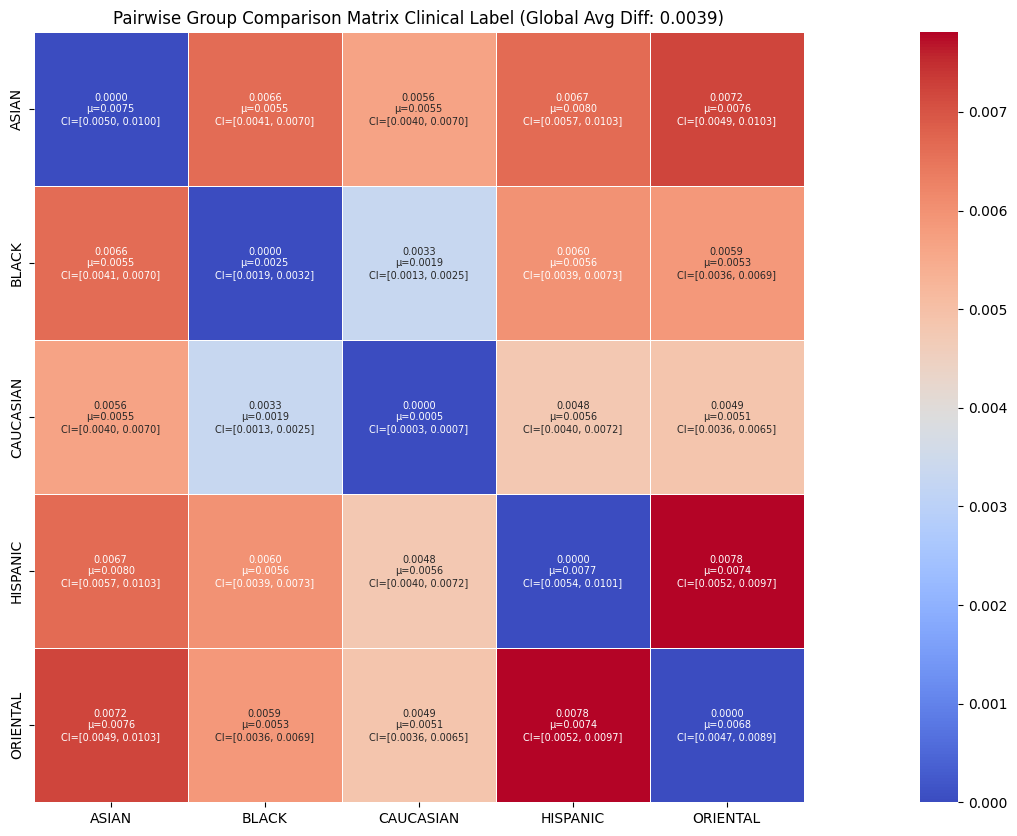

Z-score: -0.012
0.003917229466150367


In [31]:
protected_attributes = data_MHI['RestingECG_PatientDemographics_Race']

avg_diff = pairwise_fairness_matrix_plot(Y_pred, protected_attributes, labels=Y_MHI, metric_func=demographic_parity, title='Pairwise Group Comparison Matrix Clinical Label')
print(f"Z-score: {z_score:.3f}")
print(avg_diff)

Calculating Pairwise Metrics: 7it [00:01,  4.18it/s]

Calculating Pairwise Metrics: 15it [00:05,  2.68it/s]


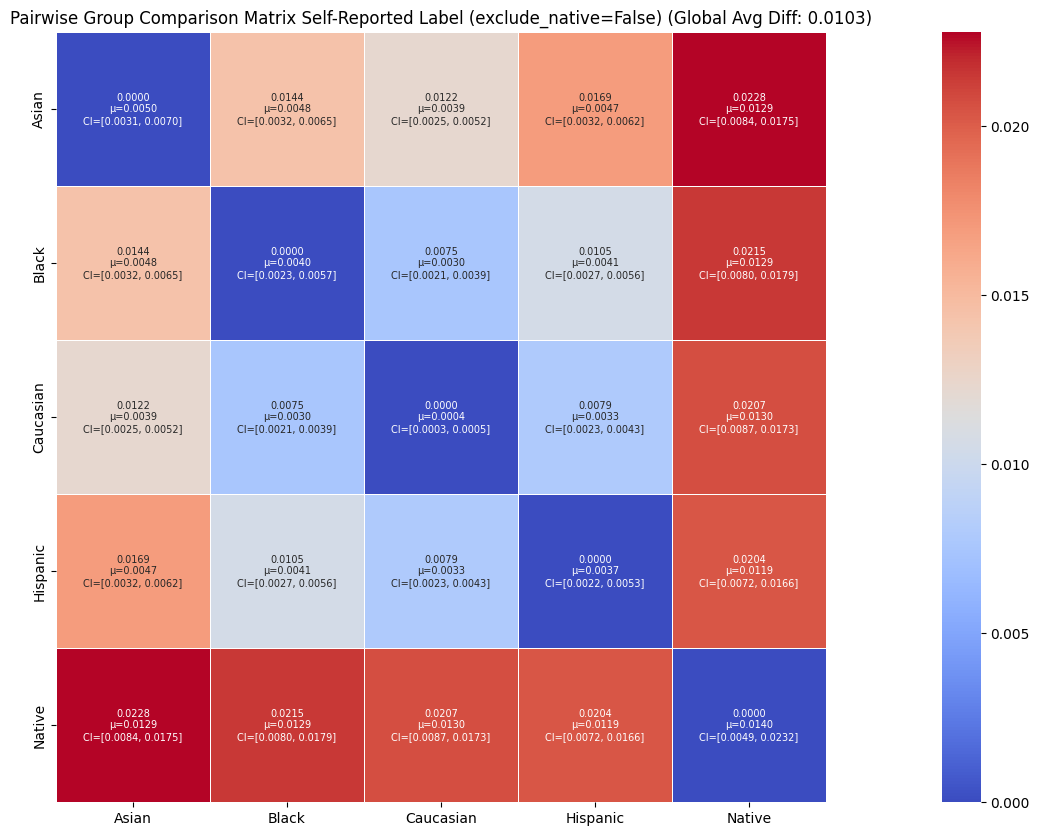

Z-score: -0.012
0.010317740729021528


In [32]:
protected_attributes = data_MHI['selfreported_pop']

avg_diff = pairwise_fairness_matrix_plot(Y_pred, protected_attributes, labels=Y_MHI, metric_func=demographic_parity, title='Pairwise Group Comparison Matrix Self-Reported Label (exclude_native=False)', exclude_native=False)
print(f"Z-score: {z_score:.3f}")
print(avg_diff)

Calculating Pairwise Metrics: 3it [00:00,  3.51it/s]

Calculating Pairwise Metrics: 10it [00:04,  2.02it/s]


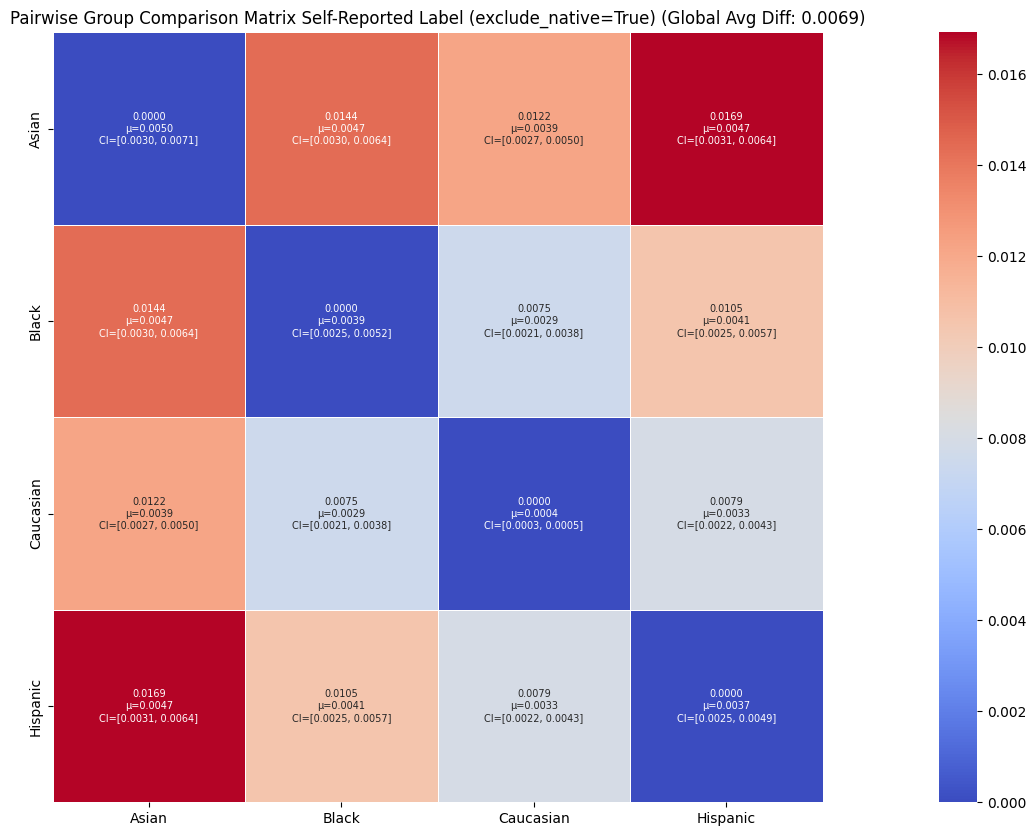

Z-score: -0.012
0.006947879156200804


In [33]:
protected_attributes = data_MHI['selfreported_pop']

avg_diff = pairwise_fairness_matrix_plot(Y_pred, protected_attributes, labels=Y_MHI, metric_func=demographic_parity, title='Pairwise Group Comparison Matrix Self-Reported Label (exclude_native=True)')
print(f"Z-score: {z_score:.3f}")
print(avg_diff)

Calculating Pairwise Metrics: 3it [00:00,  3.52it/s]

Calculating Pairwise Metrics: 15it [00:05,  2.71it/s]


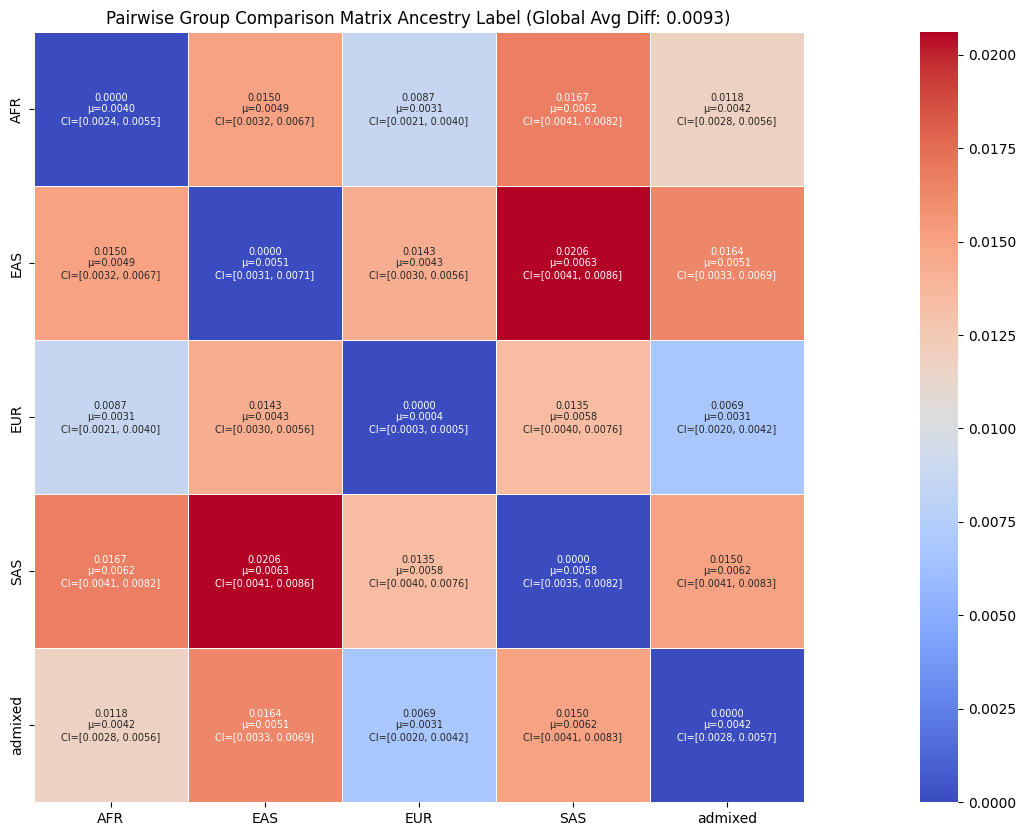

Z-score: -0.012
0.07611320167779922


In [34]:
protected_attributes = data_MHI['Ancestry_Label']

avg_diff = pairwise_fairness_matrix_plot(Y_pred, protected_attributes, labels=Y_MHI, metric_func=demographic_parity, title='Pairwise Group Comparison Matrix Ancestry Label')
print(f"Z-score: {z_score:.3f}")
print(actual_value)

### equalized odds 

In [35]:

# Define the integrated bootstrapping test and plotting function with tqdm
def bootstrap_fairness_test(predictions, protected_attributes, labels=None, metric_func=None, n_iterations=1000, average='micro', include_groups=None, title=None):
    """
    Perform a bootstrapping test to evaluate fairness metrics and visualize the results.

    Args:
        predictions (np.ndarray): Model predictions (N, num_labels).
        protected_attributes (np.ndarray): Array of protected attribute values (N,).
        labels (np.ndarray, optional): True labels (N, num_labels) (only required for predictive parity).
        metric_func (function, optional): Function to calculate fairness metric. Defaults to demographic_parity.
        n_iterations (int): Number of bootstrap iterations.
        average (str): Averaging method ('micro' or 'macro').
        include_groups (list, optional): List of specific groups in `protected_attributes` to consider. Defaults to None.
        title (str, optional): Custom title for the plot. If None, a default title is used.

    Returns:
        float: Z-score of the actual value against the bootstrapped distribution.
        list: List of bootstrapped metric values.
        float: Actual metric value.
    """
    # Convert object or categorical protected attributes to numerical codes
    if protected_attributes.dtype == 'object' or pd.api.types.is_categorical_dtype(protected_attributes):
        # Store the original categories for reference
        original_categories = pd.Categorical(protected_attributes).categories
        # Convert to numerical codes
        protected_attributes = pd.Categorical(protected_attributes).codes

        # If include_groups is provided, map it to the corresponding numerical codes
        if include_groups is not None:
            include_groups = [list(original_categories).index(group) for group in include_groups if group in original_categories]

    # Filter the data based on include_groups if specified
    if include_groups is not None:
        # Create a mask for rows that belong to the specified groups
        include_mask = np.isin(protected_attributes, include_groups)
        predictions = predictions[include_mask]
        protected_attributes = protected_attributes[include_mask]
        if labels is not None:
            labels = labels[include_mask]

    # Default to demographic_parity if no metric function is provided
    if metric_func is None:
        metric_func = demographic_parity

    # Calculate the actual metric value using the specified or default function
    if callable(metric_func) and 'demographic' in metric_func.__name__:
        actual_value = metric_func(predictions, protected_attributes, average=average)
    elif callable(metric_func):
        actual_value = metric_func(predictions, labels, protected_attributes, average=average)
    else:
        raise ValueError("Invalid metric function provided. Please pass the actual function, not a string.")

    # Store the bootstrapped values
    bootstrapped_values = []

    # Perform bootstrapping with a progress bar
    for _ in tqdm(range(n_iterations), desc='Bootstrapping...'):
        # Randomly sample indices with replacement
        indices = np.random.choice(range(predictions.shape[0]), size=predictions.shape[0], replace=True)
        sampled_predictions = predictions[indices]
        sampled_labels = labels[indices] if labels is not None else None
        sampled_attributes = protected_attributes[indices]

        # Calculate the metric for the sampled data
        if 'demographic' in metric_func.__name__:
            bootstrapped_value = metric_func(sampled_predictions, sampled_attributes, average=average)
        else:
            bootstrapped_value = metric_func(sampled_predictions, sampled_labels, sampled_attributes, average=average)
        
        bootstrapped_values.append(bootstrapped_value)

    # Convert to numpy array
    bootstrapped_values = np.array(bootstrapped_values)

    # Calculate mean and standard deviation of the bootstrapped distribution
    mean_bootstrap = np.mean(bootstrapped_values)
    std_bootstrap = np.std(bootstrapped_values)

    # Calculate the z-score for the actual value
    z_score = (actual_value - mean_bootstrap) / std_bootstrap

    # Determine the title
    if title is None:
        title = f"Bootstrap Distribution of {metric_func.__name__.replace('_', ' ').title()} (Z-score: {z_score:.3f})"
    else:
        title = f"{title} (Z-score: {z_score:.3f})"

    # Plot the bootstrapped distribution and the actual value with z-score in the title
    plt.figure(figsize=(10, 6))
    sns.histplot(bootstrapped_values, bins=30, kde=True, color='skyblue')
    plt.axvline(actual_value, color='red', linestyle='--', label=f'Actual Value: {actual_value:.3f}')
    plt.title(title)
    plt.xlabel('Metric Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    return z_score, bootstrapped_values, actual_value

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm



def equalized_odds(predictions, labels, protected_attributes, average='micro'):
    """
    Calculate Equalized Odds for a multilabel classification model across multiple groups.
    
    Args:
        predictions (np.ndarray): Array of model predictions (N, num_labels) with binary values.
        labels (np.ndarray): Array of true labels (N, num_labels).
        protected_attributes (np.ndarray): Array of protected attribute values (N,) (can be multiple groups).
        average (str): 'micro' or 'macro' averaging method.

    Returns:
        float: Average Equalized Odds difference.
    """
    # Check for shape consistency
    assert predictions.shape == labels.shape, "Shape mismatch between predictions and labels"
    assert predictions.shape[0] == protected_attributes.shape[0], "Number of samples in predictions and protected attributes must match"
    
    unique_groups = np.unique(protected_attributes)
    tpr_diffs = []
    fpr_diffs = []

    # Calculate TPR and FPR for each group
    for group in unique_groups:
        group_mask = protected_attributes == group
        group_preds = predictions[group_mask]
        group_labels = labels[group_mask]

        # Calculate TPR: True Positives / (True Positives + False Negatives)
        tp = (group_preds * group_labels).sum(axis=0)
        fn = ((1 - group_preds) * group_labels).sum(axis=0)
        tpr = tp / (tp + fn + 1e-8)  # Add a small value to prevent division by zero

        # Calculate FPR: False Positives / (False Positives + True Negatives)
        fp = (group_preds * (1 - group_labels)).sum(axis=0)
        tn = ((1 - group_preds) * (1 - group_labels)).sum(axis=0)
        fpr = fp / (fp + tn + 1e-8)

        # Store results for each group
        tpr_diffs.append(tpr)
        fpr_diffs.append(fpr)

    tpr_diffs = np.array(tpr_diffs)
    fpr_diffs = np.array(fpr_diffs)

    # Calculate Equalized Odds as the average difference in TPR and FPR across groups
    if average == 'micro':
        # Micro-average: average across all groups and labels
        avg_tpr_diff = np.mean(np.abs(tpr_diffs.mean(axis=1) - tpr_diffs.min(axis=1)))
        avg_fpr_diff = np.mean(np.abs(fpr_diffs.mean(axis=1) - fpr_diffs.min(axis=1)))
    elif average == 'macro':
        # Macro-average: calculate across labels first, then take the average
        avg_tpr_diff = np.mean(np.abs(tpr_diffs.mean(axis=0) - tpr_diffs.min(axis=0)))
        avg_fpr_diff = np.mean(np.abs(fpr_diffs.mean(axis=0) - fpr_diffs.min(axis=0)))
    else:
        raise ValueError("average must be 'micro' or 'macro'")

    # Return the sum of TPR and FPR differences as the Equalized Odds difference
    avg_diff = avg_tpr_diff + avg_fpr_diff

    return avg_diff

Bootstrapping...:   1%|          | 12/1000 [00:00<00:29, 33.35it/s]

Bootstrapping...: 100%|██████████| 1000/1000 [00:29<00:00, 33.54it/s]


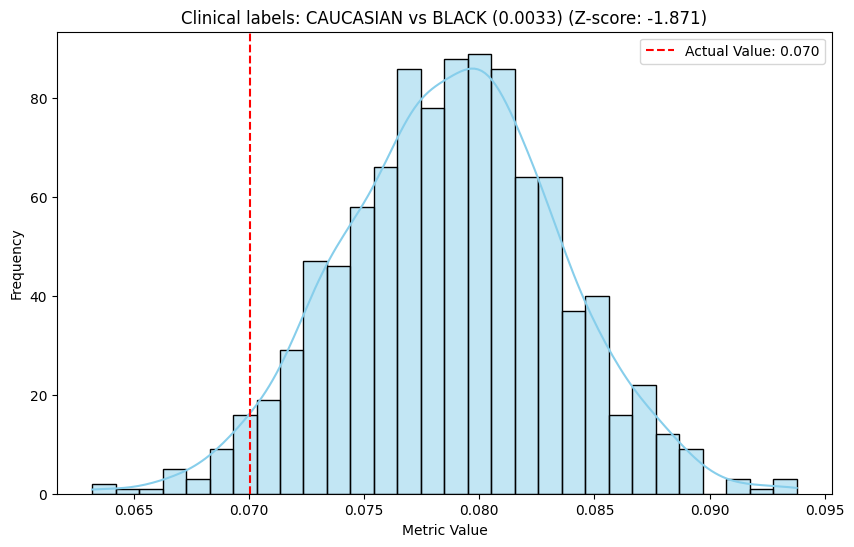

Z-score: -1.871
0.07003646860675952


In [37]:
protected_attributes = data_MHI['RestingECG_PatientDemographics_Race']
    
z_score, bootstrapped_values, actual_value = bootstrap_fairness_test(Y_pred, protected_attributes, labels=Y_MHI, metric_func=equalized_odds, average='macro', include_groups=['CAUCASIAN', 'BLACK'], title='Clinical labels: CAUCASIAN vs BLACK (0.0033)')
print(f"Z-score: {z_score:.3f}")
print(actual_value)

Bootstrapping...:   0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrapping...: 100%|██████████| 1000/1000 [00:41<00:00, 24.00it/s]


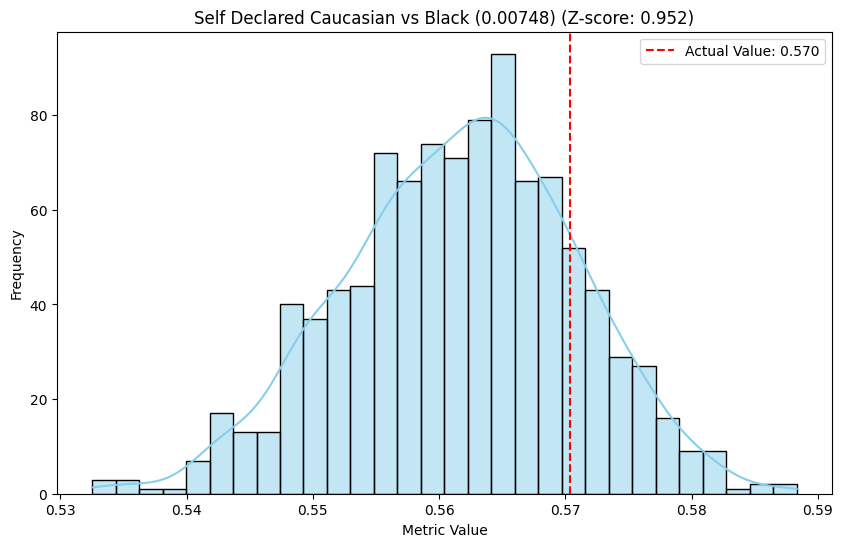

Z-score: 0.952
0.570356501168365


In [38]:
protected_attributes = data_MHI['selfreported_pop']
    
z_score, bootstrapped_values, actual_value = bootstrap_fairness_test(Y_pred, protected_attributes, labels=Y_MHI, metric_func=equalized_odds, average='micro', include_groups=['Caucasian', 'Black'], title='Self Declared Caucasian vs Black (0.00748)')
print(f"Z-score: {z_score:.3f}")
print(actual_value)

Bootstrapping...:   3%|▎         | 33/1000 [00:01<00:40, 23.97it/s]

Bootstrapping...: 100%|██████████| 1000/1000 [00:42<00:00, 23.64it/s]


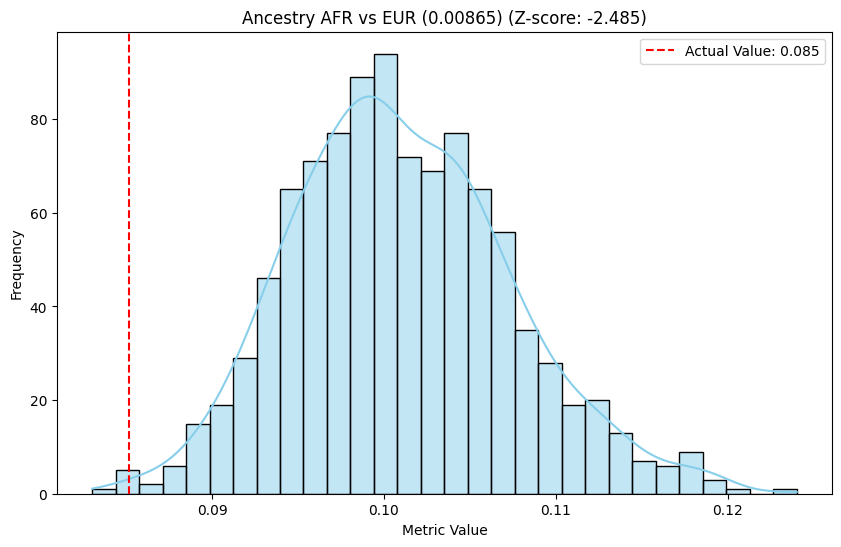

Z-score: -2.485
0.08518435676264917


In [39]:
protected_attributes = data_MHI['Ancestry_Label']

    
z_score, bootstrapped_values, actual_value = bootstrap_fairness_test(Y_pred, protected_attributes, labels=Y_MHI, metric_func=equalized_odds, average='macro',  include_groups=['AFR', 'EUR'], title='Ancestry AFR vs EUR (0.00865)')
print(f"Z-score: {z_score:.3f}")
print(actual_value)

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

def pairwise_fairness_matrix_plot(predictions, protected_attributes, labels=None, metric_func=None, average='macro', title='Pairwise Group Comparison Matrix', min_count=10, exclude_unknown=True, exclude_native=True):
    """
    Create a pairwise comparison matrix for all unique groups in `protected_attributes`, plot it as a wide heatmap,
    and return the average difference across the matrix.

    Args:
        predictions (np.ndarray): Model predictions (N, num_labels).
        protected_attributes (np.ndarray): Array of protected attribute values (N,).
        labels (np.ndarray, optional): True labels (N, num_labels) (only required for equalized odds).
        metric_func (function, optional): Fairness metric function to use for pairwise comparisons. Defaults to equalized_odds.
        average (str): Averaging method ('micro' or 'macro').
        title (str): Title for the heatmap.
        min_count (int): Minimum count of entries required for each group to be considered.
        exclude_unknown (bool): If True, excludes 'UNKNOWN' and 'NotDone' from the analysis.
        exclude_native (bool): If True, excludes 'Native' from the analysis.

    Returns:
        float: Average difference across the comparison matrix.
    """
    # Convert to a pandas DataFrame to handle NaN values consistently
    data_df = pd.DataFrame({'predictions': list(predictions), 'protected_attributes': protected_attributes})
    if labels is not None:
        data_df['labels'] = list(labels)

    # Drop rows with missing protected attributes to ensure alignment
    data_df = data_df.dropna(subset=['protected_attributes'])

    # Optionally exclude 'UNKNOWN' and 'NotDone' categories if the flag is set
    if exclude_unknown:
        data_df = data_df[~data_df['protected_attributes'].isin(['UNKNOWN', 'NotDone'])]
    
    # Optionally exclude 'Native' category if the flag is set
    if exclude_native:
        data_df = data_df[~data_df['protected_attributes'].isin(['Native'])]

    # Extract the filtered arrays
    predictions = np.array(list(data_df['predictions']))
    protected_attributes = np.array(data_df['protected_attributes'])
    labels = np.array(list(data_df['labels'])) if labels is not None else None

    # If no metric function is specified, use equalized_odds as the default
    if metric_func is None:
        metric_func = equalized_odds

    # Extract unique groups in protected_attributes
    unique_groups, group_counts = np.unique(protected_attributes, return_counts=True)
    
    # Filter out groups with fewer than the specified min_count
    valid_groups = unique_groups[group_counts >= min_count]

    # Initialize two matrices for storing results: one for actual values, one for annotations
    comparison_matrix = pd.DataFrame(index=valid_groups, columns=valid_groups, dtype=float)
    annotation_matrix = pd.DataFrame(index=valid_groups, columns=valid_groups, dtype=object)

    # List to keep track of valid values for average calculation
    valid_diffs = []

    # Iterate over all pairs of unique groups (including self-comparisons)
    for group1, group2 in tqdm(itertools.combinations_with_replacement(valid_groups, 2), desc='Calculating Pairwise Metrics'):
        # Create a mask for the two groups of interest
        mask1 = protected_attributes == group1
        mask2 = protected_attributes == group2

        # Skip this pair if either group has fewer than min_count entries
        if sum(mask1) < min_count or sum(mask2) < min_count:
            continue

        # Subset the data for the two groups
        group1_preds = predictions[mask1]
        group2_preds = predictions[mask2]

        # Subset labels if using a label-dependent metric like equalized odds
        group1_labels = labels[mask1] if labels is not None else None
        group2_labels = labels[mask2] if labels is not None else None

        # Combine the two groups into a binary comparison dataset
        combined_preds = np.vstack([group1_preds, group2_preds])
        combined_attributes = np.concatenate([np.zeros(sum(mask1)), np.ones(sum(mask2))])  # 0 for group1, 1 for group2
        
        # Combined labels for Equalized Odds
        combined_labels = np.vstack([group1_labels, group2_labels]) if labels is not None else None

        # Calculate the actual metric for the two groups
        if labels is None:  # For metrics like demographic parity that don't need labels
            actual_value = metric_func(combined_preds, combined_attributes, average=average)
        else:  # For label-dependent metrics like equalized odds
            actual_value = metric_func(combined_preds, combined_labels, combined_attributes, average=average)

        # Store the valid differences for average calculation
        valid_diffs.append(actual_value)

        # Perform random shuffling to compute the mean and 95% CI
        random_values = []
        for _ in range(100):  # Using 100 random shuffles for the CI
            np.random.shuffle(combined_attributes)  # Shuffle the protected attributes
            if labels is None:
                random_value = metric_func(combined_preds, combined_attributes, average=average)
            else:
                random_value = metric_func(combined_preds, combined_labels, combined_attributes, average=average)
            random_values.append(random_value)

        # Calculate mean and 95% confidence interval for the shuffled distribution
        random_values = np.array(random_values)
        mean_random = np.mean(random_values)
        std_random = np.std(random_values)
        lower_ci = mean_random - 1.96 * std_random
        upper_ci = mean_random + 1.96 * std_random

        # Format values with 4 significant figures
        formatted_actual_value = f"{actual_value:.4f}"
        formatted_mean_random = f"μ={mean_random:.4f}"  # Adding 'μ' for the mean value
        formatted_lower_ci = f"{lower_ci:.4f}"
        formatted_upper_ci = f"{upper_ci:.4f}"

        # Set the value in the comparison matrix (numeric values only)
        comparison_matrix.loc[group1, group2] = actual_value
        comparison_matrix.loc[group2, group1] = actual_value  # Symmetric matrix

        # Set cell value with actual and random distribution stats in the annotation matrix
        cell_value = f"{formatted_actual_value}\n{formatted_mean_random}\nCI=[{formatted_lower_ci}, {formatted_upper_ci}]"
        annotation_matrix.loc[group1, group2] = cell_value
        annotation_matrix.loc[group2, group1] = cell_value  # Symmetric matrix

    # Calculate the global average difference
    global_avg_diff = np.mean(valid_diffs) if valid_diffs else None

    # Update the title to include the global average score
    title += f" (Global Avg Diff: {global_avg_diff:.4f})" if global_avg_diff is not None else ""

    # Plot the pairwise group comparison matrix using a wide heatmap
    plt.figure(figsize=(30, 10))  # Increased width to make the plot wider
    sns.heatmap(
            comparison_matrix, 
            annot=annotation_matrix, 
            fmt='', 
            cmap='coolwarm', 
            cbar=True, 
            square=True, 
            linewidths=0.5, 
            annot_kws={"size": 7}  # Set font size for annotations
        )
    plt.title(title)
    plt.show()

    # Return the average difference across valid entries in the matrix
    return global_avg_diff

Calculating Pairwise Metrics: 15it [00:14,  1.05it/s]


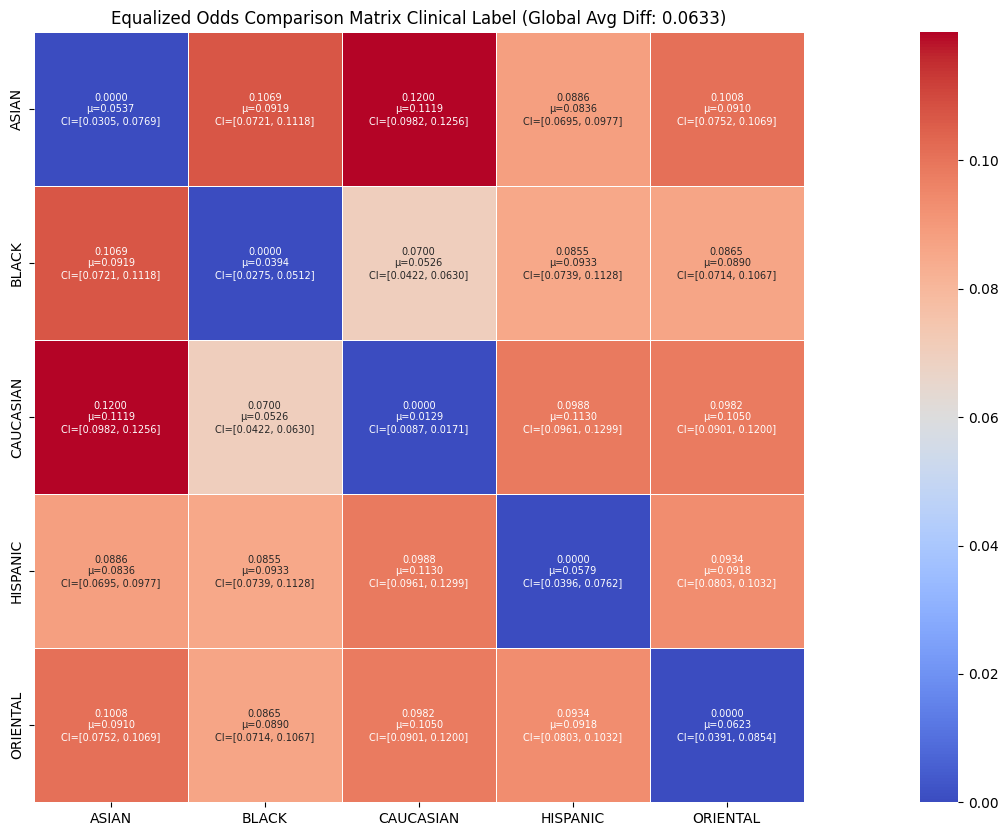

Z-score: -2.485
0.06325073588883413


In [41]:
protected_attributes = data_MHI['RestingECG_PatientDemographics_Race']

avg_diff = pairwise_fairness_matrix_plot(Y_pred, protected_attributes, labels=Y_MHI, title='Equalized Odds Comparison Matrix Clinical Label')
print(f"Z-score: {z_score:.3f}")
print(avg_diff)

Calculating Pairwise Metrics: 15it [00:20,  1.34s/it]


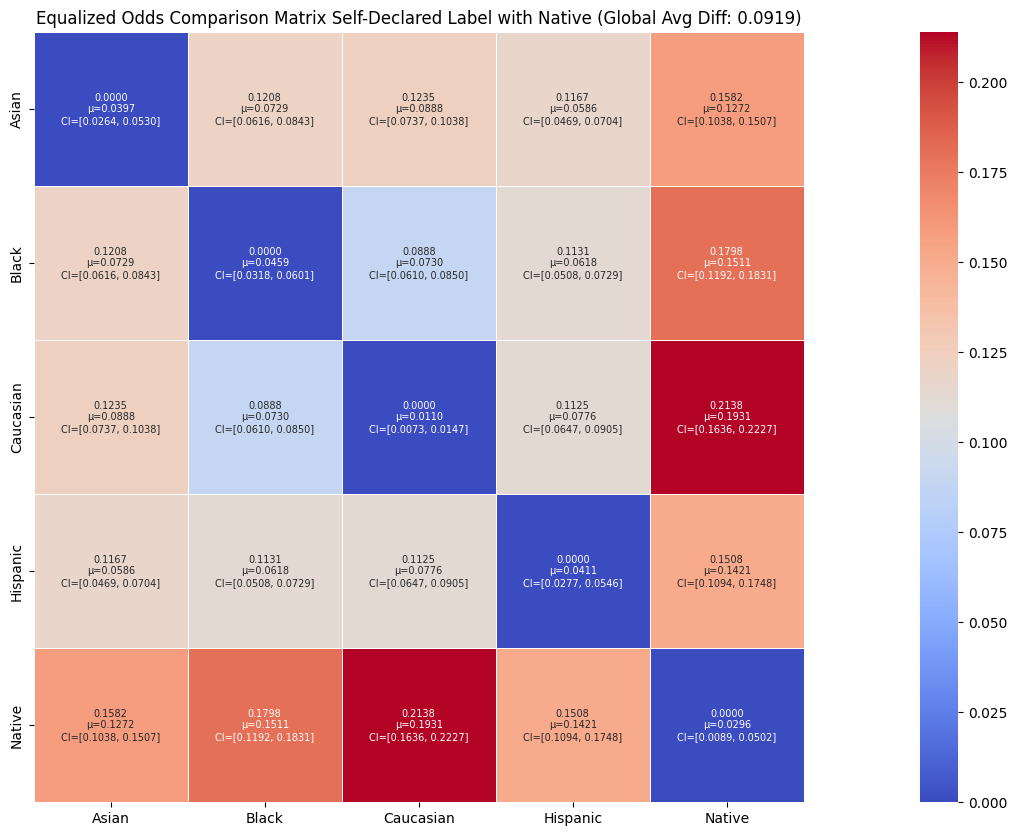

Z-score: -2.485
0.09186550520420794


In [42]:
protected_attributes = data_MHI['selfreported_pop']

avg_diff = pairwise_fairness_matrix_plot(Y_pred, protected_attributes, labels=Y_MHI, title='Equalized Odds Comparison Matrix Self-Declared Label with Native', exclude_native=False)
print(f"Z-score: {z_score:.3f}")
print(avg_diff)

Calculating Pairwise Metrics: 8it [00:06,  1.04it/s]

Calculating Pairwise Metrics: 15it [00:20,  1.36s/it]


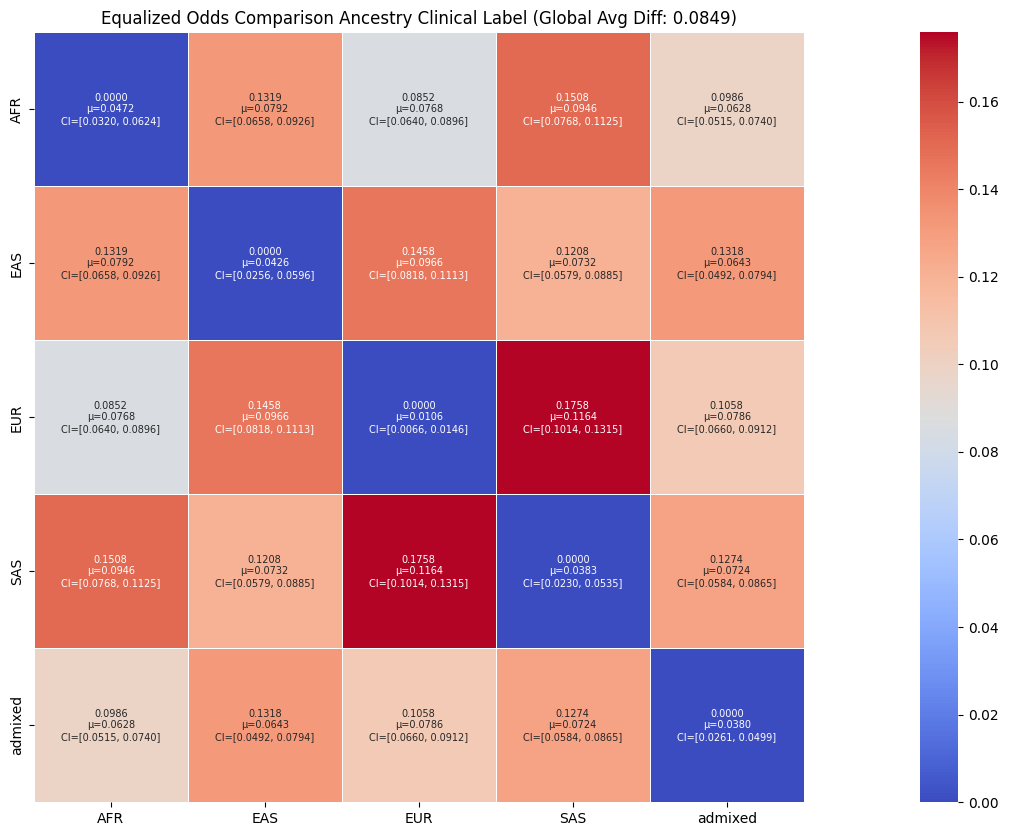

Z-score: -2.485
0.08518435676264917


In [43]:
protected_attributes = data_MHI['Ancestry_Label']

avg_diff = pairwise_fairness_matrix_plot(Y_pred, protected_attributes, labels=Y_MHI, title='Equalized Odds Comparison Ancestry Clinical Label')
print(f"Z-score: {z_score:.3f}")
print(actual_value)

## FPR and FNR

In [44]:
import numpy as np

def fpr_fnr_differences(predictions, labels, protected_attributes, include_groups=None):
    """
    Calculate both micro and macro False Positive Rate (FPR) and False Negative Rate (FNR) differences between groups.

    Args:
        predictions (np.ndarray): Array of model predictions.
        labels (np.ndarray): Array of true labels.
        protected_attributes (np.ndarray): Array of protected attribute values.
        include_groups (list, optional): List of specific groups to include in the comparison.

    Returns:
        dict: Dictionary containing micro and macro FPR and FNR differences, as well as pairwise comparisons.
    """
    # If include_groups is provided, filter the data to only include the specified groups
    if include_groups is not None:
        include_mask = np.isin(protected_attributes, include_groups)
        predictions = predictions[include_mask]
        labels = labels[include_mask]
        protected_attributes = protected_attributes[include_mask]

    # Identify unique groups in the protected attribute set
    unique_groups = np.unique(protected_attributes)

    # Calculate TPR and FPR for each group
    tpr_diffs = []
    fpr_diffs = []

    # Store results for each group
    group_tpr = {}
    group_fpr = {}

    for group in unique_groups:
        # Create a mask for the current group
        group_mask = protected_attributes == group
        group_preds = predictions[group_mask]
        group_labels = labels[group_mask]

        # Calculate True Positives, False Positives, False Negatives, and True Negatives
        tp = (group_preds * group_labels).sum(axis=0)
        fn = ((1 - group_preds) * group_labels).sum(axis=0)
        fp = (group_preds * (1 - group_labels)).sum(axis=0)
        tn = ((1 - group_preds) * (1 - group_labels)).sum(axis=0)

        # Calculate TPR and FPR
        tpr = tp / (tp + fn + 1e-8)
        fpr = fp / (fp + tn + 1e-8)

        group_tpr[group] = tpr
        group_fpr[group] = fpr

        tpr_diffs.append(tpr)
        fpr_diffs.append(fpr)

    # Convert lists to numpy arrays
    tpr_diffs = np.array(tpr_diffs)
    fpr_diffs = np.array(fpr_diffs)

    # Calculate pairwise differences between groups
    pairwise_diffs = {}
    for i, group1 in enumerate(unique_groups):
        for j, group2 in enumerate(unique_groups):
            if i >= j:
                continue
            group1_tpr = group_tpr[group1]
            group2_tpr = group_tpr[group2]
            group1_fpr = group_fpr[group1]
            group2_fpr = group_fpr[group2]

            fpr_diff = np.abs(group1_fpr - group2_fpr).mean()
            fnr_diff = np.abs(group1_tpr - group2_tpr).mean()  # FNR = 1 - TPR

            pairwise_diffs[f"{group1} vs {group2}"] = {
                'FPR_Diff': round(fpr_diff, 4),
                'FNR_Diff': round(fnr_diff, 4)
            }

    # Calculate micro-averaged FPR and FNR
    micro_fpr_diff = np.abs(fpr_diffs.mean(axis=1).mean() - fpr_diffs.min(axis=1).mean())
    micro_fnr_diff = np.abs(tpr_diffs.mean(axis=1).mean() - tpr_diffs.min(axis=1).mean())

    # Calculate macro-averaged FPR and FNR
    macro_fpr_diff = np.abs(fpr_diffs.mean(axis=0).mean() - fpr_diffs.min(axis=0).mean())
    macro_fnr_diff = np.abs(tpr_diffs.mean(axis=0).mean() - tpr_diffs.min(axis=0).mean())

    # Return the results
    return {
        'Pairwise_Differences': pairwise_diffs,
        'Micro_FPR': round(micro_fpr_diff, 4),
        'Micro_FNR': round(micro_fnr_diff, 4),
        'Macro_FPR': round(macro_fpr_diff, 4),
        'Macro_FNR': round(macro_fnr_diff, 4)
    }

In [45]:
protected_attributes = data_MHI['RestingECG_PatientDemographics_Race']

fpr_fnr_differences(Y_pred, Y_MHI, protected_attributes,  include_groups=['CAUCASIAN', 'BLACK'])

{'Pairwise_Differences': {'BLACK vs CAUCASIAN': {'FPR_Diff': 0.005,
   'FNR_Diff': 0.1351}},
 'Micro_FPR': 0.0259,
 'Micro_FNR': 0.5619,
 'Macro_FPR': 0.0025,
 'Macro_FNR': 0.0675}

In [46]:
protected_attributes = data_MHI['selfreported_pop']

fpr_fnr_differences(Y_pred, Y_MHI, protected_attributes,  include_groups=['Caucasian', 'Black'])

{'Pairwise_Differences': {'Black vs Caucasian': {'FPR_Diff': 0.0061,
   'FNR_Diff': 0.1714}},
 'Micro_FPR': 0.0233,
 'Micro_FNR': 0.5471,
 'Macro_FPR': 0.0031,
 'Macro_FNR': 0.0857}

In [47]:
protected_attributes = data_MHI['Ancestry_Label']

fpr_fnr_differences(Y_pred, Y_MHI, protected_attributes,  include_groups=['AFR', 'EUR'])

{'Pairwise_Differences': {'AFR vs EUR': {'FPR_Diff': 0.006,
   'FNR_Diff': 0.1644}},
 'Micro_FPR': 0.0232,
 'Micro_FNR': 0.5479,
 'Macro_FPR': 0.003,
 'Macro_FNR': 0.0822}

## FPR and TPL results

In [70]:
import numpy as np
from scipy.stats import norm

def fpr_tpr_ci_groupwise(predictions, labels, protected_attributes, include_groups=None, confidence=0.95, normalize=True):
    """
    Calculate the mean and 95% CI for both FPR and TPR for each group in `protected_attributes`.

    Args:
        predictions (np.ndarray): Array of model predictions (N, num_labels) with binary values.
        labels (np.ndarray): Array of true labels (N, num_labels).
        protected_attributes (np.ndarray): Array of protected attribute values (N,) corresponding to each prediction/label.
        include_groups (list, optional): List of specific groups to include in the comparison.
        confidence (float): Confidence interval percentage. Default is 95%.
        normalize (bool): Whether to normalize TPR and FPR by group size.

    Returns:
        dict: Dictionary containing group-wise mean and CI for FPR and TPR, and overall micro/macro results.
    """
    # Remove or replace None values in protected_attributes to avoid TypeError
    protected_attributes = np.array([attr if attr is not None else 'UNKNOWN' for attr in protected_attributes])

    # Filter data based on specified groups if needed
    if include_groups is not None:
        include_mask = np.isin(protected_attributes, include_groups)
        predictions = predictions[include_mask]
        labels = labels[include_mask]
        protected_attributes = protected_attributes[include_mask]

    # Identify unique groups in the protected attribute set
    unique_groups = np.unique(protected_attributes)

    # Store results for each group
    groupwise_results = {}

    # Calculate TPR and FPR for each group
    for group in unique_groups:
        group_mask = protected_attributes == group
        group_preds = predictions[group_mask]
        group_labels = labels[group_mask]

        # Calculate True Positives, False Positives, False Negatives, and True Negatives
        tp = (group_preds * group_labels).sum(axis=0)
        fn = ((1 - group_preds) * group_labels).sum(axis=0)
        fp = (group_preds * (1 - group_labels)).sum(axis=0)
        tn = ((1 - group_preds) * (1 - group_labels)).sum(axis=0)

        # Calculate TPR and FPR for each group
        tpr = tp / (tp + fn + 1e-8)  # True Positive Rate
        fpr = fp / (fp + tn + 1e-8)  # False Positive Rate

        # Compute the mean and confidence interval for TPR and FPR
        mean_tpr = np.mean(tpr)
        mean_fpr = np.mean(fpr)
        
        # Calculate confidence intervals
        tpr_ci = norm.interval(confidence, loc=mean_tpr, scale=np.std(tpr) / np.sqrt(len(tpr)))
        fpr_ci = norm.interval(confidence, loc=mean_fpr, scale=np.std(fpr) / np.sqrt(len(fpr)))

        # Normalize by group size if specified
        group_size = group_mask.sum()
        if normalize and group_size > 0:
            mean_tpr /= group_size
            mean_fpr /= group_size
            tpr_ci = (tpr_ci[0] / group_size, tpr_ci[1] / group_size)
            fpr_ci = (fpr_ci[0] / group_size, fpr_ci[1] / group_size)

        # Store results for the current group
        groupwise_results[group] = {
            'Mean_TPR': round(mean_tpr, 4),
            'CI_TPR': [round(tpr_ci[0], 4), round(tpr_ci[1], 4)],
            'Mean_FPR': round(mean_fpr, 4),
            'CI_FPR': [round(fpr_ci[0], 4), round(fpr_ci[1], 4)]
        }

    # Convert TPR and FPR for each group into numpy arrays for global metrics
    tpr_diffs = np.array([groupwise_results[group]['Mean_TPR'] for group in unique_groups])
    fpr_diffs = np.array([groupwise_results[group]['Mean_FPR'] for group in unique_groups])

    # Calculate overall micro-averaged and macro-averaged FPR and TPR
    micro_fpr = fpr_diffs.mean()
    micro_tpr = tpr_diffs.mean()
    macro_fpr = np.mean([groupwise_results[group]['Mean_FPR'] for group in unique_groups])
    macro_tpr = np.mean([groupwise_results[group]['Mean_TPR'] for group in unique_groups])

    # Confidence intervals for micro/macro-averaged FPR and TPR
    micro_fpr_ci = norm.interval(confidence, loc=micro_fpr, scale=np.std(fpr_diffs) / np.sqrt(len(fpr_diffs)))
    micro_tpr_ci = norm.interval(confidence, loc=micro_tpr, scale=np.std(tpr_diffs) / np.sqrt(len(tpr_diffs)))
    macro_fpr_ci = norm.interval(confidence, loc=macro_fpr, scale=np.std(fpr_diffs) / np.sqrt(len(fpr_diffs)))
    macro_tpr_ci = norm.interval(confidence, loc=macro_tpr, scale=np.std(tpr_diffs) / np.sqrt(len(tpr_diffs)))

    # Return a comprehensive results dictionary
    return {
        'Groupwise_Results': groupwise_results,
        'Micro_FPR': round(micro_fpr, 4),
        'Micro_FPR_CI': [round(micro_fpr_ci[0], 4), round(micro_fpr_ci[1], 4)],
        'Micro_TPR': round(micro_tpr, 4),
        'Micro_TPR_CI': [round(micro_tpr_ci[0], 4), round(micro_tpr_ci[1], 4)],
        'Macro_FPR': round(macro_fpr, 4),
        'Macro_FPR_CI': [round(macro_fpr_ci[0], 4), round(macro_fpr_ci[1], 4)],
        'Macro_TPR': round(macro_tpr, 4),
        'Macro_TPR_CI': [round(macro_tpr_ci[0], 4), round(macro_tpr_ci[1], 4)]
    }

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

def plot_groupwise_fpr_tpr(results, title='Group-wise TPR and FPR with 95% Confidence Intervals'):
    """
    Plot group-wise FPR and TPR with confidence intervals, highlighting significant differences.

    Args:
        results (dict): Dictionary containing group-wise results, micro/macro values, and confidence intervals.
                        Should be structured as returned by the `fpr_tpr_ci_groupwise` function.
        title (str): Title for the plot. Default is 'Group-wise TPR and FPR with 95% Confidence Intervals'.
    """
    # Extract group-wise results
    groupwise_results = results.get('Groupwise_Results', {})

    # Prepare lists for plotting
    groups = list(groupwise_results.keys())
    mean_tpr = [groupwise_results[group]['Mean_TPR'] for group in groups]
    mean_fpr = [groupwise_results[group]['Mean_FPR'] for group in groups]
    tpr_ci = [groupwise_results[group]['CI_TPR'] for group in groups]
    fpr_ci = [groupwise_results[group]['CI_FPR'] for group in groups]

    # Calculate error bars for CI
    tpr_error = [(ci[1] - ci[0]) / 2 for ci in tpr_ci]
    fpr_error = [(ci[1] - ci[0]) / 2 for ci in fpr_ci]

    # Set up the figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Bar positions
    bar_width = 0.4
    bar_positions = range(len(groups))

    # Plot TPR with adjusted positions to center CIs
    tpr_bars = ax.bar(
        [pos - bar_width / 4 for pos in bar_positions],  # Adjusted to center TPR/FPR bars
        mean_tpr,
        width=bar_width / 2,  # Adjusted width for centering
        yerr=tpr_error,
        capsize=5,
        label='Mean TPR',
        color='skyblue'
    )

    # Plot FPR with adjusted positions
    fpr_bars = ax.bar(
        [pos + bar_width / 4 for pos in bar_positions],  # Adjusted to center TPR/FPR bars
        mean_fpr,
        width=bar_width / 2,  # Adjusted width for centering
        yerr=fpr_error,
        capsize=5,
        label='Mean FPR',
        color='salmon'
    )

    # Add statistical significance stars between groups
    for i, group1 in enumerate(groups):
        for j, group2 in enumerate(groups):
            if i >= j:
                continue
            # Perform t-tests between groups for TPR and FPR
            tpr_diff, tpr_pval = ttest_ind([groupwise_results[group1]['Mean_TPR']], [groupwise_results[group2]['Mean_TPR']])
            fpr_diff, fpr_pval = ttest_ind([groupwise_results[group1]['Mean_FPR']], [groupwise_results[group2]['Mean_FPR']])

            # Determine significance stars for TPR
            if tpr_pval < 0.05:
                significance = '***' if tpr_pval < 0.001 else '**' if tpr_pval < 0.01 else '*'
                x1, x2 = i - 0.15, j - 0.15  # Centered over TPR
                y = max(mean_tpr[i] + tpr_error[i], mean_tpr[j] + tpr_error[j]) + 0.02  # Position above bars
                ax.plot([x1, x1, x2, x2], [y, y + 0.01, y + 0.01, y], color='black', lw=1.5)  # Draw lines
                ax.text((x1 + x2) / 2, y + 0.02, significance, ha='center', color='black', fontsize=12)

            # Determine significance stars for FPR
            if fpr_pval < 0.05:
                significance = '***' if fpr_pval < 0.001 else '**' if fpr_pval < 0.01 else '*'
                x1, x2 = i + 0.15, j + 0.15  # Centered over FPR
                y = max(mean_fpr[i] + fpr_error[i], mean_fpr[j] + fpr_error[j]) + 0.02  # Position above bars
                ax.plot([x1, x1, x2, x2], [y, y + 0.01, y + 0.01, y], color='black', lw=1.5)  # Draw lines
                ax.text((x1 + x2) / 2, y + 0.02, significance, ha='center', color='black', fontsize=12)

    # Add labels and legend
    ax.set_xlabel('Groups')
    ax.set_ylabel('Rates')
    ax.set_title(title)  # Set the custom title here
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(groups, rotation=45, ha='right')
    ax.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

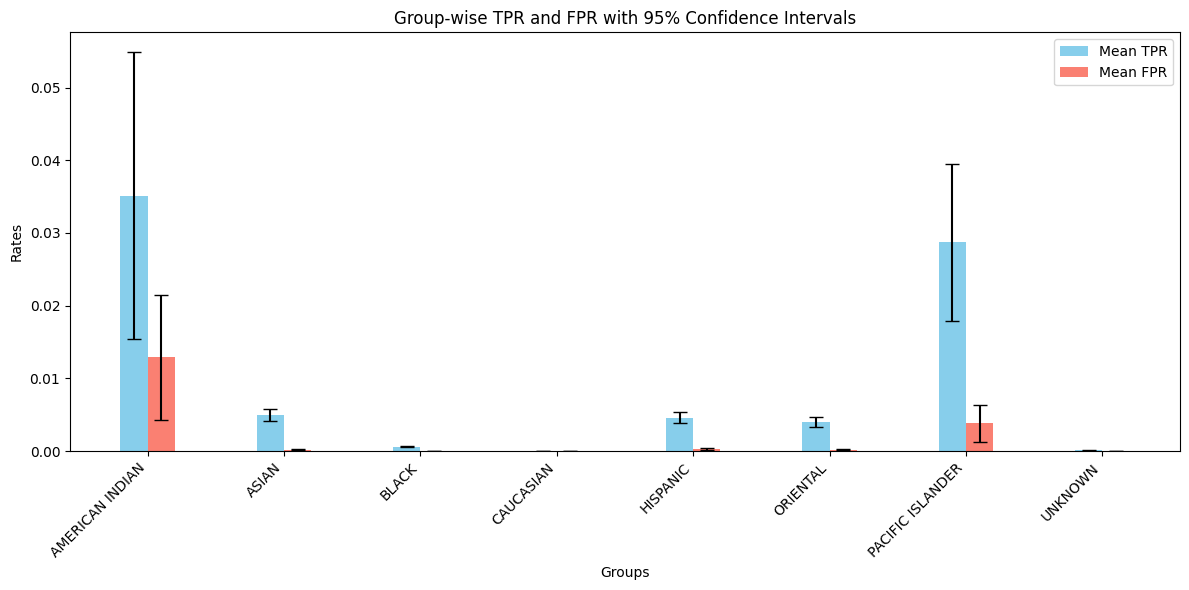

In [78]:
protected_attributes = data_MHI['RestingECG_PatientDemographics_Race']
results = fpr_tpr_ci_groupwise(Y_pred, Y_MHI, protected_attributes)
plot_groupwise_fpr_tpr(results)

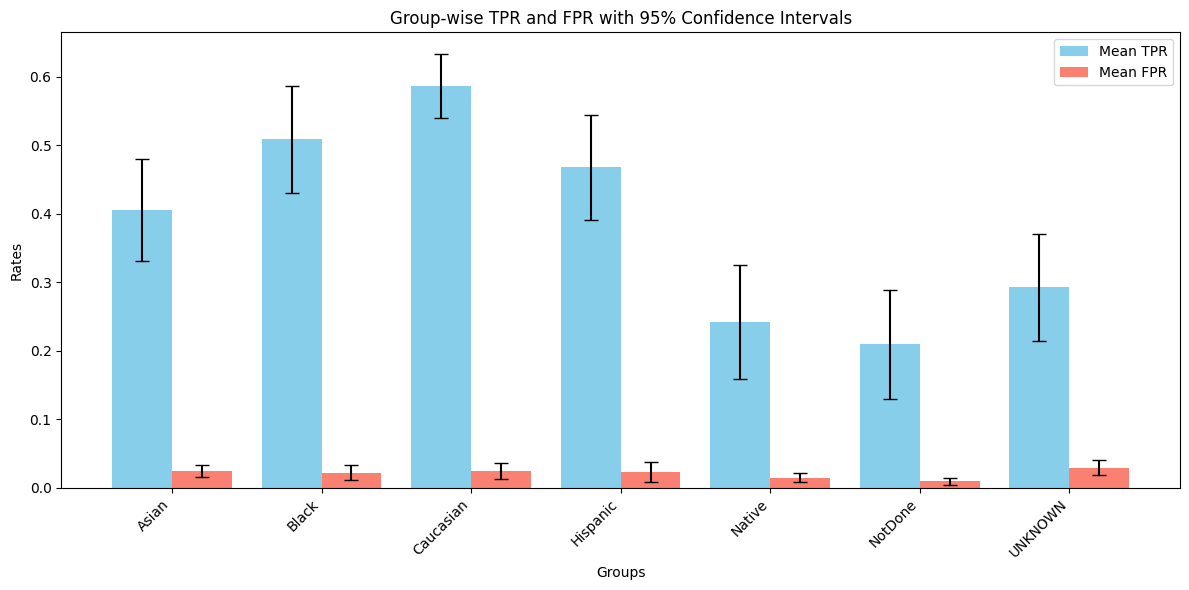

In [57]:
protected_attributes = data_MHI['selfreported_pop']
results = fpr_tpr_ci_groupwise(Y_pred, Y_MHI, protected_attributes)
plot_groupwise_fpr_tpr(results)

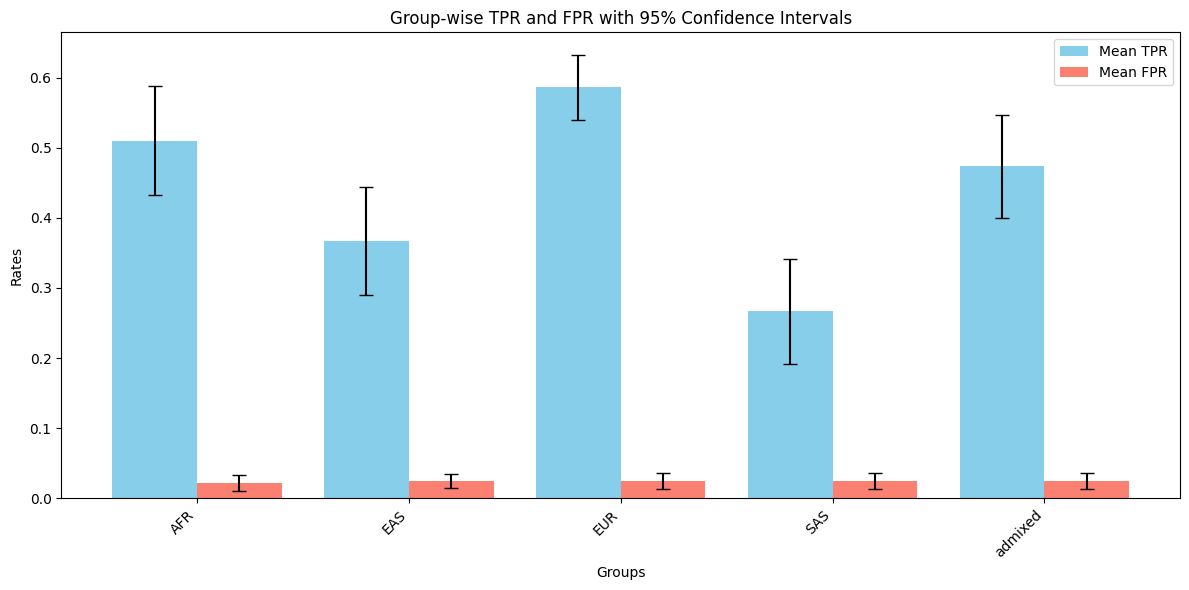

In [58]:
protected_attributes = data_MHI['Ancestry_Label']
results = fpr_tpr_ci_groupwise(Y_pred, Y_MHI, protected_attributes)
plot_groupwise_fpr_tpr(results)